In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os
from tqdm import tqdm
import time
import math

from net.network import AttentionNet, Encoder, Decoder, SelfAttention
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--dataset_dir', type=str, default='./datasets/style_set/val2014',
                    help='Directory path to a batch of content images')
# parser.add_argument('--dataset_dir', type=str, default='./datasets/style_set/val2014',
#                     help='Directory path to a batch of style images')
# parser.add_argument('--dataset_dir', type=str, default='./datasets/content_style_mix_set/val2014',
#                     help='Directory path to a batch of mixed images')


# training options
parser.add_argument('--save_dir', default='./models/style_wct',
                    help='Directory to save the model')
parser.add_argument('--log_dir', default='./logs',
                    help='Directory to save the log')
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--lr_decay', type=float, default=5e-5)
parser.add_argument('--max_iter', type=int, default=80000)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--n_threads', type=int, default=2)
parser.add_argument('--save_model_interval', type=int, default=100)
parser.add_argument('--start_iter', type=float, default=0)
parser.add_argument('--seperate', type=bool, default=False)
args = parser.parse_args('')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

In [4]:
# transforms.Normalize((0, 0, 0), (1/255.0, 1/255.0, 1/255.0))
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
}

class FlatFolderDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

train_set = FlatFolderDataset(args.dataset_dir, data_transforms['train'])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=args.batch_size,
    shuffle=True, num_workers=args.n_threads)
train_iter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


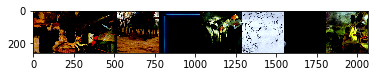

In [5]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images = dataiter.next()
print(images[0].size())
# show images
imshow(torchvision.utils.make_grid(images))


In [6]:
def get_optimizer(model, seperate):
    for param in model.encode.parameters():
        param.requires_grad = False
    if seperate == True:
        optimizer = torch.optim.Adam([
            {'params': model.self_attn_content.parameters()},
            {'params': model.self_attn_style.parameters()},
            {'params': model.content_decode.parameters()},
            {'params': model.style_decode.parameters()},
        ], lr=args.lr)
    else:
        optimizer = torch.optim.Adam([
            {'params': model.decode.parameters()},
            {'params': model.self_attn.parameters()},
        ], lr=args.lr)
    return optimizer

if(args.start_iter > 0):
    decoder = Decoder()
    decoder.load_state_dict(torch.load(args.save_dir + '/decoder_iter_' + str(args.start_iter) + '.pth'))
    attn = SelfAttention()
    attn.load_state_dict(torch.load(args.save_dir + '/attention_kernel_iter_' + str(args.start_iter) + '.pth'))
    
    state_dict = decoder.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    state_dict = attn.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    
    model = AttentionNet(seperate=args.seperate, attn=attn, decoder = decoder)
    optimizer = get_optimizer(model, args.seperate)
    optimizer.load_state_dict(torch.load(args.save_dir + '/optimizer_iter_' + str(args.start_iter) + '.pth'))
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
else:
    model = AttentionNet(seperate=args.seperate)
    optimizer = get_optimizer(model, args.seperate)

model.to(device)   
loss_seq = {'total': [], 'construct': [], 'percept': [], 'tv': [], 'attn': []}

In [7]:
def lastest_arverage_value(values, length=100):
    if len(values) < length:
        length = len(values)
    return sum(values[-length:])/length

def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr = args.lr / (1.0 + args.lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
reload_period = len(train_loader.dataset) / args.batch_size
reload_period = math.floor(reload_period)
for i in tqdm(range(args.start_iter, args.max_iter)):
    adjust_learning_rate(optimizer, iteration_count=i)
    
    if (i - args.start_iter)%reload_period == 0:
        train_loader = torch.utils.data.DataLoader(
            train_set, batch_size=args.batch_size,
            shuffle=True, num_workers=args.n_threads)
        train_iter = iter(train_loader)
        
    if args.seperate == False:
        content_images = next(train_iter).to(device)
        losses, _, _ = model(content_images)
        
    total_loss = losses['total']
    
    for name, vals in loss_seq.items():
        loss_seq[name].append(losses[name].item())
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (i + 1) % args.save_model_interval == 0 or (i + 1) == args.max_iter:
        print("%s: Iteration: [%d/%d]\tRecon Loss: %2.4f\tPercept Loss: %2.4f\tTV Loss: %2.4f\tAttn Loss: %2.4f\tTotal: %2.4f"%(time.ctime(),i+1, 
                args.max_iter, lastest_arverage_value(loss_seq['construct']), lastest_arverage_value(loss_seq['percept']), 
                lastest_arverage_value(loss_seq['tv']), lastest_arverage_value(loss_seq['attn']), lastest_arverage_value(loss_seq['total'])))
        if args.seperate == False:
            state_dict = model.decode.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/decoder_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = model.self_attn.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/attention_kernel_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = optimizer.state_dict()
            torch.save(state_dict,
                       '{:s}/optimizer_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
        else:
            pass
    
    

  0%|          | 99/80000 [01:11<15:29:25,  1.43it/s]

Tue Jul  7 02:32:22 2020: Iteration: [100/80000]	Recon Loss: 4775.8323	Percept Loss: 169360.3919	TV Loss: 5.4580	Attn Loss: 43836147.8000	Total: 263234060.8000


  0%|          | 199/80000 [02:21<15:27:20,  1.43it/s]

Tue Jul  7 02:33:32 2020: Iteration: [200/80000]	Recon Loss: 4359.8766	Percept Loss: 160249.7466	TV Loss: 4.1397	Attn Loss: 29778395.1600	Total: 178874260.6400


  0%|          | 299/80000 [03:31<15:30:59,  1.43it/s]

Tue Jul  7 02:34:42 2020: Iteration: [300/80000]	Recon Loss: 4293.6469	Percept Loss: 150146.2090	TV Loss: 4.0939	Attn Loss: 16837639.8500	Total: 101218962.7600


  0%|          | 399/80000 [04:41<15:28:51,  1.43it/s]

Tue Jul  7 02:35:52 2020: Iteration: [400/80000]	Recon Loss: 3375.7878	Percept Loss: 135825.6118	TV Loss: 4.8049	Attn Loss: 5411498.9988	Total: 32638625.3550


  1%|          | 499/80000 [05:52<15:32:20,  1.42it/s]

Tue Jul  7 02:37:02 2020: Iteration: [500/80000]	Recon Loss: 2426.1146	Percept Loss: 107578.5580	TV Loss: 6.5813	Attn Loss: 117168.6235	Total: 834917.2578


  1%|          | 599/80000 [07:02<15:32:47,  1.42it/s]

Tue Jul  7 02:38:13 2020: Iteration: [600/80000]	Recon Loss: 2055.4008	Percept Loss: 95483.9527	TV Loss: 7.3922	Attn Loss: 43243.0115	Total: 375569.9531


  1%|          | 699/80000 [08:12<15:27:26,  1.43it/s]

Tue Jul  7 02:39:23 2020: Iteration: [700/80000]	Recon Loss: 1847.8357	Percept Loss: 86544.0360	TV Loss: 7.7761	Attn Loss: 36751.8945	Total: 325611.5219


  1%|          | 799/80000 [09:23<15:30:18,  1.42it/s]

Tue Jul  7 02:40:33 2020: Iteration: [800/80000]	Recon Loss: 1597.5969	Percept Loss: 81292.6425	TV Loss: 8.1048	Attn Loss: 38547.8934	Total: 328637.0187


  1%|          | 899/80000 [10:33<15:38:26,  1.40it/s]

Tue Jul  7 02:41:44 2020: Iteration: [900/80000]	Recon Loss: 1478.5423	Percept Loss: 80026.2646	TV Loss: 8.3540	Attn Loss: 33387.3088	Total: 295219.0780


  1%|          | 999/80000 [11:44<15:26:27,  1.42it/s]

Tue Jul  7 02:42:54 2020: Iteration: [1000/80000]	Recon Loss: 1427.2173	Percept Loss: 76127.7720	TV Loss: 8.5251	Attn Loss: 33857.3139	Total: 293629.0784


  1%|▏         | 1099/80000 [12:54<15:36:50,  1.40it/s]

Tue Jul  7 02:44:05 2020: Iteration: [1100/80000]	Recon Loss: 1346.1350	Percept Loss: 78465.9808	TV Loss: 8.8801	Attn Loss: 32174.2936	Total: 285061.8947


  1%|▏         | 1199/80000 [14:05<15:24:46,  1.42it/s]

Tue Jul  7 02:45:15 2020: Iteration: [1200/80000]	Recon Loss: 1206.0986	Percept Loss: 73269.9897	TV Loss: 8.8361	Attn Loss: 32940.0825	Total: 283059.8295


  2%|▏         | 1299/80000 [15:15<15:23:41,  1.42it/s]

Tue Jul  7 02:46:25 2020: Iteration: [1300/80000]	Recon Loss: 1160.7735	Percept Loss: 73265.1763	TV Loss: 9.0132	Attn Loss: 33318.0969	Total: 284871.6236


  2%|▏         | 1399/80000 [16:25<15:21:58,  1.42it/s]

Tue Jul  7 02:47:36 2020: Iteration: [1400/80000]	Recon Loss: 1078.8213	Percept Loss: 68137.5466	TV Loss: 9.0089	Attn Loss: 31660.1847	Total: 268976.9555


  2%|▏         | 1499/80000 [17:36<15:25:30,  1.41it/s]

Tue Jul  7 02:48:46 2020: Iteration: [1500/80000]	Recon Loss: 1055.8479	Percept Loss: 69658.9862	TV Loss: 9.1298	Attn Loss: 31547.1117	Total: 269591.4330


  2%|▏         | 1599/80000 [18:46<15:21:48,  1.42it/s]

Tue Jul  7 02:49:57 2020: Iteration: [1600/80000]	Recon Loss: 979.0384	Percept Loss: 67290.5922	TV Loss: 9.1918	Attn Loss: 30735.5791	Total: 261586.3689


  2%|▏         | 1699/80000 [19:57<15:15:11,  1.43it/s]

Tue Jul  7 02:51:07 2020: Iteration: [1700/80000]	Recon Loss: 940.6750	Percept Loss: 66821.9744	TV Loss: 9.4219	Attn Loss: 31143.6450	Total: 263184.8131


  2%|▏         | 1799/80000 [21:07<15:18:35,  1.42it/s]

Tue Jul  7 02:52:18 2020: Iteration: [1800/80000]	Recon Loss: 847.5606	Percept Loss: 64774.2899	TV Loss: 9.2821	Attn Loss: 31037.6018	Total: 259568.3258


  2%|▏         | 1899/80000 [22:17<15:12:42,  1.43it/s]

Tue Jul  7 02:53:28 2020: Iteration: [1900/80000]	Recon Loss: 904.9483	Percept Loss: 68389.4604	TV Loss: 9.6301	Attn Loss: 30247.9400	Total: 259022.8834


  2%|▏         | 1999/80000 [23:28<15:13:46,  1.42it/s]

Tue Jul  7 02:54:38 2020: Iteration: [2000/80000]	Recon Loss: 857.6357	Percept Loss: 66113.3476	TV Loss: 9.7061	Attn Loss: 29329.7165	Total: 250765.0653


  3%|▎         | 2099/80000 [24:38<15:10:30,  1.43it/s]

Tue Jul  7 02:55:49 2020: Iteration: [2100/80000]	Recon Loss: 795.8422	Percept Loss: 61573.0460	TV Loss: 9.4034	Attn Loss: 32443.2178	Total: 264284.8102


  3%|▎         | 2199/80000 [25:49<15:05:22,  1.43it/s]

Tue Jul  7 02:56:59 2020: Iteration: [2200/80000]	Recon Loss: 782.9818	Percept Loss: 62639.6232	TV Loss: 9.4749	Attn Loss: 30288.8407	Total: 252297.2341


  3%|▎         | 2299/80000 [26:59<15:15:38,  1.41it/s]

Tue Jul  7 02:58:10 2020: Iteration: [2300/80000]	Recon Loss: 782.0646	Percept Loss: 65723.6733	TV Loss: 9.8805	Attn Loss: 29681.6965	Total: 251733.3030


  3%|▎         | 2399/80000 [28:09<15:07:20,  1.43it/s]

Tue Jul  7 02:59:20 2020: Iteration: [2400/80000]	Recon Loss: 719.9864	Percept Loss: 60281.2438	TV Loss: 9.2977	Attn Loss: 35805.6913	Total: 282408.2323


  3%|▎         | 2499/80000 [29:20<15:07:48,  1.42it/s]

Tue Jul  7 03:00:31 2020: Iteration: [2500/80000]	Recon Loss: 710.4481	Percept Loss: 60590.2861	TV Loss: 9.6446	Attn Loss: 32195.2854	Total: 260962.9250


  3%|▎         | 2599/80000 [30:30<15:14:59,  1.41it/s]

Tue Jul  7 03:01:41 2020: Iteration: [2600/80000]	Recon Loss: 699.6008	Percept Loss: 59315.9802	TV Loss: 9.6101	Attn Loss: 29567.9139	Total: 243815.5719


  3%|▎         | 2699/80000 [31:41<15:04:10,  1.42it/s]

Tue Jul  7 03:02:52 2020: Iteration: [2700/80000]	Recon Loss: 683.8839	Percept Loss: 58649.9785	TV Loss: 9.4397	Attn Loss: 30827.6675	Total: 250549.2195


  3%|▎         | 2799/80000 [32:51<15:07:05,  1.42it/s]

Tue Jul  7 03:04:02 2020: Iteration: [2800/80000]	Recon Loss: 687.8047	Percept Loss: 59588.8945	TV Loss: 9.7859	Attn Loss: 29716.6783	Total: 244864.8698


  4%|▎         | 2899/80000 [34:02<15:01:55,  1.42it/s]

Tue Jul  7 03:05:13 2020: Iteration: [2900/80000]	Recon Loss: 685.2018	Percept Loss: 58521.9095	TV Loss: 9.7717	Attn Loss: 30705.1115	Total: 249702.3128


  4%|▎         | 2999/80000 [35:12<15:03:35,  1.42it/s]

Tue Jul  7 03:06:23 2020: Iteration: [3000/80000]	Recon Loss: 656.7828	Percept Loss: 57996.7542	TV Loss: 9.8188	Attn Loss: 28734.2356	Total: 237068.1844


  4%|▍         | 3099/80000 [36:23<15:03:25,  1.42it/s]

Tue Jul  7 03:07:33 2020: Iteration: [3100/80000]	Recon Loss: 661.9741	Percept Loss: 57282.3589	TV Loss: 9.7062	Attn Loss: 28532.9691	Total: 235196.9770


  4%|▍         | 3199/80000 [37:33<14:59:15,  1.42it/s]

Tue Jul  7 03:08:44 2020: Iteration: [3200/80000]	Recon Loss: 660.3204	Percept Loss: 57931.8098	TV Loss: 9.8139	Attn Loss: 29574.6473	Total: 242081.0367


  4%|▍         | 3299/80000 [38:44<14:59:29,  1.42it/s]

Tue Jul  7 03:09:54 2020: Iteration: [3300/80000]	Recon Loss: 656.5773	Percept Loss: 58328.4116	TV Loss: 9.9152	Attn Loss: 28105.1378	Total: 233624.1623


  4%|▍         | 3399/80000 [39:54<14:59:29,  1.42it/s]

Tue Jul  7 03:11:05 2020: Iteration: [3400/80000]	Recon Loss: 663.8911	Percept Loss: 58282.6644	TV Loss: 10.1606	Attn Loss: 28214.6158	Total: 234310.8753


  4%|▍         | 3499/80000 [41:05<14:52:31,  1.43it/s]

Tue Jul  7 03:12:15 2020: Iteration: [3500/80000]	Recon Loss: 655.0354	Percept Loss: 58675.3391	TV Loss: 10.1373	Attn Loss: 31033.6971	Total: 251529.2484


  4%|▍         | 3599/80000 [42:15<14:57:36,  1.42it/s]

Tue Jul  7 03:13:26 2020: Iteration: [3600/80000]	Recon Loss: 615.7092	Percept Loss: 56150.0482	TV Loss: 9.7794	Attn Loss: 28044.3854	Total: 230671.2448


  5%|▍         | 3699/80000 [43:26<14:57:44,  1.42it/s]

Tue Jul  7 03:14:36 2020: Iteration: [3700/80000]	Recon Loss: 632.2367	Percept Loss: 55747.5157	TV Loss: 9.7640	Attn Loss: 28520.2358	Total: 233288.9383


  5%|▍         | 3799/80000 [44:36<14:52:16,  1.42it/s]

Tue Jul  7 03:15:47 2020: Iteration: [3800/80000]	Recon Loss: 613.9041	Percept Loss: 56975.8537	TV Loss: 10.0192	Attn Loss: 27651.3473	Total: 229123.1703


  5%|▍         | 3899/80000 [45:47<14:53:18,  1.42it/s]

Tue Jul  7 03:16:58 2020: Iteration: [3900/80000]	Recon Loss: 623.7813	Percept Loss: 55765.8003	TV Loss: 9.9730	Attn Loss: 28128.7257	Total: 230875.6977


  5%|▍         | 3999/80000 [46:58<15:00:54,  1.41it/s]

Tue Jul  7 03:18:08 2020: Iteration: [4000/80000]	Recon Loss: 619.6498	Percept Loss: 55983.3913	TV Loss: 9.9331	Attn Loss: 27953.7460	Total: 230001.6966


  5%|▌         | 4099/80000 [48:08<15:05:57,  1.40it/s]

Tue Jul  7 03:19:19 2020: Iteration: [4100/80000]	Recon Loss: 611.6275	Percept Loss: 55340.6429	TV Loss: 9.8575	Attn Loss: 30105.1656	Total: 242186.4858


  5%|▌         | 4199/80000 [49:19<14:50:38,  1.42it/s]

Tue Jul  7 03:20:30 2020: Iteration: [4200/80000]	Recon Loss: 606.0245	Percept Loss: 55449.5236	TV Loss: 10.0957	Attn Loss: 27290.7676	Total: 225355.3308


  5%|▌         | 4299/80000 [50:30<14:47:17,  1.42it/s]

Tue Jul  7 03:21:40 2020: Iteration: [4300/80000]	Recon Loss: 598.7991	Percept Loss: 54669.6555	TV Loss: 9.8319	Attn Loss: 28603.4350	Total: 232376.5752


  5%|▌         | 4399/80000 [51:40<14:46:07,  1.42it/s]

Tue Jul  7 03:22:51 2020: Iteration: [4400/80000]	Recon Loss: 592.6997	Percept Loss: 53280.0954	TV Loss: 9.8535	Attn Loss: 27261.9526	Total: 222877.3417


  6%|▌         | 4426/80000 [51:59<14:39:43,  1.43it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  6%|▌         | 4499/80000 [52:51<14:44:21,  1.42it/s]

Tue Jul  7 03:24:01 2020: Iteration: [4500/80000]	Recon Loss: 581.3095	Percept Loss: 53159.6782	TV Loss: 9.8721	Attn Loss: 29723.0819	Total: 237409.9862


  6%|▌         | 4599/80000 [54:01<14:43:55,  1.42it/s]

Tue Jul  7 03:25:12 2020: Iteration: [4600/80000]	Recon Loss: 598.1705	Percept Loss: 53984.9299	TV Loss: 10.1087	Attn Loss: 26651.2936	Total: 219975.4850


  6%|▌         | 4699/80000 [55:12<14:44:22,  1.42it/s]

Tue Jul  7 03:26:22 2020: Iteration: [4700/80000]	Recon Loss: 611.1221	Percept Loss: 54599.7642	TV Loss: 10.1851	Attn Loss: 26620.8997	Total: 220538.2338


  6%|▌         | 4744/80000 [55:44<14:48:05,  1.41it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94435468 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  6%|▌         | 4799/80000 [56:23<14:41:29,  1.42it/s]

Tue Jul  7 03:27:33 2020: Iteration: [4800/80000]	Recon Loss: 631.0184	Percept Loss: 56072.4525	TV Loss: 10.3832	Attn Loss: 26784.0700	Total: 223190.8886


  6%|▌         | 4899/80000 [57:33<14:40:15,  1.42it/s]

Tue Jul  7 03:28:44 2020: Iteration: [4900/80000]	Recon Loss: 579.3659	Percept Loss: 52840.3804	TV Loss: 9.9332	Attn Loss: 29634.1100	Total: 236538.0328


  6%|▌         | 4999/80000 [58:44<14:46:36,  1.41it/s]

Tue Jul  7 03:29:54 2020: Iteration: [5000/80000]	Recon Loss: 592.3839	Percept Loss: 53956.1549	TV Loss: 10.1375	Attn Loss: 26185.6811	Total: 217095.4572


  6%|▋         | 5099/80000 [59:54<14:33:51,  1.43it/s]

Tue Jul  7 03:31:05 2020: Iteration: [5100/80000]	Recon Loss: 556.4807	Percept Loss: 52016.2613	TV Loss: 10.0325	Attn Loss: 26485.7904	Total: 216596.1353


  6%|▋         | 5199/80000 [1:01:05<14:35:28,  1.42it/s]

Tue Jul  7 03:32:16 2020: Iteration: [5200/80000]	Recon Loss: 561.6291	Percept Loss: 52780.2025	TV Loss: 10.0558	Attn Loss: 25975.9076	Total: 214352.4958


  7%|▋         | 5299/80000 [1:02:15<14:35:19,  1.42it/s]

Tue Jul  7 03:33:26 2020: Iteration: [5300/80000]	Recon Loss: 570.3117	Percept Loss: 52119.2715	TV Loss: 9.9696	Attn Loss: 26323.2859	Total: 215861.8009


  7%|▋         | 5399/80000 [1:03:26<14:35:37,  1.42it/s]

Tue Jul  7 03:34:36 2020: Iteration: [5400/80000]	Recon Loss: 576.9406	Percept Loss: 52287.9976	TV Loss: 10.0500	Attn Loss: 26267.6123	Total: 215763.5767


  7%|▋         | 5499/80000 [1:04:36<14:34:16,  1.42it/s]

Tue Jul  7 03:35:47 2020: Iteration: [5500/80000]	Recon Loss: 572.5651	Percept Loss: 52185.5263	TV Loss: 10.0178	Attn Loss: 25341.1369	Total: 210058.1772


  7%|▋         | 5599/80000 [1:05:47<14:32:20,  1.42it/s]

Tue Jul  7 03:36:58 2020: Iteration: [5600/80000]	Recon Loss: 583.7276	Percept Loss: 53353.5805	TV Loss: 10.3114	Attn Loss: 26019.3584	Total: 215410.1205


  7%|▋         | 5699/80000 [1:06:57<14:33:26,  1.42it/s]

Tue Jul  7 03:38:08 2020: Iteration: [5700/80000]	Recon Loss: 573.5432	Percept Loss: 52249.0423	TV Loss: 9.9740	Attn Loss: 25858.4682	Total: 213235.0245


  7%|▋         | 5799/80000 [1:08:08<14:30:17,  1.42it/s]

Tue Jul  7 03:39:19 2020: Iteration: [5800/80000]	Recon Loss: 577.8678	Percept Loss: 53375.8919	TV Loss: 10.2178	Attn Loss: 25898.3509	Total: 214646.8517


  7%|▋         | 5899/80000 [1:09:18<14:29:04,  1.42it/s]

Tue Jul  7 03:40:29 2020: Iteration: [5900/80000]	Recon Loss: 550.7642	Percept Loss: 50432.2573	TV Loss: 9.9178	Attn Loss: 25527.1244	Total: 209201.8231


  7%|▋         | 5999/80000 [1:10:29<14:25:03,  1.43it/s]

Tue Jul  7 03:41:40 2020: Iteration: [6000/80000]	Recon Loss: 587.3339	Percept Loss: 52581.9522	TV Loss: 10.1981	Attn Loss: 25418.7322	Total: 211069.6650


  8%|▊         | 6099/80000 [1:11:39<14:27:56,  1.42it/s]

Tue Jul  7 03:42:50 2020: Iteration: [6100/80000]	Recon Loss: 552.0963	Percept Loss: 50690.9908	TV Loss: 10.0780	Attn Loss: 24874.9540	Total: 205562.4566


  8%|▊         | 6199/80000 [1:12:50<14:26:36,  1.42it/s]

Tue Jul  7 03:44:00 2020: Iteration: [6200/80000]	Recon Loss: 577.6474	Percept Loss: 52364.3000	TV Loss: 10.1546	Attn Loss: 26095.5892	Total: 214815.8541


  8%|▊         | 6299/80000 [1:14:00<14:27:20,  1.42it/s]

Tue Jul  7 03:45:11 2020: Iteration: [6300/80000]	Recon Loss: 592.5545	Percept Loss: 52518.1943	TV Loss: 10.4183	Attn Loss: 27382.7540	Total: 222844.4470


  8%|▊         | 6399/80000 [1:15:11<14:26:21,  1.42it/s]

Tue Jul  7 03:46:22 2020: Iteration: [6400/80000]	Recon Loss: 587.4966	Percept Loss: 52572.9210	TV Loss: 10.2172	Attn Loss: 27734.4536	Total: 224956.7794


  8%|▊         | 6499/80000 [1:16:21<14:21:43,  1.42it/s]

Tue Jul  7 03:47:32 2020: Iteration: [6500/80000]	Recon Loss: 563.9336	Percept Loss: 50729.3673	TV Loss: 10.1020	Attn Loss: 24740.9381	Total: 204915.3522


  8%|▊         | 6599/80000 [1:17:32<14:20:06,  1.42it/s]

Tue Jul  7 03:48:43 2020: Iteration: [6600/80000]	Recon Loss: 560.4660	Percept Loss: 49752.0683	TV Loss: 10.0203	Attn Loss: 27047.5775	Total: 217742.3955


  8%|▊         | 6699/80000 [1:18:42<14:16:44,  1.43it/s]

Tue Jul  7 03:49:53 2020: Iteration: [6700/80000]	Recon Loss: 576.7798	Percept Loss: 52503.0930	TV Loss: 10.3763	Attn Loss: 28836.8755	Total: 231395.9072


  8%|▊         | 6730/80000 [1:19:04<14:15:33,  1.43it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  8%|▊         | 6799/80000 [1:19:53<14:24:23,  1.41it/s]

Tue Jul  7 03:51:03 2020: Iteration: [6800/80000]	Recon Loss: 544.3344	Percept Loss: 50560.6048	TV Loss: 10.1825	Attn Loss: 24529.8748	Total: 203285.0234


  9%|▊         | 6899/80000 [1:21:03<14:15:48,  1.42it/s]

Tue Jul  7 03:52:14 2020: Iteration: [6900/80000]	Recon Loss: 551.3650	Percept Loss: 49367.7758	TV Loss: 10.0287	Attn Loss: 24925.7532	Total: 204536.2303


  9%|▊         | 6999/80000 [1:22:14<14:12:04,  1.43it/s]

Tue Jul  7 03:53:24 2020: Iteration: [7000/80000]	Recon Loss: 564.9577	Percept Loss: 50276.6688	TV Loss: 10.3077	Attn Loss: 25785.8715	Total: 210744.5520


  9%|▉         | 7099/80000 [1:23:24<14:14:57,  1.42it/s]

Tue Jul  7 03:54:35 2020: Iteration: [7100/80000]	Recon Loss: 555.7312	Percept Loss: 50306.2259	TV Loss: 10.1201	Attn Loss: 24668.4078	Total: 203975.1845


  9%|▉         | 7199/80000 [1:24:35<14:08:15,  1.43it/s]

Tue Jul  7 03:55:46 2020: Iteration: [7200/80000]	Recon Loss: 554.9396	Percept Loss: 50645.9947	TV Loss: 10.1981	Attn Loss: 25381.7401	Total: 208587.8114


  9%|▉         | 7299/80000 [1:25:46<14:14:11,  1.42it/s]

Tue Jul  7 03:56:56 2020: Iteration: [7300/80000]	Recon Loss: 537.5803	Percept Loss: 49158.6644	TV Loss: 10.0134	Attn Loss: 25390.1520	Total: 206975.5138


  9%|▉         | 7324/80000 [1:26:03<14:07:44,  1.43it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (129086580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  9%|▉         | 7399/80000 [1:26:56<14:13:07,  1.42it/s]

Tue Jul  7 03:58:07 2020: Iteration: [7400/80000]	Recon Loss: 548.1371	Percept Loss: 50473.4449	TV Loss: 10.1742	Attn Loss: 24124.6199	Total: 200804.2769


  9%|▉         | 7499/80000 [1:28:07<14:07:22,  1.43it/s]

Tue Jul  7 03:59:17 2020: Iteration: [7500/80000]	Recon Loss: 543.1275	Percept Loss: 50213.4471	TV Loss: 10.1575	Attn Loss: 25260.1740	Total: 207307.3425


  9%|▉         | 7599/80000 [1:29:17<14:12:00,  1.42it/s]

Tue Jul  7 04:00:28 2020: Iteration: [7600/80000]	Recon Loss: 542.4472	Percept Loss: 49531.8748	TV Loss: 10.1271	Attn Loss: 25660.0361	Total: 209017.8342


 10%|▉         | 7699/80000 [1:30:27<14:06:40,  1.42it/s]

Tue Jul  7 04:01:38 2020: Iteration: [7700/80000]	Recon Loss: 551.8000	Percept Loss: 50336.4198	TV Loss: 10.4146	Attn Loss: 23503.0517	Total: 196976.8783


 10%|▉         | 7799/80000 [1:31:38<14:02:36,  1.43it/s]

Tue Jul  7 04:02:49 2020: Iteration: [7800/80000]	Recon Loss: 537.6787	Percept Loss: 49225.9160	TV Loss: 10.1517	Attn Loss: 26112.5731	Total: 211379.6581


 10%|▉         | 7899/80000 [1:32:48<14:02:29,  1.43it/s]

Tue Jul  7 04:03:59 2020: Iteration: [7900/80000]	Recon Loss: 541.3342	Percept Loss: 48765.6358	TV Loss: 9.9736	Attn Loss: 28327.2218	Total: 224242.0434


 10%|▉         | 7999/80000 [1:33:59<14:05:19,  1.42it/s]

Tue Jul  7 04:05:10 2020: Iteration: [8000/80000]	Recon Loss: 550.7402	Percept Loss: 51132.6677	TV Loss: 10.3209	Attn Loss: 23009.2920	Total: 194799.0302


 10%|█         | 8099/80000 [1:35:09<14:00:29,  1.43it/s]

Tue Jul  7 04:06:20 2020: Iteration: [8100/80000]	Recon Loss: 532.8236	Percept Loss: 48374.5377	TV Loss: 10.0749	Attn Loss: 23865.1835	Total: 196994.6228


 10%|█         | 8199/80000 [1:36:20<14:00:33,  1.42it/s]

Tue Jul  7 04:07:30 2020: Iteration: [8200/80000]	Recon Loss: 575.5313	Percept Loss: 51050.7166	TV Loss: 10.5111	Attn Loss: 23756.6854	Total: 199451.2536


 10%|█         | 8299/80000 [1:37:30<13:57:59,  1.43it/s]

Tue Jul  7 04:08:41 2020: Iteration: [8300/80000]	Recon Loss: 542.4647	Percept Loss: 48063.9864	TV Loss: 10.0988	Attn Loss: 24045.7718	Total: 197864.2523


 10%|█         | 8399/80000 [1:38:41<14:01:35,  1.42it/s]

Tue Jul  7 04:09:51 2020: Iteration: [8400/80000]	Recon Loss: 547.2878	Percept Loss: 49392.7158	TV Loss: 10.2810	Attn Loss: 23410.0741	Total: 195428.8489


 11%|█         | 8499/80000 [1:39:51<14:00:36,  1.42it/s]

Tue Jul  7 04:11:02 2020: Iteration: [8500/80000]	Recon Loss: 542.1950	Percept Loss: 48975.7453	TV Loss: 10.2078	Attn Loss: 23880.2563	Total: 197781.3111


 11%|█         | 8599/80000 [1:41:02<14:00:39,  1.42it/s]

Tue Jul  7 04:12:12 2020: Iteration: [8600/80000]	Recon Loss: 536.8141	Percept Loss: 49631.2387	TV Loss: 10.3256	Attn Loss: 22674.1437	Total: 191147.4975


 11%|█         | 8699/80000 [1:42:12<14:03:58,  1.41it/s]

Tue Jul  7 04:13:23 2020: Iteration: [8700/80000]	Recon Loss: 529.0290	Percept Loss: 47470.1741	TV Loss: 10.0587	Attn Loss: 24045.2960	Total: 197132.8261


 11%|█         | 8799/80000 [1:43:23<13:52:24,  1.43it/s]

Tue Jul  7 04:14:33 2020: Iteration: [8800/80000]	Recon Loss: 545.1506	Percept Loss: 49655.4711	TV Loss: 10.4001	Attn Loss: 23437.7487	Total: 195837.4703


 11%|█         | 8899/80000 [1:44:33<13:56:22,  1.42it/s]

Tue Jul  7 04:15:44 2020: Iteration: [8900/80000]	Recon Loss: 541.6061	Percept Loss: 49052.7558	TV Loss: 10.4696	Attn Loss: 22752.6998	Total: 191089.7105


 11%|█         | 8999/80000 [1:45:44<14:08:23,  1.39it/s]

Tue Jul  7 04:16:54 2020: Iteration: [9000/80000]	Recon Loss: 534.4458	Percept Loss: 49452.8234	TV Loss: 10.2437	Attn Loss: 22633.5236	Total: 190700.8588


 11%|█▏        | 9099/80000 [1:46:54<13:46:44,  1.43it/s]

Tue Jul  7 04:18:05 2020: Iteration: [9100/80000]	Recon Loss: 542.2033	Percept Loss: 49454.9275	TV Loss: 10.3864	Attn Loss: 22641.8016	Total: 190831.6338


 11%|█▏        | 9199/80000 [1:48:05<13:52:32,  1.42it/s]

Tue Jul  7 04:19:15 2020: Iteration: [9200/80000]	Recon Loss: 547.1839	Percept Loss: 48750.8437	TV Loss: 10.3689	Attn Loss: 22114.0397	Total: 187010.6108


 12%|█▏        | 9299/80000 [1:49:15<13:40:33,  1.44it/s]

Tue Jul  7 04:20:26 2020: Iteration: [9300/80000]	Recon Loss: 537.9530	Percept Loss: 47950.4459	TV Loss: 10.2923	Attn Loss: 22302.2876	Total: 187246.6241


 12%|█▏        | 9399/80000 [1:50:26<13:45:22,  1.43it/s]

Tue Jul  7 04:21:36 2020: Iteration: [9400/80000]	Recon Loss: 559.1548	Percept Loss: 49516.0668	TV Loss: 10.5828	Attn Loss: 26113.0092	Total: 211891.4987


 12%|█▏        | 9463/80000 [1:51:11<13:49:32,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 12%|█▏        | 9499/80000 [1:51:36<13:55:41,  1.41it/s]

Tue Jul  7 04:22:47 2020: Iteration: [9500/80000]	Recon Loss: 530.1783	Percept Loss: 47729.0542	TV Loss: 10.2976	Attn Loss: 22741.3338	Total: 189581.8145


 12%|█▏        | 9599/80000 [1:52:47<13:53:53,  1.41it/s]

Tue Jul  7 04:23:57 2020: Iteration: [9600/80000]	Recon Loss: 545.5873	Percept Loss: 49369.1226	TV Loss: 10.4824	Attn Loss: 21695.1381	Total: 185100.6475


 12%|█▏        | 9699/80000 [1:53:57<13:46:37,  1.42it/s]

Tue Jul  7 04:25:08 2020: Iteration: [9700/80000]	Recon Loss: 515.4646	Percept Loss: 47938.3234	TV Loss: 10.3484	Attn Loss: 21934.4833	Total: 184803.3538


 12%|█▏        | 9799/80000 [1:55:08<13:43:06,  1.42it/s]

Tue Jul  7 04:26:18 2020: Iteration: [9800/80000]	Recon Loss: 536.4534	Percept Loss: 48128.3665	TV Loss: 10.5476	Attn Loss: 22129.8109	Total: 186377.2419


 12%|█▏        | 9899/80000 [1:56:18<13:42:32,  1.42it/s]

Tue Jul  7 04:27:29 2020: Iteration: [9900/80000]	Recon Loss: 523.3360	Percept Loss: 46341.4232	TV Loss: 10.1688	Attn Loss: 22388.0097	Total: 186004.5292


 12%|█▏        | 9926/80000 [1:56:38<13:41:11,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 12%|█▏        | 9999/80000 [1:57:29<13:42:33,  1.42it/s]

Tue Jul  7 04:28:40 2020: Iteration: [10000/80000]	Recon Loss: 519.0057	Percept Loss: 46885.5193	TV Loss: 10.1422	Attn Loss: 23226.5932	Total: 191536.5573


 13%|█▎        | 10099/80000 [1:58:40<13:39:05,  1.42it/s]

Tue Jul  7 04:29:50 2020: Iteration: [10100/80000]	Recon Loss: 517.6124	Percept Loss: 47190.3722	TV Loss: 10.1834	Attn Loss: 22486.3126	Total: 187386.2064


 13%|█▎        | 10199/80000 [1:59:50<13:38:17,  1.42it/s]

Tue Jul  7 04:31:01 2020: Iteration: [10200/80000]	Recon Loss: 520.2488	Percept Loss: 47274.2862	TV Loss: 10.3293	Attn Loss: 21737.0346	Total: 183002.2734


 13%|█▎        | 10299/80000 [2:01:01<13:35:06,  1.43it/s]

Tue Jul  7 04:32:12 2020: Iteration: [10300/80000]	Recon Loss: 539.3107	Percept Loss: 47955.5092	TV Loss: 10.4806	Attn Loss: 23273.6249	Total: 193095.1725


 13%|█▎        | 10399/80000 [2:02:12<13:39:42,  1.42it/s]

Tue Jul  7 04:33:22 2020: Iteration: [10400/80000]	Recon Loss: 512.0969	Percept Loss: 45870.6679	TV Loss: 10.1725	Attn Loss: 22296.4611	Total: 184872.1286


 13%|█▎        | 10499/80000 [2:03:22<13:36:23,  1.42it/s]

Tue Jul  7 04:34:33 2020: Iteration: [10500/80000]	Recon Loss: 526.6657	Percept Loss: 47448.1687	TV Loss: 10.5806	Attn Loss: 21885.0171	Total: 184130.7347


 13%|█▎        | 10599/80000 [2:04:33<13:36:39,  1.42it/s]

Tue Jul  7 04:35:44 2020: Iteration: [10600/80000]	Recon Loss: 524.3826	Percept Loss: 46413.5905	TV Loss: 10.2895	Attn Loss: 21978.9400	Total: 183633.9522


 13%|█▎        | 10699/80000 [2:05:43<13:31:58,  1.42it/s]

Tue Jul  7 04:36:54 2020: Iteration: [10700/80000]	Recon Loss: 539.9880	Percept Loss: 47830.0880	TV Loss: 10.5721	Attn Loss: 25071.9877	Total: 203767.6150


 13%|█▎        | 10799/80000 [2:06:54<13:31:24,  1.42it/s]

Tue Jul  7 04:38:04 2020: Iteration: [10800/80000]	Recon Loss: 522.5084	Percept Loss: 47384.1358	TV Loss: 10.5412	Attn Loss: 21119.3850	Total: 179430.9414


 14%|█▎        | 10899/80000 [2:08:04<13:29:26,  1.42it/s]

Tue Jul  7 04:39:15 2020: Iteration: [10900/80000]	Recon Loss: 523.6453	Percept Loss: 47773.3407	TV Loss: 10.5007	Attn Loss: 22719.5133	Total: 189431.8806


 14%|█▎        | 10999/80000 [2:09:15<13:33:43,  1.41it/s]

Tue Jul  7 04:40:26 2020: Iteration: [11000/80000]	Recon Loss: 536.7821	Percept Loss: 48827.6769	TV Loss: 10.6977	Attn Loss: 21899.9362	Total: 185702.0919


 14%|█▍        | 11099/80000 [2:10:26<13:30:58,  1.42it/s]

Tue Jul  7 04:41:36 2020: Iteration: [11100/80000]	Recon Loss: 545.3584	Percept Loss: 48884.9532	TV Loss: 10.8682	Attn Loss: 20546.4367	Total: 177725.8383


 14%|█▍        | 11199/80000 [2:11:36<13:28:20,  1.42it/s]

Tue Jul  7 04:42:47 2020: Iteration: [11200/80000]	Recon Loss: 515.1024	Percept Loss: 47012.8637	TV Loss: 10.4283	Attn Loss: 22040.1789	Total: 184509.2430


 14%|█▍        | 11299/80000 [2:12:47<13:26:27,  1.42it/s]

Tue Jul  7 04:43:57 2020: Iteration: [11300/80000]	Recon Loss: 508.1276	Percept Loss: 45659.0905	TV Loss: 10.3922	Attn Loss: 20844.3673	Total: 175910.4925


 14%|█▍        | 11399/80000 [2:13:57<13:31:29,  1.41it/s]

Tue Jul  7 04:45:08 2020: Iteration: [11400/80000]	Recon Loss: 533.2661	Percept Loss: 47038.6310	TV Loss: 10.5126	Attn Loss: 21134.0234	Total: 179280.5577


 14%|█▍        | 11464/80000 [2:14:43<13:16:47,  1.43it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 14%|█▍        | 11499/80000 [2:15:08<13:29:46,  1.41it/s]

Tue Jul  7 04:46:18 2020: Iteration: [11500/80000]	Recon Loss: 544.3756	Percept Loss: 47885.2295	TV Loss: 10.6235	Attn Loss: 21017.1509	Total: 179538.1266


 14%|█▍        | 11575/80000 [2:16:01<13:22:01,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (129086580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 14%|█▍        | 11599/80000 [2:16:18<13:28:06,  1.41it/s]

Tue Jul  7 04:47:29 2020: Iteration: [11600/80000]	Recon Loss: 521.6070	Percept Loss: 46122.9730	TV Loss: 10.3223	Attn Loss: 20956.6604	Total: 177182.2291


 15%|█▍        | 11699/80000 [2:17:29<13:19:18,  1.42it/s]

Tue Jul  7 04:48:39 2020: Iteration: [11700/80000]	Recon Loss: 543.4101	Percept Loss: 48466.4504	TV Loss: 10.7401	Attn Loss: 20499.9945	Total: 177007.9202


 15%|█▍        | 11799/80000 [2:18:39<13:17:25,  1.43it/s]

Tue Jul  7 04:49:50 2020: Iteration: [11800/80000]	Recon Loss: 553.5828	Percept Loss: 49247.3561	TV Loss: 10.7623	Attn Loss: 20593.8826	Total: 178454.1013


 15%|█▍        | 11899/80000 [2:19:50<13:23:56,  1.41it/s]

Tue Jul  7 04:51:00 2020: Iteration: [11900/80000]	Recon Loss: 531.0154	Percept Loss: 47343.1423	TV Loss: 10.6808	Attn Loss: 21138.0594	Total: 179588.4597


 15%|█▍        | 11999/80000 [2:21:00<13:18:18,  1.42it/s]

Tue Jul  7 04:52:11 2020: Iteration: [12000/80000]	Recon Loss: 510.1267	Percept Loss: 45392.2544	TV Loss: 10.2831	Attn Loss: 21019.8453	Total: 176715.4252


 15%|█▌        | 12099/80000 [2:22:11<13:14:08,  1.43it/s]

Tue Jul  7 04:53:22 2020: Iteration: [12100/80000]	Recon Loss: 538.3702	Percept Loss: 47990.2268	TV Loss: 10.7121	Attn Loss: 20818.0608	Total: 178389.4139


 15%|█▌        | 12199/80000 [2:23:21<13:17:11,  1.42it/s]

Tue Jul  7 04:54:32 2020: Iteration: [12200/80000]	Recon Loss: 543.0386	Percept Loss: 48710.5980	TV Loss: 10.8587	Attn Loss: 21550.7032	Total: 183553.7903


 15%|█▌        | 12299/80000 [2:24:32<13:17:02,  1.42it/s]

Tue Jul  7 04:55:43 2020: Iteration: [12300/80000]	Recon Loss: 534.3164	Percept Loss: 47056.4174	TV Loss: 10.7245	Attn Loss: 20779.9303	Total: 177186.4075


 15%|█▌        | 12399/80000 [2:25:43<13:08:55,  1.43it/s]

Tue Jul  7 04:56:53 2020: Iteration: [12400/80000]	Recon Loss: 526.3748	Percept Loss: 46464.0372	TV Loss: 10.6035	Attn Loss: 21552.0817	Total: 181146.3102


 16%|█▌        | 12499/80000 [2:26:53<13:12:20,  1.42it/s]

Tue Jul  7 04:58:04 2020: Iteration: [12500/80000]	Recon Loss: 503.3371	Percept Loss: 46109.2240	TV Loss: 10.4465	Attn Loss: 20642.7817	Total: 175103.7497


 16%|█▌        | 12599/80000 [2:28:04<13:13:18,  1.42it/s]

Tue Jul  7 04:59:14 2020: Iteration: [12600/80000]	Recon Loss: 518.8514	Percept Loss: 45987.7399	TV Loss: 10.5504	Attn Loss: 20204.8898	Total: 172511.0964


 16%|█▌        | 12699/80000 [2:29:14<13:12:20,  1.42it/s]

Tue Jul  7 05:00:25 2020: Iteration: [12700/80000]	Recon Loss: 552.9737	Percept Loss: 48899.1326	TV Loss: 10.9875	Attn Loss: 20183.8124	Total: 175641.6191


 16%|█▌        | 12799/80000 [2:30:25<13:11:38,  1.41it/s]

Tue Jul  7 05:01:35 2020: Iteration: [12800/80000]	Recon Loss: 520.9724	Percept Loss: 46812.1619	TV Loss: 10.4798	Attn Loss: 20604.3016	Total: 175752.4930


 16%|█▌        | 12899/80000 [2:31:35<13:04:33,  1.43it/s]

Tue Jul  7 05:02:46 2020: Iteration: [12900/80000]	Recon Loss: 532.7875	Percept Loss: 46676.7332	TV Loss: 10.6938	Attn Loss: 20364.6111	Total: 174299.2141


 16%|█▌        | 12999/80000 [2:32:46<13:07:28,  1.42it/s]

Tue Jul  7 05:03:56 2020: Iteration: [13000/80000]	Recon Loss: 509.6361	Percept Loss: 45171.6796	TV Loss: 10.3072	Attn Loss: 21486.4019	Total: 179289.5247


 16%|█▋        | 13099/80000 [2:33:56<13:04:15,  1.42it/s]

Tue Jul  7 05:05:07 2020: Iteration: [13100/80000]	Recon Loss: 526.3318	Percept Loss: 47212.2235	TV Loss: 10.7349	Attn Loss: 19997.4929	Total: 172567.8473


 16%|█▋        | 13199/80000 [2:35:07<13:10:29,  1.41it/s]

Tue Jul  7 05:06:17 2020: Iteration: [13200/80000]	Recon Loss: 537.5055	Percept Loss: 48151.0006	TV Loss: 11.0286	Attn Loss: 19848.6025	Total: 172727.9555


 17%|█▋        | 13299/80000 [2:36:17<13:03:10,  1.42it/s]

Tue Jul  7 05:07:28 2020: Iteration: [13300/80000]	Recon Loss: 497.4346	Percept Loss: 44289.2657	TV Loss: 10.3087	Attn Loss: 19607.0239	Total: 167008.8423


 17%|█▋        | 13399/80000 [2:37:28<13:01:18,  1.42it/s]

Tue Jul  7 05:08:38 2020: Iteration: [13400/80000]	Recon Loss: 513.2891	Percept Loss: 45249.6548	TV Loss: 10.5893	Attn Loss: 21148.2879	Total: 177378.1666


 17%|█▋        | 13499/80000 [2:38:38<12:59:01,  1.42it/s]

Tue Jul  7 05:09:49 2020: Iteration: [13500/80000]	Recon Loss: 506.3999	Percept Loss: 44814.1266	TV Loss: 10.4903	Attn Loss: 19211.4905	Total: 165251.9713


 17%|█▋        | 13599/80000 [2:39:49<13:03:55,  1.41it/s]

Tue Jul  7 05:10:59 2020: Iteration: [13600/80000]	Recon Loss: 510.2913	Percept Loss: 45071.6826	TV Loss: 10.5821	Attn Loss: 21840.8119	Total: 181325.2872


 17%|█▋        | 13699/80000 [2:40:59<12:57:51,  1.42it/s]

Tue Jul  7 05:12:10 2020: Iteration: [13700/80000]	Recon Loss: 498.8809	Percept Loss: 46092.9715	TV Loss: 10.5844	Attn Loss: 19045.1778	Total: 165458.6911


 17%|█▋        | 13799/80000 [2:42:10<12:56:24,  1.42it/s]

Tue Jul  7 05:13:20 2020: Iteration: [13800/80000]	Recon Loss: 500.4672	Percept Loss: 45398.8295	TV Loss: 10.4309	Attn Loss: 19350.7357	Total: 166612.2247


 17%|█▋        | 13899/80000 [2:43:20<12:59:51,  1.41it/s]

Tue Jul  7 05:14:31 2020: Iteration: [13900/80000]	Recon Loss: 543.4908	Percept Loss: 47293.9166	TV Loss: 10.9399	Attn Loss: 19031.9100	Total: 167029.6834


 17%|█▋        | 13999/80000 [2:44:31<12:49:41,  1.43it/s]

Tue Jul  7 05:15:41 2020: Iteration: [14000/80000]	Recon Loss: 512.5458	Percept Loss: 45677.9945	TV Loss: 10.7128	Attn Loss: 20794.0499	Total: 175674.8794


 18%|█▊        | 14099/80000 [2:45:41<12:49:52,  1.43it/s]

Tue Jul  7 05:16:52 2020: Iteration: [14100/80000]	Recon Loss: 492.3655	Percept Loss: 44268.5401	TV Loss: 10.5514	Attn Loss: 19179.0349	Total: 164371.9175


 18%|█▊        | 14199/80000 [2:46:52<12:46:57,  1.43it/s]

Tue Jul  7 05:18:02 2020: Iteration: [14200/80000]	Recon Loss: 515.5326	Percept Loss: 45533.9730	TV Loss: 10.5840	Attn Loss: 20556.9180	Total: 174136.6473


 18%|█▊        | 14299/80000 [2:48:02<12:47:49,  1.43it/s]

Tue Jul  7 05:19:13 2020: Iteration: [14300/80000]	Recon Loss: 509.8059	Percept Loss: 44458.9336	TV Loss: 10.5307	Attn Loss: 19471.3613	Total: 166490.4691


 18%|█▊        | 14399/80000 [2:49:13<12:48:27,  1.42it/s]

Tue Jul  7 05:20:23 2020: Iteration: [14400/80000]	Recon Loss: 512.7049	Percept Loss: 45125.9683	TV Loss: 10.6207	Attn Loss: 18475.7700	Total: 161213.8445


 18%|█▊        | 14499/80000 [2:50:23<12:49:35,  1.42it/s]

Tue Jul  7 05:21:34 2020: Iteration: [14500/80000]	Recon Loss: 510.8432	Percept Loss: 44622.9749	TV Loss: 10.5234	Attn Loss: 19332.6887	Total: 165832.7720


 18%|█▊        | 14599/80000 [2:51:34<12:46:55,  1.42it/s]

Tue Jul  7 05:22:44 2020: Iteration: [14600/80000]	Recon Loss: 506.7029	Percept Loss: 46132.8482	TV Loss: 10.7099	Attn Loss: 18516.0793	Total: 162403.4520


 18%|█▊        | 14699/80000 [2:52:44<12:49:48,  1.41it/s]

Tue Jul  7 05:23:55 2020: Iteration: [14700/80000]	Recon Loss: 510.1459	Percept Loss: 45452.2261	TV Loss: 10.7200	Attn Loss: 18724.1639	Total: 163005.8689


 18%|█▊        | 14799/80000 [2:53:55<12:46:48,  1.42it/s]

Tue Jul  7 05:25:05 2020: Iteration: [14800/80000]	Recon Loss: 475.7343	Percept Loss: 43932.8756	TV Loss: 10.3814	Attn Loss: 20017.3720	Total: 168898.2642


 19%|█▊        | 14899/80000 [2:55:05<12:44:05,  1.42it/s]

Tue Jul  7 05:26:16 2020: Iteration: [14900/80000]	Recon Loss: 512.2476	Percept Loss: 45026.7847	TV Loss: 10.5213	Attn Loss: 19178.8418	Total: 165327.5248


 19%|█▊        | 14999/80000 [2:56:16<12:42:33,  1.42it/s]

Tue Jul  7 05:27:26 2020: Iteration: [15000/80000]	Recon Loss: 500.8070	Percept Loss: 44667.6616	TV Loss: 10.6937	Attn Loss: 18891.8121	Total: 163133.5411


 19%|█▉        | 15099/80000 [2:57:27<12:45:42,  1.41it/s]

Tue Jul  7 05:28:37 2020: Iteration: [15100/80000]	Recon Loss: 512.2413	Percept Loss: 45783.1868	TV Loss: 10.6109	Attn Loss: 18461.4762	Total: 161780.5655


 19%|█▉        | 15199/80000 [2:58:37<12:41:25,  1.42it/s]

Tue Jul  7 05:29:48 2020: Iteration: [15200/80000]	Recon Loss: 515.8544	Percept Loss: 46353.3300	TV Loss: 10.9839	Attn Loss: 18258.8986	Total: 161175.1048


 19%|█▉        | 15299/80000 [2:59:48<12:36:35,  1.43it/s]

Tue Jul  7 05:30:58 2020: Iteration: [15300/80000]	Recon Loss: 524.6083	Percept Loss: 45760.9920	TV Loss: 10.7916	Attn Loss: 18615.5959	Total: 162808.5670


 19%|█▉        | 15399/80000 [3:00:58<12:40:13,  1.42it/s]

Tue Jul  7 05:32:09 2020: Iteration: [15400/80000]	Recon Loss: 494.7958	Percept Loss: 43523.2533	TV Loss: 10.4694	Attn Loss: 18714.2492	Total: 160861.4008


 19%|█▉        | 15499/80000 [3:02:09<12:37:12,  1.42it/s]

Tue Jul  7 05:33:19 2020: Iteration: [15500/80000]	Recon Loss: 492.6771	Percept Loss: 44060.9171	TV Loss: 10.4921	Attn Loss: 18236.4055	Total: 158511.0428


 19%|█▉        | 15599/80000 [3:03:19<12:33:51,  1.42it/s]

Tue Jul  7 05:34:30 2020: Iteration: [15600/80000]	Recon Loss: 522.8728	Percept Loss: 45189.9994	TV Loss: 10.6372	Attn Loss: 19630.4572	Total: 168307.8420


 20%|█▉        | 15699/80000 [3:04:30<12:35:03,  1.42it/s]

Tue Jul  7 05:35:40 2020: Iteration: [15700/80000]	Recon Loss: 501.5027	Percept Loss: 44105.3524	TV Loss: 10.6588	Attn Loss: 18151.8409	Total: 158138.0119


 20%|█▉        | 15799/80000 [3:05:40<12:32:38,  1.42it/s]

Tue Jul  7 05:36:51 2020: Iteration: [15800/80000]	Recon Loss: 507.3980	Percept Loss: 46230.2173	TV Loss: 10.7985	Attn Loss: 17581.5751	Total: 156901.6339


 20%|█▉        | 15899/80000 [3:06:51<12:34:22,  1.42it/s]

Tue Jul  7 05:38:01 2020: Iteration: [15900/80000]	Recon Loss: 517.5506	Percept Loss: 45841.3379	TV Loss: 10.9134	Attn Loss: 17663.2630	Total: 157105.5566


 20%|█▉        | 15999/80000 [3:08:01<12:34:07,  1.41it/s]

Tue Jul  7 05:39:12 2020: Iteration: [16000/80000]	Recon Loss: 522.1629	Percept Loss: 45128.5509	TV Loss: 10.6696	Attn Loss: 18215.5691	Total: 159750.2903


 20%|██        | 16099/80000 [3:09:12<12:31:03,  1.42it/s]

Tue Jul  7 05:40:22 2020: Iteration: [16100/80000]	Recon Loss: 498.6258	Percept Loss: 43949.0606	TV Loss: 10.4537	Attn Loss: 18245.9853	Total: 158515.7678


 20%|██        | 16199/80000 [3:10:22<12:26:44,  1.42it/s]

Tue Jul  7 05:41:33 2020: Iteration: [16200/80000]	Recon Loss: 499.2119	Percept Loss: 44536.0972	TV Loss: 10.5971	Attn Loss: 17727.0867	Total: 155996.7077


 20%|██        | 16299/80000 [3:11:33<12:26:22,  1.42it/s]

Tue Jul  7 05:42:43 2020: Iteration: [16300/80000]	Recon Loss: 506.4973	Percept Loss: 44878.6925	TV Loss: 10.7429	Attn Loss: 17802.6507	Total: 156867.0002


 20%|██        | 16399/80000 [3:12:43<12:32:06,  1.41it/s]

Tue Jul  7 05:43:54 2020: Iteration: [16400/80000]	Recon Loss: 497.9889	Percept Loss: 44316.5352	TV Loss: 10.6091	Attn Loss: 17597.6468	Total: 154988.3955


 21%|██        | 16499/80000 [3:13:54<12:24:51,  1.42it/s]

Tue Jul  7 05:45:04 2020: Iteration: [16500/80000]	Recon Loss: 515.4005	Percept Loss: 43589.2565	TV Loss: 10.5594	Attn Loss: 18629.5987	Total: 160626.4475


 21%|██        | 16599/80000 [3:15:04<12:23:39,  1.42it/s]

Tue Jul  7 05:46:15 2020: Iteration: [16600/80000]	Recon Loss: 487.6384	Percept Loss: 42746.3359	TV Loss: 10.5382	Attn Loss: 17572.5643	Total: 153163.4887


 21%|██        | 16639/80000 [3:15:32<12:21:38,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94435468 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 21%|██        | 16699/80000 [3:16:15<12:21:54,  1.42it/s]

Tue Jul  7 05:47:25 2020: Iteration: [16700/80000]	Recon Loss: 514.1415	Percept Loss: 46520.2478	TV Loss: 10.9600	Attn Loss: 17855.8047	Total: 158906.0908


 21%|██        | 16799/80000 [3:17:25<12:22:42,  1.42it/s]

Tue Jul  7 05:48:36 2020: Iteration: [16800/80000]	Recon Loss: 485.0405	Percept Loss: 43184.4107	TV Loss: 10.4695	Attn Loss: 19761.0477	Total: 166705.7964


 21%|██        | 16899/80000 [3:18:36<12:23:49,  1.41it/s]

Tue Jul  7 05:49:46 2020: Iteration: [16900/80000]	Recon Loss: 501.6638	Percept Loss: 43925.0044	TV Loss: 10.6358	Attn Loss: 18081.0432	Total: 157534.2583


 21%|██        | 16999/80000 [3:19:46<12:17:23,  1.42it/s]

Tue Jul  7 05:50:57 2020: Iteration: [17000/80000]	Recon Loss: 492.8053	Percept Loss: 44347.4968	TV Loss: 10.6920	Attn Loss: 19129.2662	Total: 164158.0683


 21%|██▏       | 17099/80000 [3:20:57<12:17:45,  1.42it/s]

Tue Jul  7 05:52:07 2020: Iteration: [17100/80000]	Recon Loss: 489.5790	Percept Loss: 44407.7135	TV Loss: 10.6057	Attn Loss: 17427.9357	Total: 153977.1752


 21%|██▏       | 17199/80000 [3:22:07<12:22:47,  1.41it/s]

Tue Jul  7 05:53:18 2020: Iteration: [17200/80000]	Recon Loss: 496.1548	Percept Loss: 45003.0674	TV Loss: 10.9201	Attn Loss: 16957.2128	Total: 151817.0941


 22%|██▏       | 17299/80000 [3:23:18<12:11:23,  1.43it/s]

Tue Jul  7 05:54:28 2020: Iteration: [17300/80000]	Recon Loss: 525.2692	Percept Loss: 45662.0753	TV Loss: 10.9604	Attn Loss: 16834.0126	Total: 152028.4473


 22%|██▏       | 17399/80000 [3:24:28<12:14:20,  1.42it/s]

Tue Jul  7 05:55:39 2020: Iteration: [17400/80000]	Recon Loss: 515.1545	Percept Loss: 45038.6540	TV Loss: 10.7950	Attn Loss: 17052.7658	Total: 152614.7442


 22%|██▏       | 17499/80000 [3:25:39<12:14:19,  1.42it/s]

Tue Jul  7 05:56:49 2020: Iteration: [17500/80000]	Recon Loss: 466.0463	Percept Loss: 41693.3669	TV Loss: 10.4118	Attn Loss: 16924.4189	Total: 148004.4620


 22%|██▏       | 17599/80000 [3:26:49<12:13:22,  1.42it/s]

Tue Jul  7 05:58:00 2020: Iteration: [17600/80000]	Recon Loss: 503.7811	Percept Loss: 44132.6178	TV Loss: 10.6525	Attn Loss: 19155.5133	Total: 164210.0341


 22%|██▏       | 17699/80000 [3:28:00<12:11:52,  1.42it/s]

Tue Jul  7 05:59:10 2020: Iteration: [17700/80000]	Recon Loss: 510.8242	Percept Loss: 44962.5413	TV Loss: 10.7892	Attn Loss: 16587.7938	Total: 149705.4382


 22%|██▏       | 17799/80000 [3:29:10<12:06:02,  1.43it/s]

Tue Jul  7 06:00:21 2020: Iteration: [17800/80000]	Recon Loss: 494.9060	Percept Loss: 43444.1358	TV Loss: 10.6576	Attn Loss: 17305.1615	Total: 152330.7412


 22%|██▏       | 17899/80000 [3:30:21<12:09:32,  1.42it/s]

Tue Jul  7 06:01:32 2020: Iteration: [17900/80000]	Recon Loss: 480.6930	Percept Loss: 43332.2204	TV Loss: 10.5203	Attn Loss: 17410.4569	Total: 152707.0963


 22%|██▏       | 17999/80000 [3:31:32<12:06:52,  1.42it/s]

Tue Jul  7 06:02:42 2020: Iteration: [18000/80000]	Recon Loss: 491.3563	Percept Loss: 43944.2564	TV Loss: 10.6946	Attn Loss: 18176.1065	Total: 158021.4052


 23%|██▎       | 18099/80000 [3:32:42<12:03:57,  1.43it/s]

Tue Jul  7 06:03:53 2020: Iteration: [18100/80000]	Recon Loss: 504.3617	Percept Loss: 44041.7845	TV Loss: 10.7082	Attn Loss: 16964.2780	Total: 150978.1507


 23%|██▎       | 18199/80000 [3:33:53<12:04:43,  1.42it/s]

Tue Jul  7 06:05:03 2020: Iteration: [18200/80000]	Recon Loss: 497.4981	Percept Loss: 44446.8117	TV Loss: 10.7903	Attn Loss: 17730.2476	Total: 155911.1823


 23%|██▎       | 18299/80000 [3:35:03<12:03:31,  1.42it/s]

Tue Jul  7 06:06:14 2020: Iteration: [18300/80000]	Recon Loss: 483.6823	Percept Loss: 42618.4536	TV Loss: 10.4204	Attn Loss: 16983.4758	Total: 149460.3355


 23%|██▎       | 18399/80000 [3:36:14<12:04:21,  1.42it/s]

Tue Jul  7 06:07:24 2020: Iteration: [18400/80000]	Recon Loss: 479.7894	Percept Loss: 43318.7894	TV Loss: 10.5739	Attn Loss: 16895.2324	Total: 149593.8178


 23%|██▎       | 18472/80000 [3:37:05<12:00:19,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 23%|██▎       | 18499/80000 [3:37:24<12:04:20,  1.42it/s]

Tue Jul  7 06:08:35 2020: Iteration: [18500/80000]	Recon Loss: 496.3292	Percept Loss: 44246.4541	TV Loss: 10.7415	Attn Loss: 16880.5593	Total: 150600.5172


 23%|██▎       | 18599/80000 [3:38:34<11:56:32,  1.43it/s]

Tue Jul  7 06:09:45 2020: Iteration: [18600/80000]	Recon Loss: 502.9889	Percept Loss: 44269.8068	TV Loss: 10.7368	Attn Loss: 16181.6834	Total: 146497.1636


 23%|██▎       | 18699/80000 [3:39:45<11:58:17,  1.42it/s]

Tue Jul  7 06:10:56 2020: Iteration: [18700/80000]	Recon Loss: 502.7211	Percept Loss: 44864.8811	TV Loss: 10.8375	Attn Loss: 16196.2783	Total: 147178.1374


 23%|██▎       | 18799/80000 [3:40:55<11:56:07,  1.42it/s]

Tue Jul  7 06:12:06 2020: Iteration: [18800/80000]	Recon Loss: 488.3725	Percept Loss: 43204.3163	TV Loss: 10.6096	Attn Loss: 16686.1726	Total: 148311.1722


 24%|██▎       | 18899/80000 [3:42:06<11:55:24,  1.42it/s]

Tue Jul  7 06:13:17 2020: Iteration: [18900/80000]	Recon Loss: 485.8450	Percept Loss: 43503.3869	TV Loss: 10.6880	Attn Loss: 16912.9304	Total: 149946.2995


 24%|██▎       | 18999/80000 [3:43:16<11:54:59,  1.42it/s]

Tue Jul  7 06:14:27 2020: Iteration: [19000/80000]	Recon Loss: 469.5407	Percept Loss: 42409.8267	TV Loss: 10.3050	Attn Loss: 16349.0997	Total: 145302.8823


 24%|██▍       | 19099/80000 [3:44:27<11:59:15,  1.41it/s]

Tue Jul  7 06:15:38 2020: Iteration: [19100/80000]	Recon Loss: 506.4058	Percept Loss: 45643.5592	TV Loss: 10.9855	Attn Loss: 16561.2946	Total: 150185.2409


 24%|██▍       | 19199/80000 [3:45:37<11:54:45,  1.42it/s]

Tue Jul  7 06:16:48 2020: Iteration: [19200/80000]	Recon Loss: 493.3372	Percept Loss: 44129.6407	TV Loss: 10.6970	Attn Loss: 19681.7642	Total: 167260.5680


 24%|██▍       | 19299/80000 [3:46:48<11:51:56,  1.42it/s]

Tue Jul  7 06:17:58 2020: Iteration: [19300/80000]	Recon Loss: 484.1964	Percept Loss: 43771.2219	TV Loss: 10.5811	Attn Loss: 16094.1165	Total: 145283.6959


 24%|██▍       | 19399/80000 [3:47:58<11:55:18,  1.41it/s]

Tue Jul  7 06:19:09 2020: Iteration: [19400/80000]	Recon Loss: 489.5561	Percept Loss: 44330.8936	TV Loss: 10.7666	Attn Loss: 16330.5471	Total: 147317.4031


 24%|██▍       | 19499/80000 [3:49:09<11:50:31,  1.42it/s]

Tue Jul  7 06:20:20 2020: Iteration: [19500/80000]	Recon Loss: 495.9490	Percept Loss: 42689.8209	TV Loss: 10.7001	Attn Loss: 16744.5625	Total: 148223.6866


 24%|██▍       | 19599/80000 [3:50:19<11:49:27,  1.42it/s]

Tue Jul  7 06:21:30 2020: Iteration: [19600/80000]	Recon Loss: 481.7352	Percept Loss: 42996.4611	TV Loss: 10.6995	Attn Loss: 17835.1963	Total: 154931.9867


 25%|██▍       | 19699/80000 [3:51:30<11:46:40,  1.42it/s]

Tue Jul  7 06:22:41 2020: Iteration: [19700/80000]	Recon Loss: 486.7514	Percept Loss: 43568.3834	TV Loss: 10.6010	Attn Loss: 17352.3052	Total: 152655.7396


 25%|██▍       | 19799/80000 [3:52:40<11:45:50,  1.42it/s]

Tue Jul  7 06:23:51 2020: Iteration: [19800/80000]	Recon Loss: 496.6790	Percept Loss: 44377.6128	TV Loss: 11.0337	Attn Loss: 15989.6293	Total: 145392.5151


 25%|██▍       | 19899/80000 [3:53:51<11:45:32,  1.42it/s]

Tue Jul  7 06:25:01 2020: Iteration: [19900/80000]	Recon Loss: 476.7516	Percept Loss: 42640.3328	TV Loss: 10.5961	Attn Loss: 16042.7800	Total: 143770.4904


 25%|██▍       | 19999/80000 [3:55:01<11:47:51,  1.41it/s]

Tue Jul  7 06:26:12 2020: Iteration: [20000/80000]	Recon Loss: 501.4362	Percept Loss: 44789.2471	TV Loss: 11.0098	Attn Loss: 16532.0370	Total: 149105.9304


 25%|██▌       | 20099/80000 [3:56:12<11:40:05,  1.43it/s]

Tue Jul  7 06:27:22 2020: Iteration: [20100/80000]	Recon Loss: 482.6807	Percept Loss: 42658.0395	TV Loss: 10.6558	Attn Loss: 15991.6325	Total: 143541.1993


 25%|██▌       | 20199/80000 [3:57:22<11:43:56,  1.42it/s]

Tue Jul  7 06:28:33 2020: Iteration: [20200/80000]	Recon Loss: 520.2089	Percept Loss: 44470.0724	TV Loss: 10.9929	Attn Loss: 17212.6378	Total: 153057.9180


 25%|██▌       | 20299/80000 [3:58:33<11:41:21,  1.42it/s]

Tue Jul  7 06:29:43 2020: Iteration: [20300/80000]	Recon Loss: 493.0991	Percept Loss: 42929.1058	TV Loss: 10.7186	Attn Loss: 16004.0181	Total: 143991.3912


 25%|██▌       | 20399/80000 [3:59:43<11:41:15,  1.42it/s]

Tue Jul  7 06:30:54 2020: Iteration: [20400/80000]	Recon Loss: 490.2682	Percept Loss: 42735.4159	TV Loss: 10.5047	Attn Loss: 16095.2846	Total: 144314.8519


 26%|██▌       | 20455/80000 [4:00:23<11:46:41,  1.40it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 26%|██▌       | 20499/80000 [4:00:54<11:40:02,  1.42it/s]

Tue Jul  7 06:32:04 2020: Iteration: [20500/80000]	Recon Loss: 510.8510	Percept Loss: 44057.6610	TV Loss: 10.7883	Attn Loss: 15827.8565	Total: 144241.1918


 26%|██▌       | 20599/80000 [4:02:04<11:33:33,  1.43it/s]

Tue Jul  7 06:33:15 2020: Iteration: [20600/80000]	Recon Loss: 514.8618	Percept Loss: 45319.0899	TV Loss: 10.9437	Attn Loss: 17081.1538	Total: 153064.0681


 26%|██▌       | 20699/80000 [4:03:15<11:36:23,  1.42it/s]

Tue Jul  7 06:34:25 2020: Iteration: [20700/80000]	Recon Loss: 494.6220	Percept Loss: 43578.9193	TV Loss: 10.7992	Attn Loss: 15580.3502	Total: 142115.2307


 26%|██▌       | 20799/80000 [4:04:25<11:35:35,  1.42it/s]

Tue Jul  7 06:35:36 2020: Iteration: [20800/80000]	Recon Loss: 492.8377	Percept Loss: 43478.1025	TV Loss: 10.8268	Attn Loss: 15438.5499	Total: 141146.0473


 26%|██▌       | 20899/80000 [4:05:35<11:31:40,  1.42it/s]

Tue Jul  7 06:36:46 2020: Iteration: [20900/80000]	Recon Loss: 490.8139	Percept Loss: 42612.3039	TV Loss: 10.7218	Attn Loss: 17370.1392	Total: 151848.4952


 26%|██▌       | 20999/80000 [4:06:46<11:32:25,  1.42it/s]

Tue Jul  7 06:37:57 2020: Iteration: [21000/80000]	Recon Loss: 474.1240	Percept Loss: 42675.2168	TV Loss: 10.5985	Attn Loss: 15611.9140	Total: 141193.9251


 26%|██▋       | 21099/80000 [4:07:56<11:36:05,  1.41it/s]

Tue Jul  7 06:39:07 2020: Iteration: [21100/80000]	Recon Loss: 515.6280	Percept Loss: 45618.0697	TV Loss: 11.1667	Attn Loss: 16581.3245	Total: 150373.9637


 26%|██▋       | 21199/80000 [4:09:07<11:33:50,  1.41it/s]

Tue Jul  7 06:40:18 2020: Iteration: [21200/80000]	Recon Loss: 489.5975	Percept Loss: 44065.2256	TV Loss: 10.7242	Attn Loss: 15137.8104	Total: 139895.3048


 27%|██▋       | 21299/80000 [4:10:17<11:28:39,  1.42it/s]

Tue Jul  7 06:41:28 2020: Iteration: [21300/80000]	Recon Loss: 477.7636	Percept Loss: 43077.8115	TV Loss: 10.7276	Attn Loss: 15656.0596	Total: 141899.0816


 27%|██▋       | 21399/80000 [4:11:28<11:34:29,  1.41it/s]

Tue Jul  7 06:42:39 2020: Iteration: [21400/80000]	Recon Loss: 485.3789	Percept Loss: 42588.3249	TV Loss: 10.8064	Attn Loss: 15164.9221	Total: 138539.7108


 27%|██▋       | 21499/80000 [4:12:38<11:30:03,  1.41it/s]

Tue Jul  7 06:43:49 2020: Iteration: [21500/80000]	Recon Loss: 471.5449	Percept Loss: 43337.3874	TV Loss: 10.6753	Attn Loss: 15050.8258	Total: 138464.5452


 27%|██▋       | 21599/80000 [4:13:49<11:30:05,  1.41it/s]

Tue Jul  7 06:45:00 2020: Iteration: [21600/80000]	Recon Loss: 464.9922	Percept Loss: 41993.4406	TV Loss: 10.6066	Attn Loss: 14828.0340	Total: 135717.6323


 27%|██▋       | 21699/80000 [4:14:59<11:23:47,  1.42it/s]

Tue Jul  7 06:46:10 2020: Iteration: [21700/80000]	Recon Loss: 473.7580	Percept Loss: 42143.0245	TV Loss: 10.5512	Attn Loss: 15477.5449	Total: 139851.3852


 27%|██▋       | 21799/80000 [4:16:10<11:20:30,  1.43it/s]

Tue Jul  7 06:47:21 2020: Iteration: [21800/80000]	Recon Loss: 466.3004	Percept Loss: 41312.2338	TV Loss: 10.5395	Attn Loss: 15014.3282	Total: 136166.6015


 27%|██▋       | 21899/80000 [4:17:20<11:21:31,  1.42it/s]

Tue Jul  7 06:48:31 2020: Iteration: [21900/80000]	Recon Loss: 471.5157	Percept Loss: 41946.8370	TV Loss: 10.6511	Attn Loss: 15524.5760	Total: 139915.9611


 27%|██▋       | 21999/80000 [4:18:31<11:21:49,  1.42it/s]

Tue Jul  7 06:49:42 2020: Iteration: [22000/80000]	Recon Loss: 472.0027	Percept Loss: 42024.2815	TV Loss: 10.6228	Attn Loss: 14938.6581	Total: 136482.4854


 28%|██▊       | 22099/80000 [4:19:41<11:22:06,  1.41it/s]

Tue Jul  7 06:50:52 2020: Iteration: [22100/80000]	Recon Loss: 485.5316	Percept Loss: 43087.6845	TV Loss: 10.6316	Attn Loss: 15678.2301	Total: 142118.6965


 28%|██▊       | 22199/80000 [4:20:52<11:17:11,  1.42it/s]

Tue Jul  7 06:52:03 2020: Iteration: [22200/80000]	Recon Loss: 477.9392	Percept Loss: 42920.1609	TV Loss: 10.7406	Attn Loss: 15457.7732	Total: 140553.5980


 28%|██▊       | 22299/80000 [4:22:02<11:18:56,  1.42it/s]

Tue Jul  7 06:53:13 2020: Iteration: [22300/80000]	Recon Loss: 481.2018	Percept Loss: 43698.5940	TV Loss: 10.7088	Attn Loss: 14980.0191	Total: 138497.8145


 28%|██▊       | 22399/80000 [4:23:13<11:15:39,  1.42it/s]

Tue Jul  7 06:54:24 2020: Iteration: [22400/80000]	Recon Loss: 508.2516	Percept Loss: 44591.8239	TV Loss: 10.7791	Attn Loss: 14933.3602	Total: 139382.2906


 28%|██▊       | 22499/80000 [4:24:24<11:11:34,  1.43it/s]

Tue Jul  7 06:55:34 2020: Iteration: [22500/80000]	Recon Loss: 483.9257	Percept Loss: 42013.0811	TV Loss: 10.5602	Attn Loss: 15323.4181	Total: 138898.4491


 28%|██▊       | 22599/80000 [4:25:34<11:14:04,  1.42it/s]

Tue Jul  7 06:56:45 2020: Iteration: [22600/80000]	Recon Loss: 480.0996	Percept Loss: 43608.2748	TV Loss: 10.7410	Attn Loss: 15007.5238	Total: 138561.8245


 28%|██▊       | 22699/80000 [4:26:45<11:13:59,  1.42it/s]

Tue Jul  7 06:57:55 2020: Iteration: [22700/80000]	Recon Loss: 474.6038	Percept Loss: 41211.6493	TV Loss: 10.4612	Attn Loss: 15935.5397	Total: 141675.5371


 28%|██▊       | 22799/80000 [4:27:55<11:09:17,  1.42it/s]

Tue Jul  7 06:59:06 2020: Iteration: [22800/80000]	Recon Loss: 459.5315	Percept Loss: 41382.2429	TV Loss: 10.4584	Attn Loss: 15097.3699	Total: 136666.3625


 29%|██▊       | 22899/80000 [4:29:06<11:11:41,  1.42it/s]

Tue Jul  7 07:00:16 2020: Iteration: [22900/80000]	Recon Loss: 493.6531	Percept Loss: 43506.9543	TV Loss: 10.8372	Attn Loss: 15165.8611	Total: 139547.0227


 29%|██▊       | 22999/80000 [4:30:16<11:07:45,  1.42it/s]

Tue Jul  7 07:01:27 2020: Iteration: [23000/80000]	Recon Loss: 494.4569	Percept Loss: 43522.0241	TV Loss: 10.8743	Attn Loss: 14797.6395	Total: 137361.1730


 29%|██▉       | 23099/80000 [4:31:26<11:10:41,  1.41it/s]

Tue Jul  7 07:02:37 2020: Iteration: [23100/80000]	Recon Loss: 490.6166	Percept Loss: 42856.1832	TV Loss: 10.8802	Attn Loss: 16277.2998	Total: 145534.9489


 29%|██▉       | 23199/80000 [4:32:37<11:05:31,  1.42it/s]

Tue Jul  7 07:03:47 2020: Iteration: [23200/80000]	Recon Loss: 494.5811	Percept Loss: 43063.9976	TV Loss: 10.9594	Attn Loss: 16583.6814	Total: 147621.4914


 29%|██▉       | 23299/80000 [4:33:47<11:07:37,  1.42it/s]

Tue Jul  7 07:04:58 2020: Iteration: [23300/80000]	Recon Loss: 476.0576	Percept Loss: 41386.2947	TV Loss: 10.4178	Attn Loss: 14613.3100	Total: 133930.9099


 29%|██▉       | 23399/80000 [4:34:57<11:04:54,  1.42it/s]

Tue Jul  7 07:06:08 2020: Iteration: [23400/80000]	Recon Loss: 497.1942	Percept Loss: 43754.1713	TV Loss: 10.9321	Attn Loss: 15088.9644	Total: 139369.2199


 29%|██▉       | 23499/80000 [4:36:08<11:01:38,  1.42it/s]

Tue Jul  7 07:07:19 2020: Iteration: [23500/80000]	Recon Loss: 484.3583	Percept Loss: 43074.9621	TV Loss: 10.7690	Attn Loss: 14489.9001	Total: 134965.6353


 29%|██▉       | 23599/80000 [4:37:18<11:02:35,  1.42it/s]

Tue Jul  7 07:08:29 2020: Iteration: [23600/80000]	Recon Loss: 479.2414	Percept Loss: 43057.2360	TV Loss: 10.8559	Attn Loss: 14316.9322	Total: 133859.8030


 30%|██▉       | 23699/80000 [4:38:29<10:58:56,  1.42it/s]

Tue Jul  7 07:09:40 2020: Iteration: [23700/80000]	Recon Loss: 475.7268	Percept Loss: 42331.7457	TV Loss: 10.7728	Attn Loss: 14359.3990	Total: 133353.1361


 30%|██▉       | 23799/80000 [4:39:39<11:05:03,  1.41it/s]

Tue Jul  7 07:10:50 2020: Iteration: [23800/80000]	Recon Loss: 494.6750	Percept Loss: 43266.6974	TV Loss: 10.8444	Attn Loss: 14155.0674	Total: 133252.2948


 30%|██▉       | 23899/80000 [4:40:50<10:59:20,  1.42it/s]

Tue Jul  7 07:12:00 2020: Iteration: [23900/80000]	Recon Loss: 476.7125	Percept Loss: 43039.2654	TV Loss: 10.7980	Attn Loss: 14672.4731	Total: 135949.2089


 30%|██▉       | 23999/80000 [4:42:00<10:58:09,  1.42it/s]

Tue Jul  7 07:13:11 2020: Iteration: [24000/80000]	Recon Loss: 489.7229	Percept Loss: 43230.4326	TV Loss: 10.7245	Attn Loss: 14450.5171	Total: 134938.0091


 30%|███       | 24099/80000 [4:43:11<10:52:45,  1.43it/s]

Tue Jul  7 07:14:21 2020: Iteration: [24100/80000]	Recon Loss: 465.0090	Percept Loss: 40486.5857	TV Loss: 10.4045	Attn Loss: 14240.4123	Total: 130683.1950


 30%|███       | 24199/80000 [4:44:21<10:59:23,  1.41it/s]

Tue Jul  7 07:15:32 2020: Iteration: [24200/80000]	Recon Loss: 460.4332	Percept Loss: 40948.9771	TV Loss: 10.3788	Attn Loss: 14098.4775	Total: 130247.9622


 30%|███       | 24299/80000 [4:45:32<10:50:24,  1.43it/s]

Tue Jul  7 07:16:42 2020: Iteration: [24300/80000]	Recon Loss: 488.2044	Percept Loss: 42412.2591	TV Loss: 10.6331	Attn Loss: 14191.9148	Total: 132552.1227


 30%|███       | 24399/80000 [4:46:42<10:52:03,  1.42it/s]

Tue Jul  7 07:17:53 2020: Iteration: [24400/80000]	Recon Loss: 477.5594	Percept Loss: 41870.6877	TV Loss: 10.6734	Attn Loss: 14244.6926	Total: 132221.1716


 31%|███       | 24499/80000 [4:47:52<10:50:36,  1.42it/s]

Tue Jul  7 07:19:03 2020: Iteration: [24500/80000]	Recon Loss: 493.6413	Percept Loss: 44006.7776	TV Loss: 10.9656	Attn Loss: 14626.5698	Total: 136812.2665


 31%|███       | 24599/80000 [4:49:03<10:49:02,  1.42it/s]

Tue Jul  7 07:20:14 2020: Iteration: [24600/80000]	Recon Loss: 500.6472	Percept Loss: 44068.1891	TV Loss: 11.0039	Attn Loss: 14541.6465	Total: 136434.5795


 31%|███       | 24699/80000 [4:50:13<10:47:32,  1.42it/s]

Tue Jul  7 07:21:24 2020: Iteration: [24700/80000]	Recon Loss: 494.3741	Percept Loss: 43120.5237	TV Loss: 10.9292	Attn Loss: 14074.5682	Total: 132620.9661


 31%|███       | 24799/80000 [4:51:24<10:45:58,  1.42it/s]

Tue Jul  7 07:22:35 2020: Iteration: [24800/80000]	Recon Loss: 489.0296	Percept Loss: 42815.3109	TV Loss: 10.8873	Attn Loss: 13977.0103	Total: 131676.5413


 31%|███       | 24899/80000 [4:52:34<10:46:24,  1.42it/s]

Tue Jul  7 07:23:45 2020: Iteration: [24900/80000]	Recon Loss: 480.6383	Percept Loss: 42792.7097	TV Loss: 10.7034	Attn Loss: 14598.0192	Total: 135294.2423


 31%|███       | 24999/80000 [4:53:45<10:43:37,  1.42it/s]

Tue Jul  7 07:24:55 2020: Iteration: [25000/80000]	Recon Loss: 466.6963	Percept Loss: 42024.8446	TV Loss: 10.6289	Attn Loss: 14284.0131	Total: 132502.1752


 31%|███▏      | 25099/80000 [4:54:55<10:46:22,  1.42it/s]

Tue Jul  7 07:26:06 2020: Iteration: [25100/80000]	Recon Loss: 471.5767	Percept Loss: 42732.7687	TV Loss: 10.6543	Attn Loss: 14220.7915	Total: 132879.8283


 31%|███▏      | 25199/80000 [4:56:06<10:43:33,  1.42it/s]

Tue Jul  7 07:27:16 2020: Iteration: [25200/80000]	Recon Loss: 469.9493	Percept Loss: 42682.1188	TV Loss: 10.5637	Attn Loss: 14128.0270	Total: 132255.4105


 32%|███▏      | 25299/80000 [4:57:16<10:40:59,  1.42it/s]

Tue Jul  7 07:28:27 2020: Iteration: [25300/80000]	Recon Loss: 508.2259	Percept Loss: 43476.7778	TV Loss: 10.8910	Attn Loss: 13841.5324	Total: 131717.1404


 32%|███▏      | 25399/80000 [4:58:27<10:40:38,  1.42it/s]

Tue Jul  7 07:29:37 2020: Iteration: [25400/80000]	Recon Loss: 461.1109	Percept Loss: 40735.7499	TV Loss: 10.3263	Attn Loss: 13898.6998	Total: 128842.3195


 32%|███▏      | 25499/80000 [4:59:37<10:38:01,  1.42it/s]

Tue Jul  7 07:30:48 2020: Iteration: [25500/80000]	Recon Loss: 458.7078	Percept Loss: 41056.1878	TV Loss: 10.4591	Attn Loss: 14137.1480	Total: 130570.7445


 32%|███▏      | 25517/80000 [4:59:50<10:40:24,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94435468 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 32%|███▏      | 25599/80000 [5:00:48<10:43:34,  1.41it/s]

Tue Jul  7 07:31:58 2020: Iteration: [25600/80000]	Recon Loss: 489.7789	Percept Loss: 43247.6204	TV Loss: 10.9628	Attn Loss: 13241.2134	Total: 127702.3181


 32%|███▏      | 25699/80000 [5:01:58<10:33:10,  1.43it/s]

Tue Jul  7 07:33:09 2020: Iteration: [25700/80000]	Recon Loss: 474.5665	Percept Loss: 42096.5606	TV Loss: 10.7273	Attn Loss: 13795.1584	Total: 129720.4495


 32%|███▏      | 25799/80000 [5:03:08<10:33:46,  1.43it/s]

Tue Jul  7 07:34:19 2020: Iteration: [25800/80000]	Recon Loss: 470.7152	Percept Loss: 41994.0719	TV Loss: 10.7387	Attn Loss: 13316.3552	Total: 126706.7416


 32%|███▏      | 25899/80000 [5:04:19<10:39:03,  1.41it/s]

Tue Jul  7 07:35:30 2020: Iteration: [25900/80000]	Recon Loss: 480.3955	Percept Loss: 43206.6827	TV Loss: 10.9959	Attn Loss: 13630.5676	Total: 129904.0040


 32%|███▏      | 25999/80000 [5:05:29<10:34:43,  1.42it/s]

Tue Jul  7 07:36:40 2020: Iteration: [26000/80000]	Recon Loss: 503.0660	Percept Loss: 43997.7759	TV Loss: 11.1065	Attn Loss: 14958.0223	Total: 138887.6352


 33%|███▎      | 26099/80000 [5:06:40<10:35:43,  1.41it/s]

Tue Jul  7 07:37:50 2020: Iteration: [26100/80000]	Recon Loss: 509.3860	Percept Loss: 44176.0491	TV Loss: 11.1589	Attn Loss: 14086.2454	Total: 133898.9709


 33%|███▎      | 26199/80000 [5:07:50<10:33:41,  1.42it/s]

Tue Jul  7 07:39:01 2020: Iteration: [26200/80000]	Recon Loss: 490.4640	Percept Loss: 43169.1219	TV Loss: 10.9438	Attn Loss: 13258.6578	Total: 127735.1465


 33%|███▎      | 26299/80000 [5:09:01<10:27:02,  1.43it/s]

Tue Jul  7 07:40:11 2020: Iteration: [26300/80000]	Recon Loss: 484.2775	Percept Loss: 43201.4094	TV Loss: 10.9239	Attn Loss: 13787.8660	Total: 130880.6195


 33%|███▎      | 26399/80000 [5:10:11<10:28:51,  1.42it/s]

Tue Jul  7 07:41:22 2020: Iteration: [26400/80000]	Recon Loss: 470.0140	Percept Loss: 41891.3753	TV Loss: 10.5956	Attn Loss: 13162.6197	Total: 125673.1892


 33%|███▎      | 26499/80000 [5:11:22<10:26:13,  1.42it/s]

Tue Jul  7 07:42:32 2020: Iteration: [26500/80000]	Recon Loss: 486.7401	Percept Loss: 43832.5422	TV Loss: 11.0575	Attn Loss: 13449.1479	Total: 129505.4055


 33%|███▎      | 26599/80000 [5:12:32<10:27:24,  1.42it/s]

Tue Jul  7 07:43:43 2020: Iteration: [26600/80000]	Recon Loss: 468.4188	Percept Loss: 42218.4600	TV Loss: 10.6950	Attn Loss: 14178.2583	Total: 132079.1477


 33%|███▎      | 26699/80000 [5:13:43<10:25:28,  1.42it/s]

Tue Jul  7 07:44:53 2020: Iteration: [26700/80000]	Recon Loss: 475.3612	Percept Loss: 41393.2450	TV Loss: 10.6661	Attn Loss: 13250.7768	Total: 125758.1791


 33%|███▎      | 26799/80000 [5:14:53<10:22:28,  1.42it/s]

Tue Jul  7 07:46:04 2020: Iteration: [26800/80000]	Recon Loss: 495.8205	Percept Loss: 43614.1677	TV Loss: 10.9547	Attn Loss: 13306.1900	Total: 128519.0605


 34%|███▎      | 26899/80000 [5:16:03<10:30:37,  1.40it/s]

Tue Jul  7 07:47:14 2020: Iteration: [26900/80000]	Recon Loss: 467.4792	Percept Loss: 41827.9495	TV Loss: 10.5983	Attn Loss: 15729.3081	Total: 140984.5738


 34%|███▎      | 26999/80000 [5:17:14<10:20:46,  1.42it/s]

Tue Jul  7 07:48:24 2020: Iteration: [27000/80000]	Recon Loss: 478.7272	Percept Loss: 42151.1426	TV Loss: 10.6807	Attn Loss: 13421.2926	Total: 127572.9763


 34%|███▍      | 27099/80000 [5:18:24<10:18:33,  1.43it/s]

Tue Jul  7 07:49:35 2020: Iteration: [27100/80000]	Recon Loss: 493.8560	Percept Loss: 43790.4667	TV Loss: 11.0754	Attn Loss: 12840.3386	Total: 125881.8123


 34%|███▍      | 27199/80000 [5:19:35<10:19:53,  1.42it/s]

Tue Jul  7 07:50:45 2020: Iteration: [27200/80000]	Recon Loss: 478.3986	Percept Loss: 41809.5731	TV Loss: 10.6530	Attn Loss: 13151.0919	Total: 125606.6400


 34%|███▍      | 27299/80000 [5:20:45<10:14:21,  1.43it/s]

Tue Jul  7 07:51:56 2020: Iteration: [27300/80000]	Recon Loss: 499.6957	Percept Loss: 44859.6213	TV Loss: 11.1255	Attn Loss: 14670.0682	Total: 137988.2431


 34%|███▍      | 27399/80000 [5:21:56<10:17:14,  1.42it/s]

Tue Jul  7 07:53:06 2020: Iteration: [27400/80000]	Recon Loss: 476.8944	Percept Loss: 42864.4151	TV Loss: 10.8557	Attn Loss: 13155.8510	Total: 126677.0215


 34%|███▍      | 27499/80000 [5:23:06<10:17:23,  1.42it/s]

Tue Jul  7 07:54:17 2020: Iteration: [27500/80000]	Recon Loss: 460.4868	Percept Loss: 39679.5341	TV Loss: 10.5356	Attn Loss: 13343.6824	Total: 124451.8529


 34%|███▍      | 27599/80000 [5:24:16<10:12:24,  1.43it/s]

Tue Jul  7 07:55:27 2020: Iteration: [27600/80000]	Recon Loss: 490.3108	Percept Loss: 42381.0903	TV Loss: 10.6691	Attn Loss: 13614.5293	Total: 129078.0646


 35%|███▍      | 27699/80000 [5:25:27<10:17:31,  1.41it/s]

Tue Jul  7 07:56:38 2020: Iteration: [27700/80000]	Recon Loss: 490.8991	Percept Loss: 43654.5092	TV Loss: 11.0956	Attn Loss: 12884.6403	Total: 125982.2983


 35%|███▍      | 27799/80000 [5:26:37<10:12:05,  1.42it/s]

Tue Jul  7 07:57:48 2020: Iteration: [27800/80000]	Recon Loss: 482.3385	Percept Loss: 42912.0396	TV Loss: 11.0249	Attn Loss: 12784.4943	Total: 124552.6396


 35%|███▍      | 27899/80000 [5:27:48<10:10:08,  1.42it/s]

Tue Jul  7 07:58:59 2020: Iteration: [27900/80000]	Recon Loss: 478.7183	Percept Loss: 41939.8413	TV Loss: 10.7233	Attn Loss: 14093.9064	Total: 131397.6958


 35%|███▍      | 27999/80000 [5:28:58<10:09:39,  1.42it/s]

Tue Jul  7 08:00:09 2020: Iteration: [28000/80000]	Recon Loss: 472.2551	Percept Loss: 42008.0078	TV Loss: 10.7575	Attn Loss: 15095.9804	Total: 137414.0160


 35%|███▌      | 28099/80000 [5:30:09<10:09:04,  1.42it/s]

Tue Jul  7 08:01:19 2020: Iteration: [28100/80000]	Recon Loss: 482.4803	Percept Loss: 42108.9999	TV Loss: 10.6998	Attn Loss: 13112.6908	Total: 125716.9461


 35%|███▌      | 28150/80000 [5:30:45<10:11:08,  1.41it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 35%|███▌      | 28199/80000 [5:31:19<10:05:31,  1.43it/s]

Tue Jul  7 08:02:30 2020: Iteration: [28200/80000]	Recon Loss: 475.8986	Percept Loss: 42992.8249	TV Loss: 10.8170	Attn Loss: 13632.7262	Total: 129656.3366


 35%|███▌      | 28299/80000 [5:32:30<10:06:55,  1.42it/s]

Tue Jul  7 08:03:40 2020: Iteration: [28300/80000]	Recon Loss: 466.5786	Percept Loss: 41623.2733	TV Loss: 10.7011	Attn Loss: 12839.4842	Total: 123432.9757


 35%|███▌      | 28332/80000 [5:32:53<10:07:58,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 35%|███▌      | 28399/80000 [5:33:40<10:05:24,  1.42it/s]

Tue Jul  7 08:04:51 2020: Iteration: [28400/80000]	Recon Loss: 488.6485	Percept Loss: 42643.9222	TV Loss: 10.9518	Attn Loss: 13951.1001	Total: 131346.5258


 36%|███▌      | 28499/80000 [5:34:51<10:03:29,  1.42it/s]

Tue Jul  7 08:06:01 2020: Iteration: [28500/80000]	Recon Loss: 505.9881	Percept Loss: 43453.1381	TV Loss: 11.0425	Attn Loss: 14985.3252	Total: 138535.3953


 36%|███▌      | 28599/80000 [5:36:01<10:02:26,  1.42it/s]

Tue Jul  7 08:07:12 2020: Iteration: [28600/80000]	Recon Loss: 498.5283	Percept Loss: 44601.3023	TV Loss: 11.0233	Attn Loss: 12688.9568	Total: 125830.5599


 36%|███▌      | 28699/80000 [5:37:12<10:01:18,  1.42it/s]

Tue Jul  7 08:08:22 2020: Iteration: [28700/80000]	Recon Loss: 480.7554	Percept Loss: 41938.6756	TV Loss: 10.7855	Attn Loss: 13058.9482	Total: 125207.7732


 36%|███▌      | 28799/80000 [5:38:22<10:02:32,  1.42it/s]

Tue Jul  7 08:09:33 2020: Iteration: [28800/80000]	Recon Loss: 499.7670	Percept Loss: 42782.6648	TV Loss: 10.8491	Attn Loss: 13129.3295	Total: 126664.8022


 36%|███▌      | 28899/80000 [5:39:33<9:55:19,  1.43it/s] 

Tue Jul  7 08:10:43 2020: Iteration: [28900/80000]	Recon Loss: 494.1900	Percept Loss: 43209.6380	TV Loss: 11.0778	Attn Loss: 13197.5115	Total: 127447.3844


 36%|███▌      | 28962/80000 [5:40:17<9:55:21,  1.43it/s] /home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (129086580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 36%|███▌      | 28999/80000 [5:40:43<10:01:24,  1.41it/s]

Tue Jul  7 08:11:54 2020: Iteration: [29000/80000]	Recon Loss: 481.0952	Percept Loss: 41761.4054	TV Loss: 10.6295	Attn Loss: 13236.4953	Total: 126097.6242


 36%|███▋      | 29099/80000 [5:41:53<9:56:38,  1.42it/s] 

Tue Jul  7 08:13:04 2020: Iteration: [29100/80000]	Recon Loss: 490.9151	Percept Loss: 43406.3829	TV Loss: 11.1660	Attn Loss: 13719.8009	Total: 130745.9989


 36%|███▋      | 29199/80000 [5:43:04<9:54:16,  1.42it/s] 

Tue Jul  7 08:14:14 2020: Iteration: [29200/80000]	Recon Loss: 472.6179	Percept Loss: 41466.5745	TV Loss: 10.7818	Attn Loss: 12970.5866	Total: 124124.0909


 37%|███▋      | 29299/80000 [5:44:14<9:55:19,  1.42it/s] 

Tue Jul  7 08:15:25 2020: Iteration: [29300/80000]	Recon Loss: 475.1475	Percept Loss: 41920.1157	TV Loss: 10.6830	Attn Loss: 13141.5224	Total: 125627.5551


 37%|███▋      | 29399/80000 [5:45:25<9:51:19,  1.43it/s] 

Tue Jul  7 08:16:35 2020: Iteration: [29400/80000]	Recon Loss: 462.8673	Percept Loss: 41604.9515	TV Loss: 10.8776	Attn Loss: 12831.8093	Total: 123333.2563


 37%|███▋      | 29499/80000 [5:46:35<9:50:37,  1.43it/s] 

Tue Jul  7 08:17:46 2020: Iteration: [29500/80000]	Recon Loss: 459.0311	Percept Loss: 41441.0470	TV Loss: 10.6351	Attn Loss: 12887.6171	Total: 123463.4111


 37%|███▋      | 29599/80000 [5:47:46<9:55:34,  1.41it/s] 

Tue Jul  7 08:18:56 2020: Iteration: [29600/80000]	Recon Loss: 494.5385	Percept Loss: 43893.0424	TV Loss: 11.1749	Attn Loss: 12445.3522	Total: 123622.2901


 37%|███▋      | 29699/80000 [5:48:56<9:49:21,  1.42it/s] 

Tue Jul  7 08:20:07 2020: Iteration: [29700/80000]	Recon Loss: 473.2421	Percept Loss: 42557.2513	TV Loss: 10.8577	Attn Loss: 12307.3319	Total: 121242.2410


 37%|███▋      | 29799/80000 [5:50:06<9:47:34,  1.42it/s] 

Tue Jul  7 08:21:17 2020: Iteration: [29800/80000]	Recon Loss: 482.3443	Percept Loss: 43364.7464	TV Loss: 10.9123	Attn Loss: 12841.5131	Total: 125346.3910


 37%|███▋      | 29899/80000 [5:51:17<9:48:17,  1.42it/s] 

Tue Jul  7 08:22:27 2020: Iteration: [29900/80000]	Recon Loss: 476.1649	Percept Loss: 42152.4842	TV Loss: 10.7662	Attn Loss: 14416.6424	Total: 133521.6501


 37%|███▋      | 29999/80000 [5:52:27<9:43:26,  1.43it/s] 

Tue Jul  7 08:23:38 2020: Iteration: [30000/80000]	Recon Loss: 477.6477	Percept Loss: 41385.1333	TV Loss: 10.9383	Attn Loss: 12825.4535	Total: 123223.7154


 38%|███▊      | 30099/80000 [5:53:38<9:45:53,  1.42it/s] 

Tue Jul  7 08:24:48 2020: Iteration: [30100/80000]	Recon Loss: 472.0998	Percept Loss: 41907.6284	TV Loss: 10.8418	Attn Loss: 12399.3184	Total: 121132.9547


 38%|███▊      | 30199/80000 [5:54:48<9:44:56,  1.42it/s] 

Tue Jul  7 08:25:59 2020: Iteration: [30200/80000]	Recon Loss: 460.3874	Percept Loss: 40496.3953	TV Loss: 10.6001	Attn Loss: 13913.0072	Total: 128684.3150


 38%|███▊      | 30299/80000 [5:55:59<9:42:43,  1.42it/s] 

Tue Jul  7 08:27:09 2020: Iteration: [30300/80000]	Recon Loss: 472.4508	Percept Loss: 40985.7784	TV Loss: 10.6426	Attn Loss: 12738.7664	Total: 122249.3096


 38%|███▊      | 30399/80000 [5:57:09<9:43:36,  1.42it/s] 

Tue Jul  7 08:28:20 2020: Iteration: [30400/80000]	Recon Loss: 487.0932	Percept Loss: 42505.1323	TV Loss: 10.8780	Attn Loss: 12280.8430	Total: 121169.9019


 38%|███▊      | 30499/80000 [5:58:19<9:39:08,  1.42it/s] 

Tue Jul  7 08:29:30 2020: Iteration: [30500/80000]	Recon Loss: 469.3027	Percept Loss: 41474.8199	TV Loss: 10.8857	Attn Loss: 12190.2918	Total: 119418.4560


 38%|███▊      | 30599/80000 [5:59:30<9:39:56,  1.42it/s] 

Tue Jul  7 08:30:41 2020: Iteration: [30600/80000]	Recon Loss: 484.3806	Percept Loss: 42345.7257	TV Loss: 10.8778	Attn Loss: 12866.0847	Total: 124494.8170


 38%|███▊      | 30699/80000 [6:00:40<9:38:09,  1.42it/s] 

Tue Jul  7 08:31:51 2020: Iteration: [30700/80000]	Recon Loss: 465.4213	Percept Loss: 40852.5861	TV Loss: 10.6275	Attn Loss: 12544.8939	Total: 120882.4380


 38%|███▊      | 30799/80000 [6:01:51<9:35:35,  1.42it/s] 

Tue Jul  7 08:33:01 2020: Iteration: [30800/80000]	Recon Loss: 445.2313	Percept Loss: 40434.6595	TV Loss: 10.5730	Attn Loss: 13029.3581	Total: 123168.8520


 39%|███▊      | 30899/80000 [6:03:01<9:34:43,  1.42it/s] 

Tue Jul  7 08:34:12 2020: Iteration: [30900/80000]	Recon Loss: 468.7644	Percept Loss: 41622.2888	TV Loss: 10.8969	Attn Loss: 12112.3562	Total: 119093.0385


 39%|███▊      | 30999/80000 [6:04:11<9:35:45,  1.42it/s] 

Tue Jul  7 08:35:22 2020: Iteration: [31000/80000]	Recon Loss: 461.4215	Percept Loss: 41384.1090	TV Loss: 10.7391	Attn Loss: 11937.7429	Total: 117732.1716


 39%|███▉      | 31099/80000 [6:05:22<9:35:08,  1.42it/s] 

Tue Jul  7 08:36:32 2020: Iteration: [31100/80000]	Recon Loss: 493.8991	Percept Loss: 43507.9384	TV Loss: 10.9424	Attn Loss: 12476.9248	Total: 123417.9034


 39%|███▉      | 31199/80000 [6:06:32<9:33:56,  1.42it/s] 

Tue Jul  7 08:37:43 2020: Iteration: [31200/80000]	Recon Loss: 466.1625	Percept Loss: 41444.4889	TV Loss: 10.8338	Attn Loss: 12690.7585	Total: 122359.0030


 39%|███▉      | 31299/80000 [6:07:43<9:29:46,  1.42it/s] 

Tue Jul  7 08:38:53 2020: Iteration: [31300/80000]	Recon Loss: 463.9503	Percept Loss: 41009.2274	TV Loss: 10.7886	Attn Loss: 12614.1256	Total: 121441.3711


 39%|███▉      | 31399/80000 [6:08:53<9:29:46,  1.42it/s] 

Tue Jul  7 08:40:04 2020: Iteration: [31400/80000]	Recon Loss: 489.6805	Percept Loss: 43254.7872	TV Loss: 10.8965	Attn Loss: 12224.4388	Total: 121607.1901


 39%|███▉      | 31499/80000 [6:10:04<9:28:09,  1.42it/s] 

Tue Jul  7 08:41:14 2020: Iteration: [31500/80000]	Recon Loss: 468.1782	Percept Loss: 41220.4160	TV Loss: 10.7348	Attn Loss: 12067.6454	Total: 118415.4184


 39%|███▉      | 31599/80000 [6:11:14<9:27:11,  1.42it/s] 

Tue Jul  7 08:42:25 2020: Iteration: [31600/80000]	Recon Loss: 479.0650	Percept Loss: 41910.9573	TV Loss: 10.9959	Attn Loss: 12639.7500	Total: 122650.0659


 40%|███▉      | 31699/80000 [6:12:24<9:24:04,  1.43it/s] 

Tue Jul  7 08:43:35 2020: Iteration: [31700/80000]	Recon Loss: 474.1093	Percept Loss: 41875.7655	TV Loss: 10.9149	Attn Loss: 12124.9231	Total: 119475.5452


 40%|███▉      | 31799/80000 [6:13:35<9:23:57,  1.42it/s] 

Tue Jul  7 08:44:46 2020: Iteration: [31800/80000]	Recon Loss: 478.2288	Percept Loss: 41121.8734	TV Loss: 10.7880	Attn Loss: 12304.9262	Total: 119841.5971


 40%|███▉      | 31899/80000 [6:14:45<9:26:52,  1.41it/s] 

Tue Jul  7 08:45:56 2020: Iteration: [31900/80000]	Recon Loss: 461.7666	Percept Loss: 41816.0338	TV Loss: 10.8465	Attn Loss: 12303.9167	Total: 120365.6641


 40%|███▉      | 31999/80000 [6:15:56<9:22:48,  1.42it/s] 

Tue Jul  7 08:47:07 2020: Iteration: [32000/80000]	Recon Loss: 481.8331	Percept Loss: 41933.8058	TV Loss: 10.9015	Attn Loss: 12224.5100	Total: 120208.2114


 40%|████      | 32099/80000 [6:17:06<9:22:14,  1.42it/s] 

Tue Jul  7 08:48:17 2020: Iteration: [32100/80000]	Recon Loss: 454.1001	Percept Loss: 40415.2587	TV Loss: 10.6452	Attn Loss: 12624.6664	Total: 120810.7101


 40%|████      | 32199/80000 [6:18:17<9:24:12,  1.41it/s] 

Tue Jul  7 08:49:28 2020: Iteration: [32200/80000]	Recon Loss: 473.8700	Percept Loss: 41157.4559	TV Loss: 10.8384	Attn Loss: 12104.8773	Total: 118633.8045


 40%|████      | 32209/80000 [6:18:24<9:20:03,  1.42it/s] /home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (129086580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 40%|████      | 32299/80000 [6:19:27<9:22:29,  1.41it/s]

Tue Jul  7 08:50:38 2020: Iteration: [32300/80000]	Recon Loss: 482.2198	Percept Loss: 42511.4689	TV Loss: 10.8890	Attn Loss: 11994.2217	Total: 119407.8889


 40%|████      | 32399/80000 [6:20:38<9:15:10,  1.43it/s] 

Tue Jul  7 08:51:48 2020: Iteration: [32400/80000]	Recon Loss: 476.7689	Percept Loss: 41877.4097	TV Loss: 10.9270	Attn Loss: 11762.1520	Total: 117327.2807


 41%|████      | 32499/80000 [6:21:48<9:18:29,  1.42it/s] 

Tue Jul  7 08:52:59 2020: Iteration: [32500/80000]	Recon Loss: 476.1380	Percept Loss: 41569.1108	TV Loss: 10.8577	Attn Loss: 11836.7708	Total: 117459.6923


 41%|████      | 32599/80000 [6:22:59<9:14:04,  1.43it/s] 

Tue Jul  7 08:54:09 2020: Iteration: [32600/80000]	Recon Loss: 465.6477	Percept Loss: 41639.5673	TV Loss: 10.8707	Attn Loss: 11948.7253	Total: 118097.1042


 41%|████      | 32699/80000 [6:24:09<9:15:05,  1.42it/s] 

Tue Jul  7 08:55:20 2020: Iteration: [32700/80000]	Recon Loss: 464.9812	Percept Loss: 40865.5357	TV Loss: 10.6132	Attn Loss: 12122.7994	Total: 118358.2767


 41%|████      | 32799/80000 [6:25:19<9:10:48,  1.43it/s] 

Tue Jul  7 08:56:30 2020: Iteration: [32800/80000]	Recon Loss: 490.2392	Percept Loss: 41940.7113	TV Loss: 10.9961	Attn Loss: 11608.1705	Total: 116602.0864


 41%|████      | 32899/80000 [6:26:30<9:09:50,  1.43it/s] 

Tue Jul  7 08:57:40 2020: Iteration: [32900/80000]	Recon Loss: 474.3801	Percept Loss: 41493.9793	TV Loss: 10.8738	Attn Loss: 12398.8298	Total: 120739.4959


 41%|████      | 32999/80000 [6:27:40<9:09:22,  1.43it/s] 

Tue Jul  7 08:58:51 2020: Iteration: [33000/80000]	Recon Loss: 482.5588	Percept Loss: 42503.0207	TV Loss: 10.8930	Attn Loss: 11745.9470	Total: 117913.2215


 41%|████▏     | 33099/80000 [6:28:51<9:10:40,  1.42it/s] 

Tue Jul  7 09:00:01 2020: Iteration: [33100/80000]	Recon Loss: 462.2601	Percept Loss: 40532.3983	TV Loss: 10.6524	Attn Loss: 11724.4773	Total: 115608.3866


 41%|████▏     | 33199/80000 [6:30:01<9:09:43,  1.42it/s] 

Tue Jul  7 09:01:12 2020: Iteration: [33200/80000]	Recon Loss: 460.9902	Percept Loss: 41579.0936	TV Loss: 10.8028	Attn Loss: 11611.7789	Total: 115967.6974


 42%|████▏     | 33299/80000 [6:31:11<9:08:56,  1.42it/s] 

Tue Jul  7 09:02:22 2020: Iteration: [33300/80000]	Recon Loss: 463.7168	Percept Loss: 41303.6614	TV Loss: 10.8105	Attn Loss: 11793.8431	Total: 116811.9929


 42%|████▏     | 33399/80000 [6:32:22<9:06:09,  1.42it/s] 

Tue Jul  7 09:03:32 2020: Iteration: [33400/80000]	Recon Loss: 478.3380	Percept Loss: 42126.0765	TV Loss: 10.9155	Attn Loss: 11555.3691	Total: 116350.8251


 42%|████▏     | 33499/80000 [6:33:32<9:06:43,  1.42it/s] 

Tue Jul  7 09:04:43 2020: Iteration: [33500/80000]	Recon Loss: 479.2923	Percept Loss: 42078.6789	TV Loss: 11.1020	Attn Loss: 11467.9523	Total: 115790.3359


 42%|████▏     | 33599/80000 [6:34:43<9:04:53,  1.42it/s] 

Tue Jul  7 09:05:53 2020: Iteration: [33600/80000]	Recon Loss: 467.9843	Percept Loss: 41635.9635	TV Loss: 10.9039	Attn Loss: 11230.0408	Total: 113805.0904


 42%|████▏     | 33699/80000 [6:35:53<8:59:45,  1.43it/s] 

Tue Jul  7 09:07:04 2020: Iteration: [33700/80000]	Recon Loss: 474.7346	Percept Loss: 41679.7197	TV Loss: 10.8638	Attn Loss: 11860.2331	Total: 117697.1010


 42%|████▏     | 33799/80000 [6:37:04<9:01:44,  1.42it/s] 

Tue Jul  7 09:08:14 2020: Iteration: [33800/80000]	Recon Loss: 480.6763	Percept Loss: 42991.4825	TV Loss: 11.0615	Attn Loss: 11468.6181	Total: 116720.5695


 42%|████▏     | 33899/80000 [6:38:14<9:02:37,  1.42it/s] 

Tue Jul  7 09:09:25 2020: Iteration: [33900/80000]	Recon Loss: 467.6253	Percept Loss: 41516.2785	TV Loss: 10.6887	Attn Loss: 12079.9080	Total: 118778.8665


 42%|████▏     | 33999/80000 [6:39:24<8:58:39,  1.42it/s] 

Tue Jul  7 09:10:35 2020: Iteration: [34000/80000]	Recon Loss: 470.6715	Percept Loss: 42875.4800	TV Loss: 11.1071	Attn Loss: 12831.1707	Total: 124680.2904


 43%|████▎     | 34099/80000 [6:40:35<8:57:08,  1.42it/s] 

Tue Jul  7 09:11:45 2020: Iteration: [34100/80000]	Recon Loss: 465.1655	Percept Loss: 40791.6621	TV Loss: 10.6989	Attn Loss: 11372.4794	Total: 113785.1826


 43%|████▎     | 34199/80000 [6:41:45<8:55:19,  1.43it/s] 

Tue Jul  7 09:12:56 2020: Iteration: [34200/80000]	Recon Loss: 458.6560	Percept Loss: 41153.5152	TV Loss: 10.7471	Attn Loss: 11368.0550	Total: 114055.8763


 43%|████▎     | 34299/80000 [6:42:56<8:55:02,  1.42it/s] 

Tue Jul  7 09:14:06 2020: Iteration: [34300/80000]	Recon Loss: 459.1979	Percept Loss: 40555.3961	TV Loss: 10.6833	Attn Loss: 11945.5656	Total: 116927.6013


 43%|████▎     | 34399/80000 [6:44:06<8:56:29,  1.42it/s]

Tue Jul  7 09:15:17 2020: Iteration: [34400/80000]	Recon Loss: 486.3992	Percept Loss: 42467.8405	TV Loss: 11.0000	Attn Loss: 11278.6671	Total: 115113.8348


 43%|████▎     | 34499/80000 [6:45:16<8:52:04,  1.43it/s]

Tue Jul  7 09:16:27 2020: Iteration: [34500/80000]	Recon Loss: 475.9238	Percept Loss: 42385.3946	TV Loss: 10.9968	Attn Loss: 11350.2381	Total: 115356.0289


 43%|████▎     | 34599/80000 [6:46:27<8:53:13,  1.42it/s]

Tue Jul  7 09:17:37 2020: Iteration: [34600/80000]	Recon Loss: 467.9472	Percept Loss: 41315.2441	TV Loss: 10.7975	Attn Loss: 11599.5823	Total: 115700.1845


 43%|████▎     | 34687/80000 [6:47:29<8:48:29,  1.43it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 43%|████▎     | 34699/80000 [6:47:37<8:50:11,  1.42it/s]

Tue Jul  7 09:18:48 2020: Iteration: [34700/80000]	Recon Loss: 473.0041	Percept Loss: 42347.6220	TV Loss: 10.9932	Attn Loss: 11543.2870	Total: 116447.3159


 43%|████▎     | 34792/80000 [6:48:43<8:47:13,  1.43it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 43%|████▎     | 34799/80000 [6:48:48<8:54:36,  1.41it/s]

Tue Jul  7 09:19:58 2020: Iteration: [34800/80000]	Recon Loss: 459.1648	Percept Loss: 40910.7179	TV Loss: 10.7446	Attn Loss: 11445.3771	Total: 114282.0746


 44%|████▎     | 34899/80000 [6:49:58<8:46:39,  1.43it/s]

Tue Jul  7 09:21:09 2020: Iteration: [34900/80000]	Recon Loss: 473.5497	Percept Loss: 41689.9918	TV Loss: 10.9076	Attn Loss: 11254.3340	Total: 114060.5689


 44%|████▎     | 34999/80000 [6:51:08<8:46:07,  1.43it/s]

Tue Jul  7 09:22:19 2020: Iteration: [35000/80000]	Recon Loss: 494.4360	Percept Loss: 42707.5250	TV Loss: 11.1771	Attn Loss: 11017.2405	Total: 113867.0986


 44%|████▍     | 35099/80000 [6:52:19<8:47:13,  1.42it/s]

Tue Jul  7 09:23:29 2020: Iteration: [35100/80000]	Recon Loss: 442.4719	Percept Loss: 39812.2410	TV Loss: 10.4475	Attn Loss: 11291.4021	Total: 112089.8479


 44%|████▍     | 35199/80000 [6:53:29<8:44:03,  1.42it/s]

Tue Jul  7 09:24:40 2020: Iteration: [35200/80000]	Recon Loss: 468.0445	Percept Loss: 41168.1892	TV Loss: 10.7321	Attn Loss: 11304.1831	Total: 113781.0539


 44%|████▍     | 35299/80000 [6:54:40<8:47:51,  1.41it/s]

Tue Jul  7 09:25:50 2020: Iteration: [35300/80000]	Recon Loss: 484.6286	Percept Loss: 43270.1775	TV Loss: 11.2311	Attn Loss: 11095.2023	Total: 114799.9882


 44%|████▍     | 35399/80000 [6:55:50<8:45:33,  1.41it/s]

Tue Jul  7 09:27:01 2020: Iteration: [35400/80000]	Recon Loss: 463.8468	Percept Loss: 41084.9915	TV Loss: 10.8359	Attn Loss: 11252.6750	Total: 113347.8685


 44%|████▍     | 35499/80000 [6:57:00<8:43:06,  1.42it/s]

Tue Jul  7 09:28:11 2020: Iteration: [35500/80000]	Recon Loss: 465.2165	Percept Loss: 41042.2483	TV Loss: 10.7549	Attn Loss: 11233.0379	Total: 113200.1906


 44%|████▍     | 35599/80000 [6:58:11<8:41:24,  1.42it/s]

Tue Jul  7 09:29:21 2020: Iteration: [35600/80000]	Recon Loss: 484.2365	Percept Loss: 42604.4387	TV Loss: 11.1705	Attn Loss: 10806.3210	Total: 112396.4347


 45%|████▍     | 35699/80000 [6:59:21<8:39:57,  1.42it/s]

Tue Jul  7 09:30:32 2020: Iteration: [35700/80000]	Recon Loss: 460.9454	Percept Loss: 40894.2052	TV Loss: 10.7047	Attn Loss: 12171.6299	Total: 118640.4860


 45%|████▍     | 35799/80000 [7:00:32<8:39:15,  1.42it/s]

Tue Jul  7 09:31:42 2020: Iteration: [35800/80000]	Recon Loss: 488.2511	Percept Loss: 41914.7919	TV Loss: 10.9821	Attn Loss: 11070.4171	Total: 113329.6270


 45%|████▍     | 35899/80000 [7:01:42<8:36:11,  1.42it/s]

Tue Jul  7 09:32:53 2020: Iteration: [35900/80000]	Recon Loss: 464.3503	Percept Loss: 40904.1341	TV Loss: 10.7717	Attn Loss: 11163.9795	Total: 112639.2313


 45%|████▍     | 35999/80000 [7:02:52<8:37:15,  1.42it/s]

Tue Jul  7 09:34:03 2020: Iteration: [36000/80000]	Recon Loss: 484.1352	Percept Loss: 43199.8454	TV Loss: 11.0959	Attn Loss: 11015.6570	Total: 114246.0982


 45%|████▌     | 36099/80000 [7:04:03<8:35:21,  1.42it/s]

Tue Jul  7 09:35:14 2020: Iteration: [36100/80000]	Recon Loss: 467.7829	Percept Loss: 41005.5325	TV Loss: 10.9825	Attn Loss: 11489.4182	Total: 114729.6956


 45%|████▌     | 36199/80000 [7:05:13<8:37:10,  1.41it/s]

Tue Jul  7 09:36:24 2020: Iteration: [36200/80000]	Recon Loss: 474.8837	Percept Loss: 41744.8122	TV Loss: 10.9417	Attn Loss: 11186.8133	Total: 113723.9460


 45%|████▌     | 36299/80000 [7:06:24<8:33:20,  1.42it/s]

Tue Jul  7 09:37:34 2020: Iteration: [36300/80000]	Recon Loss: 486.4333	Percept Loss: 41794.8793	TV Loss: 10.9856	Attn Loss: 12313.4220	Total: 120649.6005


 45%|████▌     | 36399/80000 [7:07:34<8:36:51,  1.41it/s]

Tue Jul  7 09:38:45 2020: Iteration: [36400/80000]	Recon Loss: 471.9182	Percept Loss: 41588.8993	TV Loss: 10.9534	Attn Loss: 11429.8953	Total: 114996.9871


 46%|████▌     | 36499/80000 [7:08:45<8:32:42,  1.41it/s]

Tue Jul  7 09:39:55 2020: Iteration: [36500/80000]	Recon Loss: 491.8668	Percept Loss: 43299.6617	TV Loss: 11.2631	Attn Loss: 10898.5504	Total: 113722.2631


 46%|████▌     | 36599/80000 [7:09:55<8:27:43,  1.42it/s]

Tue Jul  7 09:41:06 2020: Iteration: [36600/80000]	Recon Loss: 466.4690	Percept Loss: 41173.6239	TV Loss: 10.7865	Attn Loss: 11404.9304	Total: 114375.7611


 46%|████▌     | 36699/80000 [7:11:05<8:25:13,  1.43it/s]

Tue Jul  7 09:42:16 2020: Iteration: [36700/80000]	Recon Loss: 471.6830	Percept Loss: 40687.6409	TV Loss: 10.7808	Attn Loss: 11102.6002	Total: 112127.8802


 46%|████▌     | 36799/80000 [7:12:16<8:25:22,  1.42it/s]

Tue Jul  7 09:43:26 2020: Iteration: [36800/80000]	Recon Loss: 456.6235	Percept Loss: 40396.0013	TV Loss: 10.6904	Attn Loss: 11053.1561	Total: 111388.0766


 46%|████▌     | 36899/80000 [7:13:26<8:26:13,  1.42it/s]

Tue Jul  7 09:44:37 2020: Iteration: [36900/80000]	Recon Loss: 452.9693	Percept Loss: 39989.8792	TV Loss: 10.6941	Attn Loss: 11018.4163	Total: 110737.0123


 46%|████▌     | 36999/80000 [7:14:37<8:24:42,  1.42it/s]

Tue Jul  7 09:45:47 2020: Iteration: [37000/80000]	Recon Loss: 463.1081	Percept Loss: 41340.7006	TV Loss: 10.8819	Attn Loss: 10736.4905	Total: 110499.5441


 46%|████▋     | 37099/80000 [7:15:47<8:23:58,  1.42it/s]

Tue Jul  7 09:46:58 2020: Iteration: [37100/80000]	Recon Loss: 457.9988	Percept Loss: 41166.4412	TV Loss: 10.8287	Attn Loss: 10998.8546	Total: 111847.8429


 46%|████▋     | 37105/80000 [7:15:51<8:21:59,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94435468 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 46%|████▋     | 37199/80000 [7:16:57<8:22:44,  1.42it/s]

Tue Jul  7 09:48:08 2020: Iteration: [37200/80000]	Recon Loss: 470.0882	Percept Loss: 40897.8453	TV Loss: 10.7675	Attn Loss: 10955.1422	Total: 111437.2550


 47%|████▋     | 37299/80000 [7:18:08<8:19:57,  1.42it/s]

Tue Jul  7 09:49:18 2020: Iteration: [37300/80000]	Recon Loss: 471.9774	Percept Loss: 42036.9047	TV Loss: 10.9604	Attn Loss: 11716.9755	Total: 117168.1345


 47%|████▋     | 37399/80000 [7:19:18<8:21:41,  1.42it/s]

Tue Jul  7 09:50:29 2020: Iteration: [37400/80000]	Recon Loss: 491.9906	Percept Loss: 43335.7704	TV Loss: 11.2823	Attn Loss: 10571.7507	Total: 111799.0030


 47%|████▋     | 37499/80000 [7:20:29<8:18:51,  1.42it/s]

Tue Jul  7 09:51:39 2020: Iteration: [37500/80000]	Recon Loss: 462.1401	Percept Loss: 41241.8959	TV Loss: 10.8399	Attn Loss: 11209.7707	Total: 113230.3201


 47%|████▋     | 37565/80000 [7:21:15<8:18:24,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 47%|████▋     | 37599/80000 [7:21:39<8:16:43,  1.42it/s]

Tue Jul  7 09:52:50 2020: Iteration: [37600/80000]	Recon Loss: 443.3372	Percept Loss: 40109.6204	TV Loss: 10.6980	Attn Loss: 10701.9860	Total: 108861.8879


 47%|████▋     | 37699/80000 [7:22:50<8:16:58,  1.42it/s]

Tue Jul  7 09:54:00 2020: Iteration: [37700/80000]	Recon Loss: 482.0332	Percept Loss: 42324.9514	TV Loss: 11.0090	Attn Loss: 10669.6970	Total: 111273.5559


 47%|████▋     | 37799/80000 [7:24:00<8:15:20,  1.42it/s]

Tue Jul  7 09:55:11 2020: Iteration: [37800/80000]	Recon Loss: 479.7149	Percept Loss: 42009.3365	TV Loss: 11.1167	Attn Loss: 10632.4097	Total: 110712.1103


 47%|████▋     | 37899/80000 [7:25:10<8:16:18,  1.41it/s]

Tue Jul  7 09:56:21 2020: Iteration: [37900/80000]	Recon Loss: 474.6939	Percept Loss: 41947.6649	TV Loss: 11.0333	Attn Loss: 10838.1405	Total: 111833.7806


 47%|████▋     | 37999/80000 [7:26:21<8:11:33,  1.42it/s]

Tue Jul  7 09:57:31 2020: Iteration: [38000/80000]	Recon Loss: 467.2174	Percept Loss: 40913.5576	TV Loss: 11.0094	Attn Loss: 10398.2135	Total: 108085.1062


 48%|████▊     | 38099/80000 [7:27:31<8:15:06,  1.41it/s]

Tue Jul  7 09:58:42 2020: Iteration: [38100/80000]	Recon Loss: 483.0963	Percept Loss: 42823.7293	TV Loss: 11.1176	Attn Loss: 10601.5093	Total: 111374.9239


 48%|████▊     | 38199/80000 [7:28:42<8:12:03,  1.42it/s]

Tue Jul  7 09:59:52 2020: Iteration: [38200/80000]	Recon Loss: 457.0823	Percept Loss: 40531.0992	TV Loss: 10.7978	Attn Loss: 10833.6682	Total: 110211.9088


 48%|████▊     | 38299/80000 [7:29:52<8:10:06,  1.42it/s]

Tue Jul  7 10:01:03 2020: Iteration: [38300/80000]	Recon Loss: 469.1850	Percept Loss: 41661.0072	TV Loss: 10.9374	Attn Loss: 10321.0426	Total: 108388.4873


 48%|████▊     | 38399/80000 [7:31:03<8:08:42,  1.42it/s]

Tue Jul  7 10:02:13 2020: Iteration: [38400/80000]	Recon Loss: 465.1476	Percept Loss: 41411.0350	TV Loss: 10.7713	Attn Loss: 10458.1664	Total: 108919.2220


 48%|████▊     | 38499/80000 [7:32:13<8:05:35,  1.42it/s]

Tue Jul  7 10:03:24 2020: Iteration: [38500/80000]	Recon Loss: 466.0312	Percept Loss: 40424.3276	TV Loss: 10.7150	Attn Loss: 11230.7960	Total: 112576.5664


 48%|████▊     | 38599/80000 [7:33:23<8:05:05,  1.42it/s]

Tue Jul  7 10:04:34 2020: Iteration: [38600/80000]	Recon Loss: 483.3776	Percept Loss: 41761.6421	TV Loss: 10.9567	Attn Loss: 11422.0358	Total: 115237.1985


 48%|████▊     | 38699/80000 [7:34:34<8:03:15,  1.42it/s]

Tue Jul  7 10:05:44 2020: Iteration: [38700/80000]	Recon Loss: 485.0046	Percept Loss: 42665.4716	TV Loss: 11.0268	Attn Loss: 11926.7953	Total: 119186.5583


 48%|████▊     | 38799/80000 [7:35:44<8:04:04,  1.42it/s]

Tue Jul  7 10:06:55 2020: Iteration: [38800/80000]	Recon Loss: 460.8478	Percept Loss: 41247.6688	TV Loss: 10.8970	Attn Loss: 11379.7982	Total: 114243.9059


 49%|████▊     | 38899/80000 [7:36:54<8:00:16,  1.43it/s]

Tue Jul  7 10:08:05 2020: Iteration: [38900/80000]	Recon Loss: 470.4901	Percept Loss: 41451.2996	TV Loss: 10.9248	Attn Loss: 10406.5069	Total: 108704.4895


 49%|████▊     | 38999/80000 [7:38:05<8:00:32,  1.42it/s]

Tue Jul  7 10:09:16 2020: Iteration: [39000/80000]	Recon Loss: 451.3394	Percept Loss: 40067.8753	TV Loss: 10.7042	Attn Loss: 10585.8654	Total: 108203.5039


 49%|████▉     | 39099/80000 [7:39:15<7:59:22,  1.42it/s]

Tue Jul  7 10:10:26 2020: Iteration: [39100/80000]	Recon Loss: 466.7470	Percept Loss: 41508.2581	TV Loss: 11.0219	Attn Loss: 10385.3820	Total: 108598.2386


 49%|████▉     | 39199/80000 [7:40:26<7:58:44,  1.42it/s]

Tue Jul  7 10:11:37 2020: Iteration: [39200/80000]	Recon Loss: 444.1563	Percept Loss: 40038.3441	TV Loss: 10.5833	Attn Loss: 10378.5008	Total: 106856.7438


 49%|████▉     | 39299/80000 [7:41:36<7:57:47,  1.42it/s]

Tue Jul  7 10:12:47 2020: Iteration: [39300/80000]	Recon Loss: 480.8409	Percept Loss: 41584.3183	TV Loss: 10.9706	Attn Loss: 10784.5071	Total: 111209.4756


 49%|████▉     | 39399/80000 [7:42:47<7:55:01,  1.42it/s]

Tue Jul  7 10:13:57 2020: Iteration: [39400/80000]	Recon Loss: 479.6779	Percept Loss: 42017.1553	TV Loss: 11.1052	Attn Loss: 10720.0633	Total: 111245.3662


 49%|████▉     | 39499/80000 [7:43:57<7:53:15,  1.43it/s]

Tue Jul  7 10:15:08 2020: Iteration: [39500/80000]	Recon Loss: 462.1414	Percept Loss: 41031.2792	TV Loss: 10.8200	Attn Loss: 10423.1715	Total: 108299.9223


 49%|████▉     | 39599/80000 [7:45:08<7:54:10,  1.42it/s]

Tue Jul  7 10:16:18 2020: Iteration: [39600/80000]	Recon Loss: 462.7964	Percept Loss: 41111.9527	TV Loss: 10.8704	Attn Loss: 10425.4314	Total: 108401.2092


 50%|████▉     | 39699/80000 [7:46:18<7:52:49,  1.42it/s]

Tue Jul  7 10:17:29 2020: Iteration: [39700/80000]	Recon Loss: 454.6050	Percept Loss: 40478.4767	TV Loss: 10.6819	Attn Loss: 10197.2154	Total: 106314.6377


 50%|████▉     | 39799/80000 [7:47:29<7:53:39,  1.41it/s]

Tue Jul  7 10:18:39 2020: Iteration: [39800/80000]	Recon Loss: 474.3658	Percept Loss: 41660.1368	TV Loss: 10.9994	Attn Loss: 11256.7394	Total: 114054.2258


 50%|████▉     | 39899/80000 [7:48:39<7:52:51,  1.41it/s]

Tue Jul  7 10:19:50 2020: Iteration: [39900/80000]	Recon Loss: 477.5802	Percept Loss: 42325.0331	TV Loss: 11.0370	Attn Loss: 10894.0004	Total: 112575.2080


 50%|████▉     | 39999/80000 [7:49:50<7:48:02,  1.42it/s]

Tue Jul  7 10:21:00 2020: Iteration: [40000/80000]	Recon Loss: 470.0840	Percept Loss: 41931.2174	TV Loss: 11.1182	Attn Loss: 10147.9447	Total: 107630.9080


 50%|█████     | 40099/80000 [7:51:00<7:53:16,  1.41it/s]

Tue Jul  7 10:22:11 2020: Iteration: [40100/80000]	Recon Loss: 480.8226	Percept Loss: 42041.4813	TV Loss: 11.0951	Attn Loss: 10155.4296	Total: 107893.2358


 50%|█████     | 40199/80000 [7:52:11<7:45:54,  1.42it/s]

Tue Jul  7 10:23:21 2020: Iteration: [40200/80000]	Recon Loss: 470.3545	Percept Loss: 41670.1459	TV Loss: 10.9133	Attn Loss: 10105.6957	Total: 107116.9976


 50%|█████     | 40299/80000 [7:53:21<7:45:00,  1.42it/s]

Tue Jul  7 10:24:32 2020: Iteration: [40300/80000]	Recon Loss: 466.5289	Percept Loss: 40712.2422	TV Loss: 10.9025	Attn Loss: 10830.3202	Total: 110468.4788


 50%|█████     | 40399/80000 [7:54:32<7:44:44,  1.42it/s]

Tue Jul  7 10:25:43 2020: Iteration: [40400/80000]	Recon Loss: 431.2413	Percept Loss: 39250.1411	TV Loss: 10.5325	Attn Loss: 10382.1151	Total: 105960.5687


 51%|█████     | 40499/80000 [7:55:42<7:44:22,  1.42it/s]

Tue Jul  7 10:26:53 2020: Iteration: [40500/80000]	Recon Loss: 488.9447	Percept Loss: 43181.2414	TV Loss: 11.3174	Attn Loss: 10638.7767	Total: 112016.5228


 51%|█████     | 40599/80000 [7:56:53<7:42:47,  1.42it/s]

Tue Jul  7 10:28:03 2020: Iteration: [40600/80000]	Recon Loss: 466.1621	Percept Loss: 40741.5888	TV Loss: 10.8987	Attn Loss: 10471.7448	Total: 108342.6659


 51%|█████     | 40699/80000 [7:58:03<7:42:27,  1.42it/s]

Tue Jul  7 10:29:14 2020: Iteration: [40700/80000]	Recon Loss: 494.6633	Percept Loss: 42846.0294	TV Loss: 11.2245	Attn Loss: 9928.7627	Total: 107477.4838


 51%|█████     | 40799/80000 [7:59:14<7:40:16,  1.42it/s]

Tue Jul  7 10:30:24 2020: Iteration: [40800/80000]	Recon Loss: 457.2584	Percept Loss: 39615.5293	TV Loss: 10.6578	Attn Loss: 10085.4971	Total: 104807.6747


 51%|█████     | 40899/80000 [8:00:24<7:43:21,  1.41it/s]

Tue Jul  7 10:31:35 2020: Iteration: [40900/80000]	Recon Loss: 456.4854	Percept Loss: 40255.5787	TV Loss: 10.8133	Attn Loss: 10176.8112	Total: 105989.4323


 51%|█████     | 40999/80000 [8:01:35<7:40:57,  1.41it/s]

Tue Jul  7 10:32:45 2020: Iteration: [41000/80000]	Recon Loss: 481.9078	Percept Loss: 42554.5820	TV Loss: 11.1497	Attn Loss: 10549.0823	Total: 110779.6503


 51%|█████▏    | 41099/80000 [8:02:45<7:38:34,  1.41it/s]

Tue Jul  7 10:33:56 2020: Iteration: [41100/80000]	Recon Loss: 453.5853	Percept Loss: 39538.8383	TV Loss: 10.6384	Attn Loss: 10600.3134	Total: 107782.9546


 51%|█████▏    | 41199/80000 [8:03:56<7:34:34,  1.42it/s]

Tue Jul  7 10:35:06 2020: Iteration: [41200/80000]	Recon Loss: 452.8592	Percept Loss: 39990.0593	TV Loss: 10.8533	Attn Loss: 10060.6794	Total: 104991.2591


 52%|█████▏    | 41299/80000 [8:05:06<7:34:54,  1.42it/s]

Tue Jul  7 10:36:17 2020: Iteration: [41300/80000]	Recon Loss: 475.3332	Percept Loss: 41669.1244	TV Loss: 10.9173	Attn Loss: 9906.0111	Total: 105967.6955


 52%|█████▏    | 41399/80000 [8:06:17<7:34:02,  1.42it/s]

Tue Jul  7 10:37:27 2020: Iteration: [41400/80000]	Recon Loss: 448.1131	Percept Loss: 40021.1381	TV Loss: 10.8395	Attn Loss: 10006.0814	Total: 104647.1525


 52%|█████▏    | 41499/80000 [8:07:27<7:31:40,  1.42it/s]

Tue Jul  7 10:38:38 2020: Iteration: [41500/80000]	Recon Loss: 448.5792	Percept Loss: 39482.3333	TV Loss: 10.5772	Attn Loss: 10315.9393	Total: 105969.5330


 52%|█████▏    | 41599/80000 [8:08:38<7:28:38,  1.43it/s]

Tue Jul  7 10:39:48 2020: Iteration: [41600/80000]	Recon Loss: 469.4028	Percept Loss: 41085.9762	TV Loss: 11.0463	Attn Loss: 9731.2483	Total: 104277.9568


 52%|█████▏    | 41699/80000 [8:09:48<7:27:55,  1.43it/s]

Tue Jul  7 10:40:59 2020: Iteration: [41700/80000]	Recon Loss: 450.5376	Percept Loss: 41094.9336	TV Loss: 10.7813	Attn Loss: 10766.4374	Total: 110306.7462


 52%|█████▏    | 41799/80000 [8:10:58<7:28:05,  1.42it/s]

Tue Jul  7 10:42:09 2020: Iteration: [41800/80000]	Recon Loss: 447.5144	Percept Loss: 40277.0658	TV Loss: 10.7386	Attn Loss: 10597.2614	Total: 108443.1645


 52%|█████▏    | 41827/80000 [8:11:18<7:28:17,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (129086580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 52%|█████▏    | 41899/80000 [8:12:09<7:25:35,  1.43it/s]

Tue Jul  7 10:43:20 2020: Iteration: [41900/80000]	Recon Loss: 452.7922	Percept Loss: 40801.2369	TV Loss: 10.7878	Attn Loss: 10141.4382	Total: 106285.6656


 52%|█████▏    | 41999/80000 [8:13:19<7:27:15,  1.42it/s]

Tue Jul  7 10:44:30 2020: Iteration: [42000/80000]	Recon Loss: 479.1362	Percept Loss: 42379.3534	TV Loss: 11.1271	Attn Loss: 9725.1520	Total: 105632.8990


 53%|█████▎    | 42099/80000 [8:14:30<7:25:27,  1.42it/s]

Tue Jul  7 10:45:41 2020: Iteration: [42100/80000]	Recon Loss: 463.1372	Percept Loss: 40870.6292	TV Loss: 10.9472	Attn Loss: 9964.8222	Total: 105400.4066


 53%|█████▎    | 42199/80000 [8:15:40<7:23:22,  1.42it/s]

Tue Jul  7 10:46:51 2020: Iteration: [42200/80000]	Recon Loss: 465.2091	Percept Loss: 39677.1923	TV Loss: 10.8223	Attn Loss: 9901.0865	Total: 103844.0261


 53%|█████▎    | 42299/80000 [8:16:51<7:21:13,  1.42it/s]

Tue Jul  7 10:48:02 2020: Iteration: [42300/80000]	Recon Loss: 463.3445	Percept Loss: 41692.4066	TV Loss: 11.0685	Attn Loss: 9952.2469	Total: 106150.0169


 53%|█████▎    | 42399/80000 [8:18:01<7:22:55,  1.41it/s]

Tue Jul  7 10:49:12 2020: Iteration: [42400/80000]	Recon Loss: 449.8826	Percept Loss: 40003.0135	TV Loss: 10.7119	Attn Loss: 9889.1217	Total: 103943.6885


 53%|█████▎    | 42499/80000 [8:19:12<7:18:41,  1.42it/s]

Tue Jul  7 10:50:22 2020: Iteration: [42500/80000]	Recon Loss: 465.8186	Percept Loss: 41469.2990	TV Loss: 11.1207	Attn Loss: 9694.8669	Total: 104407.8929


 53%|█████▎    | 42599/80000 [8:20:22<7:19:45,  1.42it/s]

Tue Jul  7 10:51:33 2020: Iteration: [42600/80000]	Recon Loss: 465.7720	Percept Loss: 41279.8771	TV Loss: 10.9135	Attn Loss: 9704.5874	Total: 104274.2569


 53%|█████▎    | 42699/80000 [8:21:33<7:15:18,  1.43it/s]

Tue Jul  7 10:52:43 2020: Iteration: [42700/80000]	Recon Loss: 461.0380	Percept Loss: 40229.8763	TV Loss: 10.8957	Attn Loss: 10035.9458	Total: 105164.8880


 53%|█████▎    | 42799/80000 [8:22:43<7:16:01,  1.42it/s]

Tue Jul  7 10:53:54 2020: Iteration: [42800/80000]	Recon Loss: 460.5276	Percept Loss: 40335.9549	TV Loss: 10.8063	Attn Loss: 10204.2607	Total: 106274.8577


 54%|█████▎    | 42899/80000 [8:23:54<7:13:47,  1.43it/s]

Tue Jul  7 10:55:04 2020: Iteration: [42900/80000]	Recon Loss: 450.8855	Percept Loss: 41262.0833	TV Loss: 10.9551	Attn Loss: 10296.2045	Total: 107657.7157


 54%|█████▎    | 42999/80000 [8:25:04<7:14:52,  1.42it/s]

Tue Jul  7 10:56:15 2020: Iteration: [43000/80000]	Recon Loss: 466.2030	Percept Loss: 40852.3620	TV Loss: 10.9598	Attn Loss: 10381.2297	Total: 107911.3684


 54%|█████▍    | 43099/80000 [8:26:15<7:11:39,  1.42it/s]

Tue Jul  7 10:57:25 2020: Iteration: [43100/80000]	Recon Loss: 474.1097	Percept Loss: 41669.9446	TV Loss: 11.0381	Attn Loss: 10053.8545	Total: 106844.5495


 54%|█████▍    | 43199/80000 [8:27:25<7:12:12,  1.42it/s]

Tue Jul  7 10:58:36 2020: Iteration: [43200/80000]	Recon Loss: 459.4949	Percept Loss: 40911.1752	TV Loss: 11.0345	Attn Loss: 10617.2077	Total: 109319.7161


 54%|█████▍    | 43299/80000 [8:28:35<7:12:33,  1.41it/s]

Tue Jul  7 10:59:46 2020: Iteration: [43300/80000]	Recon Loss: 490.7580	Percept Loss: 41247.8706	TV Loss: 11.1227	Attn Loss: 11372.9184	Total: 114504.1886


 54%|█████▍    | 43399/80000 [8:29:46<7:07:35,  1.43it/s]

Tue Jul  7 11:00:57 2020: Iteration: [43400/80000]	Recon Loss: 476.0396	Percept Loss: 41768.4043	TV Loss: 11.1507	Attn Loss: 9845.1043	Total: 105710.9326


 54%|█████▍    | 43499/80000 [8:30:56<7:09:32,  1.42it/s]

Tue Jul  7 11:02:07 2020: Iteration: [43500/80000]	Recon Loss: 454.4951	Percept Loss: 40302.4250	TV Loss: 10.8195	Attn Loss: 10015.9825	Total: 105051.4655


 54%|█████▍    | 43599/80000 [8:32:07<7:05:22,  1.43it/s]

Tue Jul  7 11:03:18 2020: Iteration: [43600/80000]	Recon Loss: 470.9869	Percept Loss: 41235.9191	TV Loss: 11.0014	Attn Loss: 9889.3929	Total: 105392.1589


 55%|█████▍    | 43699/80000 [8:33:17<7:04:00,  1.43it/s]

Tue Jul  7 11:04:28 2020: Iteration: [43700/80000]	Recon Loss: 466.6686	Percept Loss: 40246.6424	TV Loss: 10.8349	Attn Loss: 9776.4576	Total: 103680.4228


 55%|█████▍    | 43799/80000 [8:34:28<7:04:07,  1.42it/s]

Tue Jul  7 11:05:38 2020: Iteration: [43800/80000]	Recon Loss: 466.8999	Percept Loss: 41115.9987	TV Loss: 10.9686	Attn Loss: 9646.3108	Total: 103772.5484


 55%|█████▍    | 43899/80000 [8:35:38<7:05:18,  1.41it/s]

Tue Jul  7 11:06:49 2020: Iteration: [43900/80000]	Recon Loss: 472.5537	Percept Loss: 42161.5572	TV Loss: 11.1143	Attn Loss: 9805.8295	Total: 105833.2144


 55%|█████▍    | 43999/80000 [8:36:49<7:00:38,  1.43it/s]

Tue Jul  7 11:07:59 2020: Iteration: [44000/80000]	Recon Loss: 487.5826	Percept Loss: 43678.2486	TV Loss: 11.5470	Attn Loss: 9151.6057	Total: 103579.1788


 55%|█████▌    | 44099/80000 [8:37:59<7:02:53,  1.41it/s]

Tue Jul  7 11:09:10 2020: Iteration: [44100/80000]	Recon Loss: 451.8156	Percept Loss: 40832.4898	TV Loss: 10.9298	Attn Loss: 10530.4258	Total: 108642.4981


 55%|█████▌    | 44199/80000 [8:39:10<7:02:25,  1.41it/s]

Tue Jul  7 11:10:20 2020: Iteration: [44200/80000]	Recon Loss: 459.0742	Percept Loss: 40192.6853	TV Loss: 10.7660	Attn Loss: 11755.4824	Total: 115423.9813


 55%|█████▌    | 44299/80000 [8:40:20<6:57:20,  1.43it/s]

Tue Jul  7 11:11:31 2020: Iteration: [44300/80000]	Recon Loss: 481.8207	Percept Loss: 41947.1774	TV Loss: 11.2559	Attn Loss: 10817.0256	Total: 111780.0973


 55%|█████▌    | 44399/80000 [8:41:30<6:55:58,  1.43it/s]

Tue Jul  7 11:12:41 2020: Iteration: [44400/80000]	Recon Loss: 458.2207	Percept Loss: 40157.2705	TV Loss: 10.8267	Attn Loss: 9813.5277	Total: 103728.9116


 56%|█████▌    | 44499/80000 [8:42:41<6:58:37,  1.41it/s]

Tue Jul  7 11:13:52 2020: Iteration: [44500/80000]	Recon Loss: 475.7867	Percept Loss: 41520.2384	TV Loss: 11.1003	Attn Loss: 9564.4408	Total: 103775.7533


 56%|█████▌    | 44599/80000 [8:43:51<6:58:58,  1.41it/s]

Tue Jul  7 11:15:02 2020: Iteration: [44600/80000]	Recon Loss: 440.7604	Percept Loss: 39743.9969	TV Loss: 10.6120	Attn Loss: 10021.2517	Total: 104385.2305


 56%|█████▌    | 44699/80000 [8:45:02<6:52:48,  1.43it/s]

Tue Jul  7 11:16:13 2020: Iteration: [44700/80000]	Recon Loss: 450.8171	Percept Loss: 39942.5691	TV Loss: 10.8001	Attn Loss: 11203.3974	Total: 111779.1249


 56%|█████▌    | 44799/80000 [8:46:12<6:53:24,  1.42it/s]

Tue Jul  7 11:17:23 2020: Iteration: [44800/80000]	Recon Loss: 464.5991	Percept Loss: 41117.0905	TV Loss: 10.9742	Attn Loss: 9769.0255	Total: 104486.9763


 56%|█████▌    | 44899/80000 [8:47:23<6:49:04,  1.43it/s]

Tue Jul  7 11:18:33 2020: Iteration: [44900/80000]	Recon Loss: 465.9225	Percept Loss: 41802.1103	TV Loss: 10.9208	Attn Loss: 9211.5881	Total: 101840.0718


 56%|█████▌    | 44999/80000 [8:48:33<6:50:18,  1.42it/s]

Tue Jul  7 11:19:44 2020: Iteration: [45000/80000]	Recon Loss: 461.2296	Percept Loss: 40485.9095	TV Loss: 10.8677	Attn Loss: 10616.5405	Total: 108906.1257


 56%|█████▋    | 45099/80000 [8:49:44<6:49:57,  1.42it/s]

Tue Jul  7 11:20:55 2020: Iteration: [45100/80000]	Recon Loss: 480.8794	Percept Loss: 42189.2104	TV Loss: 11.2156	Attn Loss: 9036.6215	Total: 101329.8891


 56%|█████▋    | 45199/80000 [8:50:54<6:48:15,  1.42it/s]

Tue Jul  7 11:22:05 2020: Iteration: [45200/80000]	Recon Loss: 466.5389	Percept Loss: 40460.2112	TV Loss: 10.9156	Attn Loss: 9165.2169	Total: 100226.0581


 57%|█████▋    | 45299/80000 [8:52:05<6:48:03,  1.42it/s]

Tue Jul  7 11:23:16 2020: Iteration: [45300/80000]	Recon Loss: 466.5568	Percept Loss: 41922.0643	TV Loss: 11.2074	Attn Loss: 9115.5029	Total: 101392.7233


 57%|█████▋    | 45399/80000 [8:53:15<6:45:34,  1.42it/s]

Tue Jul  7 11:24:26 2020: Iteration: [45400/80000]	Recon Loss: 467.9097	Percept Loss: 40537.0835	TV Loss: 10.9768	Attn Loss: 9205.0553	Total: 100556.2810


 57%|█████▋    | 45499/80000 [8:54:26<6:45:06,  1.42it/s]

Tue Jul  7 11:25:37 2020: Iteration: [45500/80000]	Recon Loss: 449.0479	Percept Loss: 40519.4223	TV Loss: 10.8840	Attn Loss: 9207.7034	Total: 100364.9613


 57%|█████▋    | 45599/80000 [8:55:36<6:44:20,  1.42it/s]

Tue Jul  7 11:26:47 2020: Iteration: [45600/80000]	Recon Loss: 448.0576	Percept Loss: 38646.2879	TV Loss: 10.5002	Attn Loss: 9537.6115	Total: 100457.5355


 57%|█████▋    | 45699/80000 [8:56:47<6:39:50,  1.43it/s]

Tue Jul  7 11:27:57 2020: Iteration: [45700/80000]	Recon Loss: 475.6203	Percept Loss: 40794.9437	TV Loss: 10.8470	Attn Loss: 9180.3502	Total: 100741.7176


 57%|█████▋    | 45799/80000 [8:57:57<6:41:04,  1.42it/s]

Tue Jul  7 11:29:08 2020: Iteration: [45800/80000]	Recon Loss: 447.5589	Percept Loss: 40583.1848	TV Loss: 10.8646	Attn Loss: 9457.4835	Total: 101912.3206


 57%|█████▋    | 45899/80000 [8:59:08<6:40:54,  1.42it/s]

Tue Jul  7 11:30:19 2020: Iteration: [45900/80000]	Recon Loss: 469.3264	Percept Loss: 41114.0214	TV Loss: 11.1043	Attn Loss: 9177.4274	Total: 100982.8920


 57%|█████▋    | 45999/80000 [9:00:18<6:38:25,  1.42it/s]

Tue Jul  7 11:31:29 2020: Iteration: [46000/80000]	Recon Loss: 461.2317	Percept Loss: 41151.9685	TV Loss: 10.9274	Attn Loss: 9082.9382	Total: 100371.1887


 58%|█████▊    | 46099/80000 [9:01:29<6:38:24,  1.42it/s]

Tue Jul  7 11:32:40 2020: Iteration: [46100/80000]	Recon Loss: 449.8079	Percept Loss: 40271.9281	TV Loss: 10.9431	Attn Loss: 10041.0131	Total: 105125.5166


 58%|█████▊    | 46199/80000 [9:02:39<6:36:03,  1.42it/s]

Tue Jul  7 11:33:50 2020: Iteration: [46200/80000]	Recon Loss: 460.7951	Percept Loss: 40460.5727	TV Loss: 10.8551	Attn Loss: 9781.6410	Total: 103866.9213


 58%|█████▊    | 46299/80000 [9:03:50<6:39:27,  1.41it/s]

Tue Jul  7 11:35:00 2020: Iteration: [46300/80000]	Recon Loss: 459.0449	Percept Loss: 41172.9001	TV Loss: 10.9780	Attn Loss: 9587.6740	Total: 103399.1730


 58%|█████▊    | 46399/80000 [9:05:00<6:34:55,  1.42it/s]

Tue Jul  7 11:36:11 2020: Iteration: [46400/80000]	Recon Loss: 455.8592	Percept Loss: 39582.8786	TV Loss: 10.6941	Attn Loss: 9511.2952	Total: 101316.1831


 58%|█████▊    | 46499/80000 [9:06:11<6:35:14,  1.41it/s]

Tue Jul  7 11:37:21 2020: Iteration: [46500/80000]	Recon Loss: 450.1249	Percept Loss: 39771.0183	TV Loss: 10.9243	Attn Loss: 8963.0727	Total: 98159.9458


 58%|█████▊    | 46599/80000 [9:07:21<6:32:05,  1.42it/s]

Tue Jul  7 11:38:32 2020: Iteration: [46600/80000]	Recon Loss: 455.7154	Percept Loss: 41319.6013	TV Loss: 11.0483	Attn Loss: 9020.0361	Total: 100107.4545


 58%|█████▊    | 46699/80000 [9:08:32<6:31:03,  1.42it/s]

Tue Jul  7 11:39:42 2020: Iteration: [46700/80000]	Recon Loss: 465.5166	Percept Loss: 41129.4175	TV Loss: 10.8904	Attn Loss: 9013.0476	Total: 99971.7729


 58%|█████▊    | 46799/80000 [9:09:42<6:30:46,  1.42it/s]

Tue Jul  7 11:40:53 2020: Iteration: [46800/80000]	Recon Loss: 456.5244	Percept Loss: 40142.9708	TV Loss: 10.7431	Attn Loss: 9854.0815	Total: 103940.1342


 59%|█████▊    | 46899/80000 [9:10:53<6:26:53,  1.43it/s]

Tue Jul  7 11:42:03 2020: Iteration: [46900/80000]	Recon Loss: 441.7057	Percept Loss: 39255.2132	TV Loss: 10.5263	Attn Loss: 9956.2923	Total: 103515.2877


 59%|█████▊    | 46999/80000 [9:12:03<6:29:38,  1.41it/s]

Tue Jul  7 11:43:14 2020: Iteration: [47000/80000]	Recon Loss: 460.0774	Percept Loss: 40877.7808	TV Loss: 10.9972	Attn Loss: 9305.7842	Total: 101423.2322


 59%|█████▉    | 47099/80000 [9:13:13<6:24:41,  1.43it/s]

Tue Jul  7 11:44:24 2020: Iteration: [47100/80000]	Recon Loss: 448.2060	Percept Loss: 40136.7944	TV Loss: 10.6990	Attn Loss: 9390.4908	Total: 101068.7877


 59%|█████▉    | 47199/80000 [9:14:24<6:27:55,  1.41it/s]

Tue Jul  7 11:45:35 2020: Iteration: [47200/80000]	Recon Loss: 453.2702	Percept Loss: 40219.0201	TV Loss: 10.8917	Attn Loss: 9241.5117	Total: 100309.7084


 59%|█████▉    | 47299/80000 [9:15:34<6:25:02,  1.42it/s]

Tue Jul  7 11:46:45 2020: Iteration: [47300/80000]	Recon Loss: 451.4116	Percept Loss: 40208.5491	TV Loss: 10.8768	Attn Loss: 8821.2309	Total: 97758.8192


 59%|█████▉    | 47399/80000 [9:16:45<6:23:42,  1.42it/s]

Tue Jul  7 11:47:55 2020: Iteration: [47400/80000]	Recon Loss: 449.0470	Percept Loss: 40490.4775	TV Loss: 10.8401	Attn Loss: 9793.2313	Total: 103848.7362


 59%|█████▉    | 47499/80000 [9:17:55<6:23:18,  1.41it/s]

Tue Jul  7 11:49:06 2020: Iteration: [47500/80000]	Recon Loss: 468.8275	Percept Loss: 41153.9889	TV Loss: 11.2089	Attn Loss: 9168.7645	Total: 100966.9401


 59%|█████▉    | 47581/80000 [9:18:53<6:18:55,  1.43it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94435468 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 59%|█████▉    | 47599/80000 [9:19:06<6:22:11,  1.41it/s]

Tue Jul  7 11:50:16 2020: Iteration: [47600/80000]	Recon Loss: 464.5352	Percept Loss: 41055.2916	TV Loss: 11.0332	Attn Loss: 9197.0333	Total: 100993.1758


 60%|█████▉    | 47699/80000 [9:20:17<6:18:48,  1.42it/s]

Tue Jul  7 11:51:27 2020: Iteration: [47700/80000]	Recon Loss: 453.5906	Percept Loss: 39964.1011	TV Loss: 10.8985	Attn Loss: 9000.5121	Total: 98612.0649


 60%|█████▉    | 47757/80000 [9:20:57<6:19:21,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 60%|█████▉    | 47799/80000 [9:21:27<6:16:25,  1.43it/s]

Tue Jul  7 11:52:38 2020: Iteration: [47800/80000]	Recon Loss: 455.8204	Percept Loss: 41113.8460	TV Loss: 10.9605	Attn Loss: 9286.7320	Total: 101502.0469


 60%|█████▉    | 47899/80000 [9:22:38<6:19:32,  1.41it/s]

Tue Jul  7 11:53:48 2020: Iteration: [47900/80000]	Recon Loss: 478.4704	Percept Loss: 41059.5018	TV Loss: 10.9592	Attn Loss: 9392.3956	Total: 102308.1712


 60%|█████▉    | 47999/80000 [9:23:48<6:17:45,  1.41it/s]

Tue Jul  7 11:54:59 2020: Iteration: [48000/80000]	Recon Loss: 483.6629	Percept Loss: 41551.1930	TV Loss: 11.0112	Attn Loss: 8945.5516	Total: 100171.2437


 60%|██████    | 48099/80000 [9:24:58<6:12:56,  1.43it/s]

Tue Jul  7 11:56:09 2020: Iteration: [48100/80000]	Recon Loss: 466.3919	Percept Loss: 40696.7501	TV Loss: 10.9846	Attn Loss: 9049.5947	Total: 99768.0838


 60%|██████    | 48199/80000 [9:26:09<6:12:07,  1.42it/s]

Tue Jul  7 11:57:19 2020: Iteration: [48200/80000]	Recon Loss: 459.2941	Percept Loss: 40651.3556	TV Loss: 10.9705	Attn Loss: 10551.9696	Total: 108665.8188


 60%|██████    | 48299/80000 [9:27:19<6:11:08,  1.42it/s]

Tue Jul  7 11:58:30 2020: Iteration: [48300/80000]	Recon Loss: 461.7461	Percept Loss: 39918.4822	TV Loss: 10.9229	Attn Loss: 8950.4290	Total: 98347.7448


 60%|██████    | 48354/80000 [9:27:58<6:12:23,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 60%|██████    | 48399/80000 [9:28:30<6:10:46,  1.42it/s]

Tue Jul  7 11:59:41 2020: Iteration: [48400/80000]	Recon Loss: 455.3906	Percept Loss: 41542.8027	TV Loss: 11.1774	Attn Loss: 8733.8854	Total: 98611.7950


 61%|██████    | 48499/80000 [9:29:40<6:12:21,  1.41it/s]

Tue Jul  7 12:00:51 2020: Iteration: [48500/80000]	Recon Loss: 460.2924	Percept Loss: 40184.9729	TV Loss: 10.9593	Attn Loss: 8803.7898	Total: 97720.2286


 61%|██████    | 48556/80000 [9:30:21<6:10:20,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 61%|██████    | 48599/80000 [9:30:51<6:07:52,  1.42it/s]

Tue Jul  7 12:02:01 2020: Iteration: [48600/80000]	Recon Loss: 446.9933	Percept Loss: 40044.8282	TV Loss: 10.9169	Attn Loss: 9410.8760	Total: 101089.1861


 61%|██████    | 48699/80000 [9:32:01<6:08:37,  1.42it/s]

Tue Jul  7 12:03:12 2020: Iteration: [48700/80000]	Recon Loss: 456.5344	Percept Loss: 40535.2872	TV Loss: 10.8199	Attn Loss: 9540.0190	Total: 102448.9437


 61%|██████    | 48799/80000 [9:33:12<6:07:05,  1.42it/s]

Tue Jul  7 12:04:22 2020: Iteration: [48800/80000]	Recon Loss: 465.1599	Percept Loss: 41068.2713	TV Loss: 10.9205	Attn Loss: 9257.7304	Total: 101375.4570


 61%|██████    | 48899/80000 [9:34:22<6:05:47,  1.42it/s]

Tue Jul  7 12:05:33 2020: Iteration: [48900/80000]	Recon Loss: 478.0341	Percept Loss: 41416.2539	TV Loss: 11.1533	Attn Loss: 8628.6629	Total: 98080.1053


 61%|██████    | 48999/80000 [9:35:33<6:04:11,  1.42it/s]

Tue Jul  7 12:06:43 2020: Iteration: [49000/80000]	Recon Loss: 456.0939	Percept Loss: 39848.9810	TV Loss: 10.8237	Attn Loss: 8573.4855	Total: 95959.0702


 61%|██████▏   | 49076/80000 [9:36:27<6:04:33,  1.41it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 61%|██████▏   | 49099/80000 [9:36:43<6:00:28,  1.43it/s]

Tue Jul  7 12:07:54 2020: Iteration: [49100/80000]	Recon Loss: 442.8075	Percept Loss: 38258.7553	TV Loss: 10.4242	Attn Loss: 9176.1967	Total: 97848.2517


 61%|██████▏   | 49199/80000 [9:37:54<6:00:35,  1.42it/s]

Tue Jul  7 12:09:05 2020: Iteration: [49200/80000]	Recon Loss: 453.2354	Percept Loss: 40923.0646	TV Loss: 10.9255	Attn Loss: 8722.5169	Total: 97899.7748


 62%|██████▏   | 49299/80000 [9:39:04<5:59:09,  1.42it/s]

Tue Jul  7 12:10:15 2020: Iteration: [49300/80000]	Recon Loss: 469.4790	Percept Loss: 41142.0699	TV Loss: 11.1008	Attn Loss: 8590.9537	Total: 97493.5906


 62%|██████▏   | 49399/80000 [9:40:15<5:57:18,  1.43it/s]

Tue Jul  7 12:11:25 2020: Iteration: [49400/80000]	Recon Loss: 444.4262	Percept Loss: 40460.8307	TV Loss: 10.9082	Attn Loss: 8889.2005	Total: 98349.3772


 62%|██████▏   | 49499/80000 [9:41:25<5:59:01,  1.42it/s]

Tue Jul  7 12:12:36 2020: Iteration: [49500/80000]	Recon Loss: 479.1164	Percept Loss: 40721.6391	TV Loss: 10.9464	Attn Loss: 8822.4957	Total: 98557.2412


 62%|██████▏   | 49599/80000 [9:42:36<5:57:10,  1.42it/s]

Tue Jul  7 12:13:46 2020: Iteration: [49600/80000]	Recon Loss: 452.8183	Percept Loss: 39947.9341	TV Loss: 10.8593	Attn Loss: 10099.1188	Total: 105179.4232


 62%|██████▏   | 49699/80000 [9:43:46<5:54:35,  1.42it/s]

Tue Jul  7 12:14:57 2020: Iteration: [49700/80000]	Recon Loss: 465.5907	Percept Loss: 40896.5088	TV Loss: 10.7900	Attn Loss: 8950.1834	Total: 99361.4165


 62%|██████▏   | 49799/80000 [9:44:56<5:51:58,  1.43it/s]

Tue Jul  7 12:16:07 2020: Iteration: [49800/80000]	Recon Loss: 438.6346	Percept Loss: 39279.5589	TV Loss: 10.7353	Attn Loss: 8986.6815	Total: 97693.3483


 62%|██████▏   | 49899/80000 [9:46:07<5:52:36,  1.42it/s]

Tue Jul  7 12:17:18 2020: Iteration: [49900/80000]	Recon Loss: 456.6780	Percept Loss: 40117.5810	TV Loss: 10.9939	Attn Loss: 8894.5287	Total: 98161.4727


 62%|██████▏   | 49999/80000 [9:47:17<5:51:46,  1.42it/s]

Tue Jul  7 12:18:28 2020: Iteration: [50000/80000]	Recon Loss: 453.9744	Percept Loss: 40419.6946	TV Loss: 11.0068	Attn Loss: 8657.9391	Total: 97017.1417


 63%|██████▎   | 50099/80000 [9:48:28<5:51:44,  1.42it/s]

Tue Jul  7 12:19:38 2020: Iteration: [50100/80000]	Recon Loss: 462.6238	Percept Loss: 40225.9005	TV Loss: 11.0685	Attn Loss: 8621.3604	Total: 96690.9853


 63%|██████▎   | 50199/80000 [9:49:38<5:48:44,  1.42it/s]

Tue Jul  7 12:20:49 2020: Iteration: [50200/80000]	Recon Loss: 463.8557	Percept Loss: 41049.0676	TV Loss: 11.0170	Attn Loss: 9805.4325	Total: 104630.3905


 63%|██████▎   | 50299/80000 [9:50:49<5:47:53,  1.42it/s]

Tue Jul  7 12:21:59 2020: Iteration: [50300/80000]	Recon Loss: 469.0626	Percept Loss: 42226.4360	TV Loss: 11.2581	Attn Loss: 8517.2813	Total: 98133.3300


 63%|██████▎   | 50399/80000 [9:51:59<5:47:02,  1.42it/s]

Tue Jul  7 12:23:10 2020: Iteration: [50400/80000]	Recon Loss: 446.1086	Percept Loss: 40076.9818	TV Loss: 10.8657	Attn Loss: 8985.2191	Total: 98558.0385


 63%|██████▎   | 50499/80000 [9:53:10<5:45:10,  1.42it/s]

Tue Jul  7 12:24:20 2020: Iteration: [50500/80000]	Recon Loss: 468.6143	Percept Loss: 41550.2807	TV Loss: 11.0514	Attn Loss: 8512.4022	Total: 97421.3510


 63%|██████▎   | 50599/80000 [9:54:20<5:47:10,  1.41it/s]

Tue Jul  7 12:25:31 2020: Iteration: [50600/80000]	Recon Loss: 447.1244	Percept Loss: 40270.9621	TV Loss: 10.8101	Attn Loss: 8548.3385	Total: 96140.3363


 63%|██████▎   | 50699/80000 [9:55:31<5:45:01,  1.42it/s]

Tue Jul  7 12:26:41 2020: Iteration: [50700/80000]	Recon Loss: 483.6577	Percept Loss: 42317.5339	TV Loss: 11.3395	Attn Loss: 8537.8284	Total: 98494.4755


 63%|██████▎   | 50799/80000 [9:56:41<5:41:56,  1.42it/s]

Tue Jul  7 12:27:52 2020: Iteration: [50800/80000]	Recon Loss: 469.3957	Percept Loss: 41547.8063	TV Loss: 11.1547	Attn Loss: 8832.8968	Total: 99350.6920


 64%|██████▎   | 50899/80000 [9:57:52<5:43:45,  1.41it/s]

Tue Jul  7 12:29:02 2020: Iteration: [50900/80000]	Recon Loss: 450.5068	Percept Loss: 40070.9186	TV Loss: 10.7982	Attn Loss: 8825.5377	Total: 97637.1945


 64%|██████▎   | 50999/80000 [9:59:02<5:39:42,  1.42it/s]

Tue Jul  7 12:30:13 2020: Iteration: [51000/80000]	Recon Loss: 456.5603	Percept Loss: 40135.3670	TV Loss: 10.8468	Attn Loss: 9218.6863	Total: 100121.5551


 64%|██████▍   | 51099/80000 [10:00:13<5:39:04,  1.42it/s]

Tue Jul  7 12:31:23 2020: Iteration: [51100/80000]	Recon Loss: 451.8978	Percept Loss: 40119.9078	TV Loss: 10.9312	Attn Loss: 8689.2330	Total: 96883.5966


 64%|██████▍   | 51199/80000 [10:01:23<5:40:29,  1.41it/s]

Tue Jul  7 12:32:34 2020: Iteration: [51200/80000]	Recon Loss: 448.8110	Percept Loss: 39205.9322	TV Loss: 10.6785	Attn Loss: 8773.8883	Total: 96444.1570


 64%|██████▍   | 51299/80000 [10:02:34<5:35:53,  1.42it/s]

Tue Jul  7 12:33:44 2020: Iteration: [51300/80000]	Recon Loss: 448.1019	Percept Loss: 39612.3608	TV Loss: 10.8018	Attn Loss: 8491.8570	Total: 95152.5397


 64%|██████▍   | 51399/80000 [10:03:44<5:34:13,  1.43it/s]

Tue Jul  7 12:34:55 2020: Iteration: [51400/80000]	Recon Loss: 461.1412	Percept Loss: 40223.6482	TV Loss: 10.9934	Attn Loss: 8972.6476	Total: 98780.8800


 64%|██████▍   | 51499/80000 [10:04:54<5:35:01,  1.42it/s]

Tue Jul  7 12:36:05 2020: Iteration: [51500/80000]	Recon Loss: 452.4657	Percept Loss: 39922.2920	TV Loss: 10.9836	Attn Loss: 8356.0071	Total: 94692.8270


 64%|██████▍   | 51599/80000 [10:06:05<5:34:38,  1.41it/s]

Tue Jul  7 12:37:16 2020: Iteration: [51600/80000]	Recon Loss: 445.3180	Percept Loss: 40532.8765	TV Loss: 10.9040	Attn Loss: 8760.2215	Total: 97656.4249


 65%|██████▍   | 51699/80000 [10:07:15<5:32:03,  1.42it/s]

Tue Jul  7 12:38:26 2020: Iteration: [51700/80000]	Recon Loss: 457.4446	Percept Loss: 39875.7846	TV Loss: 10.7936	Attn Loss: 9126.8705	Total: 99319.3895


 65%|██████▍   | 51799/80000 [10:08:26<5:30:39,  1.42it/s]

Tue Jul  7 12:39:36 2020: Iteration: [51800/80000]	Recon Loss: 450.8992	Percept Loss: 39496.9894	TV Loss: 10.7136	Attn Loss: 9134.9698	Total: 98922.9359


 65%|██████▍   | 51899/80000 [10:09:36<5:31:06,  1.41it/s]

Tue Jul  7 12:40:47 2020: Iteration: [51900/80000]	Recon Loss: 452.7176	Percept Loss: 40771.7925	TV Loss: 10.9768	Attn Loss: 8596.5758	Total: 96988.1910


 65%|██████▍   | 51999/80000 [10:10:47<5:28:55,  1.42it/s]

Tue Jul  7 12:41:57 2020: Iteration: [52000/80000]	Recon Loss: 439.2107	Percept Loss: 39040.9471	TV Loss: 10.8797	Attn Loss: 8444.1350	Total: 94206.6612


 65%|██████▌   | 52080/80000 [10:11:44<5:27:58,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 65%|██████▌   | 52099/80000 [10:11:58<5:29:02,  1.41it/s]

Tue Jul  7 12:43:08 2020: Iteration: [52100/80000]	Recon Loss: 445.7903	Percept Loss: 38776.2120	TV Loss: 10.7143	Attn Loss: 8412.6132	Total: 93816.9382


 65%|██████▌   | 52199/80000 [10:13:08<5:26:18,  1.42it/s]

Tue Jul  7 12:44:19 2020: Iteration: [52200/80000]	Recon Loss: 456.5616	Percept Loss: 39667.5921	TV Loss: 10.8251	Attn Loss: 9453.2184	Total: 101060.7699


 65%|██████▌   | 52299/80000 [10:14:19<5:24:46,  1.42it/s]

Tue Jul  7 12:45:29 2020: Iteration: [52300/80000]	Recon Loss: 473.4057	Percept Loss: 41842.4115	TV Loss: 11.2243	Attn Loss: 8412.5579	Total: 97164.0584


 65%|██████▌   | 52399/80000 [10:15:29<5:22:50,  1.42it/s]

Tue Jul  7 12:46:40 2020: Iteration: [52400/80000]	Recon Loss: 444.8263	Percept Loss: 39166.1818	TV Loss: 10.8549	Attn Loss: 9841.6527	Total: 102772.9103


 66%|██████▌   | 52479/80000 [10:16:25<5:23:31,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (129086580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 66%|██████▌   | 52499/80000 [10:16:39<5:21:20,  1.43it/s]

Tue Jul  7 12:47:50 2020: Iteration: [52500/80000]	Recon Loss: 451.8085	Percept Loss: 39543.7893	TV Loss: 10.7873	Attn Loss: 8539.5643	Total: 95407.1327


 66%|██████▌   | 52599/80000 [10:17:50<5:23:00,  1.41it/s]

Tue Jul  7 12:49:01 2020: Iteration: [52600/80000]	Recon Loss: 465.2981	Percept Loss: 40604.9879	TV Loss: 11.0488	Attn Loss: 8417.8703	Total: 95875.6788


 66%|██████▌   | 52601/80000 [10:17:51<5:13:52,  1.45it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 66%|██████▌   | 52699/80000 [10:19:00<5:19:24,  1.42it/s]

Tue Jul  7 12:50:11 2020: Iteration: [52700/80000]	Recon Loss: 440.4620	Percept Loss: 38959.2226	TV Loss: 10.6006	Attn Loss: 8663.4532	Total: 95450.5674


 66%|██████▌   | 52799/80000 [10:20:11<5:18:33,  1.42it/s]

Tue Jul  7 12:51:21 2020: Iteration: [52800/80000]	Recon Loss: 456.7213	Percept Loss: 40309.1458	TV Loss: 11.1242	Attn Loss: 9174.9337	Total: 100037.2031


 66%|██████▌   | 52899/80000 [10:21:21<5:16:53,  1.43it/s]

Tue Jul  7 12:52:32 2020: Iteration: [52900/80000]	Recon Loss: 455.1334	Percept Loss: 40509.7463	TV Loss: 10.8433	Attn Loss: 8160.5777	Total: 94132.9798


 66%|██████▌   | 52999/80000 [10:22:32<5:17:36,  1.42it/s]

Tue Jul  7 12:53:43 2020: Iteration: [53000/80000]	Recon Loss: 447.4431	Percept Loss: 40138.0938	TV Loss: 10.9627	Attn Loss: 8210.6676	Total: 93986.1580


 66%|██████▋   | 53099/80000 [10:23:43<5:15:45,  1.42it/s]

Tue Jul  7 12:54:53 2020: Iteration: [53100/80000]	Recon Loss: 484.1105	Percept Loss: 41679.2659	TV Loss: 11.3054	Attn Loss: 8234.4174	Total: 96039.9291


 66%|██████▋   | 53199/80000 [10:24:53<5:16:25,  1.41it/s]

Tue Jul  7 12:56:04 2020: Iteration: [53200/80000]	Recon Loss: 451.0321	Percept Loss: 40481.1156	TV Loss: 11.0528	Attn Loss: 8553.4358	Total: 96422.5791


 67%|██████▋   | 53299/80000 [10:26:03<5:12:50,  1.42it/s]

Tue Jul  7 12:57:14 2020: Iteration: [53300/80000]	Recon Loss: 463.8056	Percept Loss: 40698.8432	TV Loss: 11.0484	Attn Loss: 8503.4562	Total: 96468.1206


 67%|██████▋   | 53399/80000 [10:27:14<5:13:54,  1.41it/s]

Tue Jul  7 12:58:25 2020: Iteration: [53400/80000]	Recon Loss: 466.1874	Percept Loss: 41135.2689	TV Loss: 11.2500	Attn Loss: 8070.8793	Total: 94334.9183


 67%|██████▋   | 53499/80000 [10:28:24<5:11:00,  1.42it/s]

Tue Jul  7 12:59:35 2020: Iteration: [53500/80000]	Recon Loss: 435.9702	Percept Loss: 39118.5583	TV Loss: 10.6086	Attn Loss: 8574.4898	Total: 95031.2857


 67%|██████▋   | 53599/80000 [10:29:35<5:09:08,  1.42it/s]

Tue Jul  7 13:00:45 2020: Iteration: [53600/80000]	Recon Loss: 480.2143	Percept Loss: 41750.6679	TV Loss: 11.1915	Attn Loss: 8380.1918	Total: 96945.8763


 67%|██████▋   | 53699/80000 [10:30:45<5:07:30,  1.43it/s]

Tue Jul  7 13:01:56 2020: Iteration: [53700/80000]	Recon Loss: 504.7909	Percept Loss: 42590.6442	TV Loss: 11.3419	Attn Loss: 8209.1565	Total: 97006.9107


 67%|██████▋   | 53799/80000 [10:31:56<5:07:26,  1.42it/s]

Tue Jul  7 13:03:06 2020: Iteration: [53800/80000]	Recon Loss: 454.4975	Percept Loss: 40210.5436	TV Loss: 10.9978	Attn Loss: 8652.2106	Total: 96778.7612


 67%|██████▋   | 53899/80000 [10:33:06<5:07:36,  1.41it/s]

Tue Jul  7 13:04:17 2020: Iteration: [53900/80000]	Recon Loss: 470.9662	Percept Loss: 40904.2953	TV Loss: 11.0716	Attn Loss: 8302.6614	Total: 95540.6413


 67%|██████▋   | 53999/80000 [10:34:17<5:04:47,  1.42it/s]

Tue Jul  7 13:05:27 2020: Iteration: [54000/80000]	Recon Loss: 445.6660	Percept Loss: 39962.3394	TV Loss: 10.9337	Attn Loss: 9432.5053	Total: 101123.3673


 68%|██████▊   | 54048/80000 [10:34:51<5:05:03,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94435468 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 68%|██████▊   | 54099/80000 [10:35:27<5:04:45,  1.42it/s]

Tue Jul  7 13:06:38 2020: Iteration: [54100/80000]	Recon Loss: 454.8397	Percept Loss: 40478.0843	TV Loss: 10.9220	Attn Loss: 8176.3876	Total: 94194.0273


 68%|██████▊   | 54199/80000 [10:36:38<5:02:39,  1.42it/s]

Tue Jul  7 13:07:48 2020: Iteration: [54200/80000]	Recon Loss: 452.8758	Percept Loss: 39729.2693	TV Loss: 10.8419	Attn Loss: 8363.3543	Total: 94546.5726


 68%|██████▊   | 54299/80000 [10:37:48<5:01:56,  1.42it/s]

Tue Jul  7 13:08:59 2020: Iteration: [54300/80000]	Recon Loss: 438.5021	Percept Loss: 39039.3429	TV Loss: 10.6517	Attn Loss: 8298.6571	Total: 93322.8226


 68%|██████▊   | 54399/80000 [10:38:58<5:00:20,  1.42it/s]

Tue Jul  7 13:10:09 2020: Iteration: [54400/80000]	Recon Loss: 444.0531	Percept Loss: 39263.4647	TV Loss: 10.8221	Attn Loss: 8827.4565	Total: 96776.9565


 68%|██████▊   | 54499/80000 [10:40:09<5:00:15,  1.42it/s]

Tue Jul  7 13:11:20 2020: Iteration: [54500/80000]	Recon Loss: 478.4777	Percept Loss: 41017.4709	TV Loss: 11.3131	Attn Loss: 8497.1988	Total: 96898.5718


 68%|██████▊   | 54599/80000 [10:41:19<4:58:48,  1.42it/s]

Tue Jul  7 13:12:30 2020: Iteration: [54600/80000]	Recon Loss: 442.6103	Percept Loss: 39630.0696	TV Loss: 10.8480	Attn Loss: 8026.7373	Total: 92325.0765


 68%|██████▊   | 54699/80000 [10:42:30<4:58:14,  1.41it/s]

Tue Jul  7 13:13:41 2020: Iteration: [54700/80000]	Recon Loss: 470.7809	Percept Loss: 41090.5664	TV Loss: 11.0937	Attn Loss: 8270.8363	Total: 95534.3298


 68%|██████▊   | 54799/80000 [10:43:40<4:56:04,  1.42it/s]

Tue Jul  7 13:14:51 2020: Iteration: [54800/80000]	Recon Loss: 465.6141	Percept Loss: 40427.0710	TV Loss: 11.0332	Attn Loss: 8099.7245	Total: 93791.8909


 69%|██████▊   | 54899/80000 [10:44:51<4:55:41,  1.41it/s]

Tue Jul  7 13:16:01 2020: Iteration: [54900/80000]	Recon Loss: 452.8948	Percept Loss: 40558.9164	TV Loss: 10.7061	Attn Loss: 8486.7486	Total: 96115.4173


 69%|██████▊   | 54999/80000 [10:46:01<4:52:50,  1.42it/s]

Tue Jul  7 13:17:12 2020: Iteration: [55000/80000]	Recon Loss: 464.8451	Percept Loss: 40493.7429	TV Loss: 11.0305	Attn Loss: 8435.5179	Total: 95865.6063


 69%|██████▉   | 55099/80000 [10:47:12<4:52:30,  1.42it/s]

Tue Jul  7 13:18:23 2020: Iteration: [55100/80000]	Recon Loss: 433.2441	Percept Loss: 39603.6197	TV Loss: 10.8191	Attn Loss: 8086.2770	Total: 92561.9134


 69%|██████▉   | 55199/80000 [10:48:22<4:49:27,  1.43it/s]

Tue Jul  7 13:19:33 2020: Iteration: [55200/80000]	Recon Loss: 465.5917	Percept Loss: 40666.7942	TV Loss: 11.0512	Attn Loss: 8163.6409	Total: 94415.0680


 69%|██████▉   | 55299/80000 [10:49:33<4:50:36,  1.42it/s]

Tue Jul  7 13:20:43 2020: Iteration: [55300/80000]	Recon Loss: 447.1834	Percept Loss: 39602.2595	TV Loss: 10.8792	Attn Loss: 8104.4840	Total: 92809.7897


 69%|██████▉   | 55399/80000 [10:50:43<4:50:10,  1.41it/s]

Tue Jul  7 13:21:54 2020: Iteration: [55400/80000]	Recon Loss: 446.9049	Percept Loss: 40049.3582	TV Loss: 10.9564	Attn Loss: 8214.4938	Total: 93914.9333


 69%|██████▉   | 55499/80000 [10:51:54<4:49:24,  1.41it/s]

Tue Jul  7 13:23:04 2020: Iteration: [55500/80000]	Recon Loss: 466.6574	Percept Loss: 40847.1928	TV Loss: 11.1568	Attn Loss: 8250.4228	Total: 95127.8722


 69%|██████▉   | 55599/80000 [10:53:04<4:47:07,  1.42it/s]

Tue Jul  7 13:24:15 2020: Iteration: [55600/80000]	Recon Loss: 454.8911	Percept Loss: 39688.2645	TV Loss: 10.9664	Attn Loss: 8083.7450	Total: 92849.3089


 70%|██████▉   | 55699/80000 [10:54:15<4:44:21,  1.42it/s]

Tue Jul  7 13:25:25 2020: Iteration: [55700/80000]	Recon Loss: 464.5736	Percept Loss: 40490.7847	TV Loss: 11.2973	Attn Loss: 9231.7634	Total: 100640.0745


 70%|██████▉   | 55799/80000 [10:55:25<4:43:56,  1.42it/s]

Tue Jul  7 13:26:36 2020: Iteration: [55800/80000]	Recon Loss: 453.7362	Percept Loss: 40010.0168	TV Loss: 10.8091	Attn Loss: 7875.9807	Total: 91911.3535


 70%|██████▉   | 55899/80000 [10:56:36<4:43:09,  1.42it/s]

Tue Jul  7 13:27:47 2020: Iteration: [55900/80000]	Recon Loss: 475.2705	Percept Loss: 40808.1907	TV Loss: 11.3960	Attn Loss: 7871.6115	Total: 92904.5238


 70%|██████▉   | 55999/80000 [10:57:46<4:42:43,  1.41it/s]

Tue Jul  7 13:28:57 2020: Iteration: [56000/80000]	Recon Loss: 445.6564	Percept Loss: 39170.4056	TV Loss: 10.6724	Attn Loss: 7931.7562	Total: 91324.2315


 70%|███████   | 56099/80000 [10:58:57<4:40:48,  1.42it/s]

Tue Jul  7 13:30:08 2020: Iteration: [56100/80000]	Recon Loss: 451.0142	Percept Loss: 40283.1504	TV Loss: 10.9336	Attn Loss: 7830.6554	Total: 91886.5611


 70%|███████   | 56199/80000 [11:00:07<4:38:09,  1.43it/s]

Tue Jul  7 13:31:18 2020: Iteration: [56200/80000]	Recon Loss: 462.9679	Percept Loss: 40564.4587	TV Loss: 11.0152	Attn Loss: 9125.7818	Total: 100058.9819


 70%|███████   | 56299/80000 [11:01:18<4:37:56,  1.42it/s]

Tue Jul  7 13:32:28 2020: Iteration: [56300/80000]	Recon Loss: 432.0298	Percept Loss: 38745.1698	TV Loss: 10.7881	Attn Loss: 7893.4227	Total: 90533.8852


 70%|███████   | 56399/80000 [11:02:28<4:38:02,  1.41it/s]

Tue Jul  7 13:33:39 2020: Iteration: [56400/80000]	Recon Loss: 453.8265	Percept Loss: 39884.3088	TV Loss: 10.9553	Attn Loss: 7755.4825	Total: 91065.0224


 71%|███████   | 56499/80000 [11:03:39<4:36:02,  1.42it/s]

Tue Jul  7 13:34:49 2020: Iteration: [56500/80000]	Recon Loss: 453.2299	Percept Loss: 39653.1982	TV Loss: 10.8141	Attn Loss: 8585.9921	Total: 95809.5900


 71%|███████   | 56599/80000 [11:04:49<4:36:07,  1.41it/s]

Tue Jul  7 13:36:00 2020: Iteration: [56600/80000]	Recon Loss: 465.3725	Percept Loss: 41556.8508	TV Loss: 11.2336	Attn Loss: 7867.1520	Total: 93525.8237


 71%|███████   | 56699/80000 [11:06:00<4:32:36,  1.42it/s]

Tue Jul  7 13:37:10 2020: Iteration: [56700/80000]	Recon Loss: 461.6326	Percept Loss: 39833.4766	TV Loss: 11.0702	Attn Loss: 8178.9691	Total: 93634.3188


 71%|███████   | 56799/80000 [11:07:10<4:32:45,  1.42it/s]

Tue Jul  7 13:38:21 2020: Iteration: [56800/80000]	Recon Loss: 449.1895	Percept Loss: 39715.7461	TV Loss: 10.9641	Attn Loss: 8066.0692	Total: 92713.6976


 71%|███████   | 56899/80000 [11:08:21<4:29:53,  1.43it/s]

Tue Jul  7 13:39:31 2020: Iteration: [56900/80000]	Recon Loss: 446.6220	Percept Loss: 39521.3993	TV Loss: 10.7978	Attn Loss: 8343.4662	Total: 94156.3938


 71%|███████   | 56999/80000 [11:09:31<4:30:00,  1.42it/s]

Tue Jul  7 13:40:42 2020: Iteration: [57000/80000]	Recon Loss: 445.5472	Percept Loss: 39885.6952	TV Loss: 10.9943	Attn Loss: 8126.8267	Total: 93212.0713


 71%|███████▏  | 57099/80000 [11:10:42<4:29:18,  1.42it/s]

Tue Jul  7 13:41:52 2020: Iteration: [57100/80000]	Recon Loss: 444.7212	Percept Loss: 39219.0070	TV Loss: 10.7890	Attn Loss: 7740.6878	Total: 90218.2364


 71%|███████▏  | 57199/80000 [11:11:52<4:27:23,  1.42it/s]

Tue Jul  7 13:43:03 2020: Iteration: [57200/80000]	Recon Loss: 452.8299	Percept Loss: 40240.0833	TV Loss: 10.9648	Attn Loss: 7761.6438	Total: 91447.8943


 72%|███████▏  | 57299/80000 [11:13:03<4:28:14,  1.41it/s]

Tue Jul  7 13:44:13 2020: Iteration: [57300/80000]	Recon Loss: 455.5779	Percept Loss: 40890.5775	TV Loss: 11.0857	Attn Loss: 9286.5205	Total: 101276.3366


 72%|███████▏  | 57399/80000 [11:14:13<4:24:46,  1.42it/s]

Tue Jul  7 13:45:24 2020: Iteration: [57400/80000]	Recon Loss: 461.1141	Percept Loss: 39722.4253	TV Loss: 10.9348	Attn Loss: 8452.4814	Total: 95157.8023


 72%|███████▏  | 57499/80000 [11:15:23<4:24:21,  1.42it/s]

Tue Jul  7 13:46:34 2020: Iteration: [57500/80000]	Recon Loss: 468.5516	Percept Loss: 39820.3046	TV Loss: 10.9005	Attn Loss: 7929.2568	Total: 92190.3663


 72%|███████▏  | 57599/80000 [11:16:34<4:24:25,  1.41it/s]

Tue Jul  7 13:47:44 2020: Iteration: [57600/80000]	Recon Loss: 443.3600	Percept Loss: 39278.4457	TV Loss: 10.8151	Attn Loss: 7620.6467	Total: 89544.0775


 72%|███████▏  | 57699/80000 [11:17:44<4:22:07,  1.42it/s]

Tue Jul  7 13:48:55 2020: Iteration: [57700/80000]	Recon Loss: 455.7252	Percept Loss: 40468.1774	TV Loss: 10.9072	Attn Loss: 7747.3571	Total: 91618.6451


 72%|███████▏  | 57799/80000 [11:18:55<4:21:15,  1.42it/s]

Tue Jul  7 13:50:05 2020: Iteration: [57800/80000]	Recon Loss: 437.9510	Percept Loss: 38684.0490	TV Loss: 10.7227	Attn Loss: 8287.7987	Total: 92897.5777


 72%|███████▏  | 57899/80000 [11:20:05<4:19:09,  1.42it/s]

Tue Jul  7 13:51:16 2020: Iteration: [57900/80000]	Recon Loss: 473.3976	Percept Loss: 41349.8387	TV Loss: 11.3880	Attn Loss: 7913.8826	Total: 93680.9907


 72%|███████▏  | 57999/80000 [11:21:16<4:18:32,  1.42it/s]

Tue Jul  7 13:52:26 2020: Iteration: [58000/80000]	Recon Loss: 490.7232	Percept Loss: 43529.6797	TV Loss: 11.6058	Attn Loss: 8176.8194	Total: 97613.8863


 73%|███████▎  | 58099/80000 [11:22:26<4:16:34,  1.42it/s]

Tue Jul  7 13:53:37 2020: Iteration: [58100/80000]	Recon Loss: 467.8317	Percept Loss: 41779.8264	TV Loss: 11.2045	Attn Loss: 8027.8258	Total: 94737.1432


 73%|███████▎  | 58199/80000 [11:23:37<4:17:25,  1.41it/s]

Tue Jul  7 13:54:47 2020: Iteration: [58200/80000]	Recon Loss: 472.4225	Percept Loss: 40961.6929	TV Loss: 11.3242	Attn Loss: 8033.6338	Total: 94000.9616


 73%|███████▎  | 58299/80000 [11:24:47<4:15:57,  1.41it/s]

Tue Jul  7 13:55:58 2020: Iteration: [58300/80000]	Recon Loss: 452.9955	Percept Loss: 40350.8689	TV Loss: 10.9509	Attn Loss: 7744.6748	Total: 91458.3816


 73%|███████▎  | 58399/80000 [11:25:58<4:13:58,  1.42it/s]

Tue Jul  7 13:57:09 2020: Iteration: [58400/80000]	Recon Loss: 459.2731	Percept Loss: 40153.4254	TV Loss: 11.0880	Attn Loss: 7695.9409	Total: 91032.6808


 73%|███████▎  | 58499/80000 [11:27:08<4:12:27,  1.42it/s]

Tue Jul  7 13:58:19 2020: Iteration: [58500/80000]	Recon Loss: 473.9411	Percept Loss: 40558.1917	TV Loss: 11.1496	Attn Loss: 7989.7732	Total: 93347.7378


 73%|███████▎  | 58599/80000 [11:28:19<4:10:42,  1.42it/s]

Tue Jul  7 13:59:29 2020: Iteration: [58600/80000]	Recon Loss: 466.3635	Percept Loss: 40596.2474	TV Loss: 11.1102	Attn Loss: 8089.4320	Total: 93907.5763


 73%|███████▎  | 58699/80000 [11:29:29<4:09:19,  1.42it/s]

Tue Jul  7 14:00:40 2020: Iteration: [58700/80000]	Recon Loss: 439.4835	Percept Loss: 39295.2075	TV Loss: 10.9298	Attn Loss: 8077.7516	Total: 92265.8502


 73%|███████▎  | 58799/80000 [11:30:40<4:09:34,  1.42it/s]

Tue Jul  7 14:01:50 2020: Iteration: [58800/80000]	Recon Loss: 465.6786	Percept Loss: 41189.7459	TV Loss: 11.3140	Attn Loss: 8945.6168	Total: 99633.3727


 74%|███████▎  | 58899/80000 [11:31:50<4:09:01,  1.41it/s]

Tue Jul  7 14:03:01 2020: Iteration: [58900/80000]	Recon Loss: 460.1134	Percept Loss: 39847.7257	TV Loss: 10.8938	Attn Loss: 7810.2783	Total: 91419.4675


 74%|███████▎  | 58999/80000 [11:33:01<4:05:54,  1.42it/s]

Tue Jul  7 14:04:12 2020: Iteration: [59000/80000]	Recon Loss: 452.1627	Percept Loss: 39938.7540	TV Loss: 11.0284	Attn Loss: 7657.2594	Total: 90514.2206


 74%|███████▍  | 59099/80000 [11:34:11<4:05:41,  1.42it/s]

Tue Jul  7 14:05:22 2020: Iteration: [59100/80000]	Recon Loss: 450.2442	Percept Loss: 39118.1504	TV Loss: 10.7612	Attn Loss: 7550.1888	Total: 89029.3372


 74%|███████▍  | 59199/80000 [11:35:22<4:04:15,  1.42it/s]

Tue Jul  7 14:06:33 2020: Iteration: [59200/80000]	Recon Loss: 422.7866	Percept Loss: 38275.5881	TV Loss: 10.5492	Attn Loss: 7786.3992	Total: 89327.3418


 74%|███████▍  | 59299/80000 [11:36:32<4:03:32,  1.42it/s]

Tue Jul  7 14:07:43 2020: Iteration: [59300/80000]	Recon Loss: 444.7129	Percept Loss: 38395.4991	TV Loss: 10.6640	Attn Loss: 8794.2238	Total: 95714.6120


 74%|███████▍  | 59399/80000 [11:37:43<4:02:31,  1.42it/s]

Tue Jul  7 14:08:54 2020: Iteration: [59400/80000]	Recon Loss: 475.4075	Percept Loss: 41273.7567	TV Loss: 11.1867	Attn Loss: 7543.7755	Total: 91402.3513


 74%|███████▍  | 59499/80000 [11:38:53<4:01:39,  1.41it/s]

Tue Jul  7 14:10:04 2020: Iteration: [59500/80000]	Recon Loss: 476.0772	Percept Loss: 40688.9483	TV Loss: 11.1459	Attn Loss: 7756.7051	Total: 92101.4098


 74%|███████▍  | 59599/80000 [11:40:04<3:59:35,  1.42it/s]

Tue Jul  7 14:11:15 2020: Iteration: [59600/80000]	Recon Loss: 448.3220	Percept Loss: 39072.9339	TV Loss: 10.8192	Attn Loss: 7549.3172	Total: 88960.2498


 75%|███████▍  | 59699/80000 [11:41:14<3:58:48,  1.42it/s]

Tue Jul  7 14:12:25 2020: Iteration: [59700/80000]	Recon Loss: 435.5816	Percept Loss: 39411.0704	TV Loss: 10.8077	Attn Loss: 7537.5897	Total: 89100.5012


 75%|███████▍  | 59799/80000 [11:42:25<3:57:13,  1.42it/s]

Tue Jul  7 14:13:35 2020: Iteration: [59800/80000]	Recon Loss: 446.8946	Percept Loss: 39722.1814	TV Loss: 11.0063	Attn Loss: 7452.6898	Total: 89017.3295


 75%|███████▍  | 59899/80000 [11:43:35<3:56:47,  1.41it/s]

Tue Jul  7 14:14:46 2020: Iteration: [59900/80000]	Recon Loss: 450.5189	Percept Loss: 39838.9613	TV Loss: 11.0853	Attn Loss: 7386.6151	Total: 88774.6941


 75%|███████▍  | 59999/80000 [11:44:46<3:55:57,  1.41it/s]

Tue Jul  7 14:15:56 2020: Iteration: [60000/80000]	Recon Loss: 456.6444	Percept Loss: 40109.9568	TV Loss: 10.9827	Attn Loss: 8396.6167	Total: 95165.9286


 75%|███████▌  | 60099/80000 [11:45:56<3:53:46,  1.42it/s]

Tue Jul  7 14:17:07 2020: Iteration: [60100/80000]	Recon Loss: 464.6776	Percept Loss: 40970.2209	TV Loss: 11.2815	Attn Loss: 9393.8204	Total: 102092.7353


 75%|███████▌  | 60199/80000 [11:47:07<3:52:00,  1.42it/s]

Tue Jul  7 14:18:17 2020: Iteration: [60200/80000]	Recon Loss: 441.7431	Percept Loss: 38510.3617	TV Loss: 10.7342	Attn Loss: 9206.6966	Total: 98275.3140


 75%|███████▌  | 60299/80000 [11:48:17<3:50:11,  1.43it/s]

Tue Jul  7 14:19:28 2020: Iteration: [60300/80000]	Recon Loss: 455.2069	Percept Loss: 39803.7182	TV Loss: 10.9995	Attn Loss: 7853.2775	Total: 91585.4480


 75%|███████▌  | 60399/80000 [11:49:28<3:49:32,  1.42it/s]

Tue Jul  7 14:20:38 2020: Iteration: [60400/80000]	Recon Loss: 466.9333	Percept Loss: 41466.4897	TV Loss: 11.1821	Attn Loss: 7478.4052	Total: 91118.0757


 76%|███████▌  | 60499/80000 [11:50:38<3:48:26,  1.42it/s]

Tue Jul  7 14:21:49 2020: Iteration: [60500/80000]	Recon Loss: 475.6353	Percept Loss: 41466.4469	TV Loss: 11.3513	Attn Loss: 8033.8468	Total: 94539.3940


 76%|███████▌  | 60599/80000 [11:51:49<3:46:28,  1.43it/s]

Tue Jul  7 14:22:59 2020: Iteration: [60600/80000]	Recon Loss: 451.5663	Percept Loss: 39858.4617	TV Loss: 10.7861	Attn Loss: 7910.5969	Total: 91945.5679


 76%|███████▌  | 60699/80000 [11:52:59<3:45:32,  1.43it/s]

Tue Jul  7 14:24:10 2020: Iteration: [60700/80000]	Recon Loss: 437.5845	Percept Loss: 39161.2055	TV Loss: 10.9295	Attn Loss: 7295.0006	Total: 87416.3491


 76%|███████▌  | 60799/80000 [11:54:10<3:45:40,  1.42it/s]

Tue Jul  7 14:25:20 2020: Iteration: [60800/80000]	Recon Loss: 447.1868	Percept Loss: 39262.4018	TV Loss: 10.8636	Attn Loss: 7493.9416	Total: 88806.5556


 76%|███████▌  | 60899/80000 [11:55:20<3:43:57,  1.42it/s]

Tue Jul  7 14:26:31 2020: Iteration: [60900/80000]	Recon Loss: 444.7956	Percept Loss: 39388.5895	TV Loss: 10.9587	Attn Loss: 7391.6677	Total: 88296.1394


 76%|███████▌  | 60999/80000 [11:56:31<3:43:00,  1.42it/s]

Tue Jul  7 14:27:41 2020: Iteration: [61000/80000]	Recon Loss: 467.5392	Percept Loss: 40397.1603	TV Loss: 11.1200	Attn Loss: 7571.4781	Total: 90612.6209


 76%|███████▋  | 61099/80000 [11:57:41<3:40:56,  1.43it/s]

Tue Jul  7 14:28:52 2020: Iteration: [61100/80000]	Recon Loss: 465.2049	Percept Loss: 40145.3019	TV Loss: 11.0453	Attn Loss: 8084.5635	Total: 93415.1851


 76%|███████▋  | 61199/80000 [11:58:51<3:40:16,  1.42it/s]

Tue Jul  7 14:30:02 2020: Iteration: [61200/80000]	Recon Loss: 458.6789	Percept Loss: 40173.2038	TV Loss: 11.1230	Attn Loss: 8388.3435	Total: 95201.2840


 77%|███████▋  | 61299/80000 [12:00:02<3:40:04,  1.42it/s]

Tue Jul  7 14:31:13 2020: Iteration: [61300/80000]	Recon Loss: 450.2924	Percept Loss: 39861.4201	TV Loss: 10.9502	Attn Loss: 7524.7780	Total: 89622.5149


 77%|███████▋  | 61399/80000 [12:01:13<3:39:48,  1.41it/s]

Tue Jul  7 14:32:23 2020: Iteration: [61400/80000]	Recon Loss: 461.1930	Percept Loss: 40462.4969	TV Loss: 11.1423	Attn Loss: 7390.3042	Total: 89527.6748


 77%|███████▋  | 61499/80000 [12:02:23<3:37:58,  1.41it/s]

Tue Jul  7 14:33:34 2020: Iteration: [61500/80000]	Recon Loss: 457.3739	Percept Loss: 40268.0509	TV Loss: 11.0438	Attn Loss: 7697.3781	Total: 91136.4961


 77%|███████▋  | 61599/80000 [12:03:33<3:36:03,  1.42it/s]

Tue Jul  7 14:34:44 2020: Iteration: [61600/80000]	Recon Loss: 460.8856	Percept Loss: 39916.6000	TV Loss: 11.0349	Attn Loss: 7849.0479	Total: 91730.0925


 77%|███████▋  | 61699/80000 [12:04:44<3:34:44,  1.42it/s]

Tue Jul  7 14:35:55 2020: Iteration: [61700/80000]	Recon Loss: 436.7769	Percept Loss: 38692.0837	TV Loss: 10.9095	Attn Loss: 7611.6648	Total: 88838.9366


 77%|███████▋  | 61799/80000 [12:05:55<3:35:53,  1.41it/s]

Tue Jul  7 14:37:05 2020: Iteration: [61800/80000]	Recon Loss: 446.1377	Percept Loss: 40009.9451	TV Loss: 10.9988	Attn Loss: 7300.6759	Total: 88385.3663


 77%|███████▋  | 61899/80000 [12:07:05<3:32:40,  1.42it/s]

Tue Jul  7 14:38:16 2020: Iteration: [61900/80000]	Recon Loss: 456.0335	Percept Loss: 40498.8104	TV Loss: 11.0598	Attn Loss: 7357.0230	Total: 89311.8817


 77%|███████▋  | 61999/80000 [12:08:16<3:31:01,  1.42it/s]

Tue Jul  7 14:39:26 2020: Iteration: [62000/80000]	Recon Loss: 453.6716	Percept Loss: 39435.6729	TV Loss: 11.0081	Attn Loss: 7675.1286	Total: 90133.2412


 78%|███████▊  | 62099/80000 [12:09:26<3:29:32,  1.42it/s]

Tue Jul  7 14:40:37 2020: Iteration: [62100/80000]	Recon Loss: 471.9055	Percept Loss: 40996.4297	TV Loss: 11.2218	Attn Loss: 8529.8504	Total: 97006.8058


 78%|███████▊  | 62199/80000 [12:10:36<3:28:04,  1.43it/s]

Tue Jul  7 14:41:47 2020: Iteration: [62200/80000]	Recon Loss: 461.5108	Percept Loss: 40434.5379	TV Loss: 11.1209	Attn Loss: 7270.4285	Total: 88783.4263


 78%|███████▊  | 62299/80000 [12:11:47<3:26:48,  1.43it/s]

Tue Jul  7 14:42:58 2020: Iteration: [62300/80000]	Recon Loss: 458.4370	Percept Loss: 39183.0355	TV Loss: 10.8092	Attn Loss: 7503.2010	Total: 88894.7030


 78%|███████▊  | 62399/80000 [12:12:57<3:26:48,  1.42it/s]

Tue Jul  7 14:44:08 2020: Iteration: [62400/80000]	Recon Loss: 441.5805	Percept Loss: 39019.8866	TV Loss: 10.9068	Attn Loss: 7261.2955	Total: 87112.5326


 78%|███████▊  | 62499/80000 [12:14:08<3:25:31,  1.42it/s]

Tue Jul  7 14:45:19 2020: Iteration: [62500/80000]	Recon Loss: 434.1380	Percept Loss: 39337.9802	TV Loss: 10.8892	Attn Loss: 7382.9548	Total: 88085.9812


 78%|███████▊  | 62599/80000 [12:15:18<3:24:17,  1.42it/s]

Tue Jul  7 14:46:29 2020: Iteration: [62600/80000]	Recon Loss: 449.9933	Percept Loss: 39585.7866	TV Loss: 10.8517	Attn Loss: 7445.6922	Total: 88868.3895


 78%|███████▊  | 62699/80000 [12:16:29<3:23:23,  1.42it/s]

Tue Jul  7 14:47:40 2020: Iteration: [62700/80000]	Recon Loss: 504.3053	Percept Loss: 43135.7225	TV Loss: 11.6549	Attn Loss: 8254.2538	Total: 97820.8466


 78%|███████▊  | 62799/80000 [12:17:40<3:21:27,  1.42it/s]

Tue Jul  7 14:48:50 2020: Iteration: [62800/80000]	Recon Loss: 465.4025	Percept Loss: 40710.5590	TV Loss: 11.1265	Attn Loss: 7559.4697	Total: 90832.6679


 79%|███████▊  | 62899/80000 [12:18:50<3:24:44,  1.39it/s]

Tue Jul  7 14:50:01 2020: Iteration: [62900/80000]	Recon Loss: 446.9750	Percept Loss: 39135.4445	TV Loss: 10.7580	Attn Loss: 7294.6187	Total: 87480.4863


 79%|███████▊  | 62999/80000 [12:20:01<3:19:05,  1.42it/s]

Tue Jul  7 14:51:11 2020: Iteration: [63000/80000]	Recon Loss: 461.4030	Percept Loss: 41724.8298	TV Loss: 11.2890	Attn Loss: 7424.0579	Total: 90996.0973


 79%|███████▉  | 63099/80000 [12:21:11<3:17:54,  1.42it/s]

Tue Jul  7 14:52:22 2020: Iteration: [63100/80000]	Recon Loss: 464.2587	Percept Loss: 40478.6831	TV Loss: 11.0338	Attn Loss: 7393.8814	Total: 89594.8967


 79%|███████▉  | 63199/80000 [12:22:22<3:17:49,  1.42it/s]

Tue Jul  7 14:53:32 2020: Iteration: [63200/80000]	Recon Loss: 435.0522	Percept Loss: 39047.2632	TV Loss: 10.7797	Attn Loss: 7331.8496	Total: 87496.6808


 79%|███████▉  | 63299/80000 [12:23:32<3:16:10,  1.42it/s]

Tue Jul  7 14:54:43 2020: Iteration: [63300/80000]	Recon Loss: 436.6309	Percept Loss: 39052.0193	TV Loss: 10.7425	Attn Loss: 7788.9958	Total: 90259.7280


 79%|███████▉  | 63399/80000 [12:24:43<3:14:30,  1.42it/s]

Tue Jul  7 14:55:53 2020: Iteration: [63400/80000]	Recon Loss: 450.6184	Percept Loss: 39818.3634	TV Loss: 11.0097	Attn Loss: 7117.1385	Total: 87137.4753


 79%|███████▉  | 63499/80000 [12:25:53<3:13:01,  1.42it/s]

Tue Jul  7 14:57:04 2020: Iteration: [63500/80000]	Recon Loss: 440.6145	Percept Loss: 39171.8217	TV Loss: 10.9453	Attn Loss: 7573.3371	Total: 89127.4415


 79%|███████▉  | 63599/80000 [12:27:04<3:11:57,  1.42it/s]

Tue Jul  7 14:58:14 2020: Iteration: [63600/80000]	Recon Loss: 441.0045	Percept Loss: 38949.3593	TV Loss: 10.7625	Attn Loss: 7366.3892	Total: 87665.3650


 80%|███████▉  | 63699/80000 [12:28:14<3:11:53,  1.42it/s]

Tue Jul  7 14:59:25 2020: Iteration: [63700/80000]	Recon Loss: 470.2782	Percept Loss: 40953.0088	TV Loss: 11.1458	Attn Loss: 7252.3727	Total: 89281.4854


 80%|███████▉  | 63799/80000 [12:29:25<3:10:15,  1.42it/s]

Tue Jul  7 15:00:35 2020: Iteration: [63800/80000]	Recon Loss: 473.4744	Percept Loss: 41267.1481	TV Loss: 11.1539	Attn Loss: 7664.1081	Total: 92098.0793


 80%|███████▉  | 63879/80000 [12:30:21<3:08:57,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94435468 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 80%|███████▉  | 63899/80000 [12:30:35<3:08:53,  1.42it/s]

Tue Jul  7 15:01:46 2020: Iteration: [63900/80000]	Recon Loss: 447.4512	Percept Loss: 39516.0407	TV Loss: 11.0492	Attn Loss: 7309.0723	Total: 87955.4781


 80%|███████▉  | 63999/80000 [12:31:46<3:08:28,  1.41it/s]

Tue Jul  7 15:02:56 2020: Iteration: [64000/80000]	Recon Loss: 454.9487	Percept Loss: 40246.8126	TV Loss: 10.8514	Attn Loss: 7317.9768	Total: 88812.6745


 80%|████████  | 64099/80000 [12:32:56<3:07:03,  1.42it/s]

Tue Jul  7 15:04:07 2020: Iteration: [64100/80000]	Recon Loss: 452.1956	Percept Loss: 39722.1640	TV Loss: 10.9036	Attn Loss: 7375.2596	Total: 88604.7125


 80%|████████  | 64187/80000 [12:33:58<3:05:51,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 80%|████████  | 64199/80000 [12:34:07<3:05:40,  1.42it/s]

Tue Jul  7 15:05:17 2020: Iteration: [64200/80000]	Recon Loss: 468.8193	Percept Loss: 41517.0553	TV Loss: 11.3979	Attn Loss: 7193.3756	Total: 89479.4809


 80%|████████  | 64299/80000 [12:35:17<3:03:58,  1.42it/s]

Tue Jul  7 15:06:28 2020: Iteration: [64300/80000]	Recon Loss: 447.1929	Percept Loss: 39673.9611	TV Loss: 11.0009	Attn Loss: 7079.2934	Total: 86731.6602


 80%|████████  | 64399/80000 [12:36:28<3:02:33,  1.42it/s]

Tue Jul  7 15:07:38 2020: Iteration: [64400/80000]	Recon Loss: 436.6081	Percept Loss: 39138.5003	TV Loss: 10.7249	Attn Loss: 7094.9709	Total: 86181.6552


 81%|████████  | 64499/80000 [12:37:38<3:01:50,  1.42it/s]

Tue Jul  7 15:08:49 2020: Iteration: [64500/80000]	Recon Loss: 454.6641	Percept Loss: 40348.7581	TV Loss: 11.1408	Attn Loss: 7869.5888	Total: 92224.3397


 81%|████████  | 64599/80000 [12:38:49<3:00:11,  1.42it/s]

Tue Jul  7 15:09:59 2020: Iteration: [64600/80000]	Recon Loss: 461.2059	Percept Loss: 40430.2123	TV Loss: 10.9472	Attn Loss: 7329.5818	Total: 89129.2337


 81%|████████  | 64699/80000 [12:39:59<2:59:52,  1.42it/s]

Tue Jul  7 15:11:10 2020: Iteration: [64700/80000]	Recon Loss: 443.1408	Percept Loss: 39175.1013	TV Loss: 10.7336	Attn Loss: 7189.4330	Total: 86850.4426


 81%|████████  | 64799/80000 [12:41:10<2:57:55,  1.42it/s]

Tue Jul  7 15:12:20 2020: Iteration: [64800/80000]	Recon Loss: 438.6149	Percept Loss: 39619.9815	TV Loss: 10.8430	Attn Loss: 8514.4175	Total: 95201.0652


 81%|████████  | 64899/80000 [12:42:20<2:56:59,  1.42it/s]

Tue Jul  7 15:13:31 2020: Iteration: [64900/80000]	Recon Loss: 448.2470	Percept Loss: 39275.7776	TV Loss: 10.8087	Attn Loss: 7274.0255	Total: 87510.4883


 81%|████████  | 64999/80000 [12:43:31<2:55:48,  1.42it/s]

Tue Jul  7 15:14:41 2020: Iteration: [65000/80000]	Recon Loss: 466.4170	Percept Loss: 40800.5498	TV Loss: 11.1579	Attn Loss: 7142.6636	Total: 88432.2808


 81%|████████▏ | 65099/80000 [12:44:41<2:54:37,  1.42it/s]

Tue Jul  7 15:15:52 2020: Iteration: [65100/80000]	Recon Loss: 446.4762	Percept Loss: 39868.9091	TV Loss: 10.8670	Attn Loss: 8088.5696	Total: 92973.7586


 81%|████████▏ | 65199/80000 [12:45:52<2:54:27,  1.41it/s]

Tue Jul  7 15:17:02 2020: Iteration: [65200/80000]	Recon Loss: 446.1238	Percept Loss: 39296.5578	TV Loss: 10.8685	Attn Loss: 7271.2867	Total: 87494.2009


 82%|████████▏ | 65299/80000 [12:47:02<2:53:25,  1.41it/s]

Tue Jul  7 15:18:13 2020: Iteration: [65300/80000]	Recon Loss: 479.4731	Percept Loss: 41537.5639	TV Loss: 11.3708	Attn Loss: 7042.7986	Total: 88702.7944


 82%|████████▏ | 65399/80000 [12:48:13<2:51:56,  1.42it/s]

Tue Jul  7 15:19:23 2020: Iteration: [65400/80000]	Recon Loss: 451.6291	Percept Loss: 39318.8577	TV Loss: 10.9999	Attn Loss: 7611.7649	Total: 89615.7367


 82%|████████▏ | 65499/80000 [12:49:23<2:50:11,  1.42it/s]

Tue Jul  7 15:20:34 2020: Iteration: [65500/80000]	Recon Loss: 440.5079	Percept Loss: 38955.1354	TV Loss: 10.8611	Attn Loss: 7235.9753	Total: 86884.6773


 82%|████████▏ | 65525/80000 [12:49:42<2:50:24,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 82%|████████▏ | 65599/80000 [12:50:34<2:48:41,  1.42it/s]

Tue Jul  7 15:21:45 2020: Iteration: [65600/80000]	Recon Loss: 431.4656	Percept Loss: 38949.5309	TV Loss: 10.7884	Attn Loss: 7048.2652	Total: 85661.6629


 82%|████████▏ | 65699/80000 [12:51:44<2:47:46,  1.42it/s]

Tue Jul  7 15:22:55 2020: Iteration: [65700/80000]	Recon Loss: 456.5746	Percept Loss: 40103.1908	TV Loss: 11.0328	Attn Loss: 7197.5484	Total: 87964.5556


 82%|████████▏ | 65799/80000 [12:52:55<2:46:57,  1.42it/s]

Tue Jul  7 15:24:06 2020: Iteration: [65800/80000]	Recon Loss: 445.1864	Percept Loss: 39537.9047	TV Loss: 10.9335	Attn Loss: 7317.8549	Total: 88006.2328


 82%|████████▏ | 65899/80000 [12:54:05<2:46:47,  1.41it/s]

Tue Jul  7 15:25:16 2020: Iteration: [65900/80000]	Recon Loss: 430.3615	Percept Loss: 38232.0740	TV Loss: 10.9237	Attn Loss: 6950.0873	Total: 84345.4490


 82%|████████▏ | 65999/80000 [12:55:16<2:44:12,  1.42it/s]

Tue Jul  7 15:26:27 2020: Iteration: [66000/80000]	Recon Loss: 457.7460	Percept Loss: 40485.2887	TV Loss: 11.1052	Attn Loss: 7139.0340	Total: 88008.0052


 83%|████████▎ | 66099/80000 [12:56:26<2:43:36,  1.42it/s]

Tue Jul  7 15:27:37 2020: Iteration: [66100/80000]	Recon Loss: 461.3948	Percept Loss: 40753.1457	TV Loss: 11.0974	Attn Loss: 7106.8196	Total: 88118.9852


 83%|████████▎ | 66199/80000 [12:57:37<2:41:28,  1.42it/s]

Tue Jul  7 15:28:48 2020: Iteration: [66200/80000]	Recon Loss: 445.1264	Percept Loss: 39018.5715	TV Loss: 10.9140	Attn Loss: 6986.9015	Total: 85500.3852


 83%|████████▎ | 66222/80000 [12:57:53<2:41:58,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (129086580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 83%|████████▎ | 66299/80000 [12:58:48<2:40:27,  1.42it/s]

Tue Jul  7 15:29:59 2020: Iteration: [66300/80000]	Recon Loss: 460.2784	Percept Loss: 40965.2766	TV Loss: 11.1883	Attn Loss: 7410.8907	Total: 90145.2875


 83%|████████▎ | 66399/80000 [12:59:59<2:40:02,  1.42it/s]

Tue Jul  7 15:31:09 2020: Iteration: [66400/80000]	Recon Loss: 460.9921	Percept Loss: 40535.9692	TV Loss: 11.0288	Attn Loss: 7691.8948	Total: 91407.5479


 83%|████████▎ | 66499/80000 [13:01:09<2:38:12,  1.42it/s]

Tue Jul  7 15:32:20 2020: Iteration: [66500/80000]	Recon Loss: 438.5955	Percept Loss: 39991.0982	TV Loss: 11.0876	Attn Loss: 7617.8216	Total: 90194.8587


 83%|████████▎ | 66599/80000 [13:02:20<2:37:49,  1.42it/s]

Tue Jul  7 15:33:30 2020: Iteration: [66600/80000]	Recon Loss: 443.3919	Percept Loss: 39372.3031	TV Loss: 11.0265	Attn Loss: 6899.8239	Total: 85315.4307


 83%|████████▎ | 66699/80000 [13:03:30<2:35:16,  1.43it/s]

Tue Jul  7 15:34:41 2020: Iteration: [66700/80000]	Recon Loss: 438.8475	Percept Loss: 39094.5194	TV Loss: 10.7038	Attn Loss: 6977.1665	Total: 85453.0312


 83%|████████▎ | 66799/80000 [13:04:41<2:34:47,  1.42it/s]

Tue Jul  7 15:35:51 2020: Iteration: [66800/80000]	Recon Loss: 451.2701	Percept Loss: 39773.4846	TV Loss: 11.0594	Attn Loss: 6851.5080	Total: 85505.8288


 84%|████████▎ | 66899/80000 [13:05:51<2:33:36,  1.42it/s]

Tue Jul  7 15:37:02 2020: Iteration: [66900/80000]	Recon Loss: 442.9328	Percept Loss: 38933.8298	TV Loss: 11.0377	Attn Loss: 6952.3594	Total: 85187.6908


 84%|████████▎ | 66999/80000 [13:07:01<2:32:05,  1.42it/s]

Tue Jul  7 15:38:12 2020: Iteration: [67000/80000]	Recon Loss: 441.7708	Percept Loss: 39591.8281	TV Loss: 10.8440	Attn Loss: 6861.1696	Total: 85284.9950


 84%|████████▍ | 67099/80000 [13:08:12<2:31:37,  1.42it/s]

Tue Jul  7 15:39:23 2020: Iteration: [67100/80000]	Recon Loss: 457.2430	Percept Loss: 39665.8109	TV Loss: 11.0792	Attn Loss: 6887.1862	Total: 85672.1498


 84%|████████▍ | 67199/80000 [13:09:22<2:31:00,  1.41it/s]

Tue Jul  7 15:40:33 2020: Iteration: [67200/80000]	Recon Loss: 455.1091	Percept Loss: 39794.9792	TV Loss: 10.9706	Attn Loss: 7523.8725	Total: 89599.0103


 84%|████████▍ | 67299/80000 [13:10:33<2:30:54,  1.40it/s]

Tue Jul  7 15:41:44 2020: Iteration: [67300/80000]	Recon Loss: 448.4204	Percept Loss: 39485.3206	TV Loss: 11.0231	Attn Loss: 7282.7467	Total: 87776.2362


 84%|████████▍ | 67399/80000 [13:11:44<2:27:59,  1.42it/s]

Tue Jul  7 15:42:54 2020: Iteration: [67400/80000]	Recon Loss: 461.6323	Percept Loss: 40393.4475	TV Loss: 11.1183	Attn Loss: 7534.3557	Total: 90327.0876


 84%|████████▍ | 67499/80000 [13:12:54<2:26:58,  1.42it/s]

Tue Jul  7 15:44:05 2020: Iteration: [67500/80000]	Recon Loss: 443.6558	Percept Loss: 39894.2333	TV Loss: 11.0268	Attn Loss: 6940.1675	Total: 86082.0647


 84%|████████▍ | 67599/80000 [13:14:04<2:25:48,  1.42it/s]

Tue Jul  7 15:45:15 2020: Iteration: [67600/80000]	Recon Loss: 451.0372	Percept Loss: 39958.7454	TV Loss: 11.0469	Attn Loss: 6887.7069	Total: 85905.8283


 85%|████████▍ | 67699/80000 [13:15:15<2:23:43,  1.43it/s]

Tue Jul  7 15:46:26 2020: Iteration: [67700/80000]	Recon Loss: 456.8072	Percept Loss: 39399.7961	TV Loss: 10.9916	Attn Loss: 6876.8280	Total: 85338.7533


 85%|████████▍ | 67799/80000 [13:16:26<2:22:44,  1.42it/s]

Tue Jul  7 15:47:36 2020: Iteration: [67800/80000]	Recon Loss: 419.4710	Percept Loss: 37752.8454	TV Loss: 10.5365	Attn Loss: 7450.4552	Total: 86755.6519


 85%|████████▍ | 67899/80000 [13:17:36<2:21:04,  1.43it/s]

Tue Jul  7 15:48:47 2020: Iteration: [67900/80000]	Recon Loss: 452.0569	Percept Loss: 41385.1071	TV Loss: 11.0593	Attn Loss: 6987.9331	Total: 87943.8686


 85%|████████▍ | 67999/80000 [13:18:47<2:21:33,  1.41it/s]

Tue Jul  7 15:49:57 2020: Iteration: [68000/80000]	Recon Loss: 451.9120	Percept Loss: 39012.9425	TV Loss: 10.9946	Attn Loss: 7068.6033	Total: 86053.6277


 85%|████████▌ | 68099/80000 [13:19:57<2:20:13,  1.41it/s]

Tue Jul  7 15:51:08 2020: Iteration: [68100/80000]	Recon Loss: 454.7624	Percept Loss: 40281.2763	TV Loss: 11.1753	Attn Loss: 7204.8354	Total: 88169.6659


 85%|████████▌ | 68199/80000 [13:21:07<2:17:49,  1.43it/s]

Tue Jul  7 15:52:18 2020: Iteration: [68200/80000]	Recon Loss: 466.7255	Percept Loss: 40723.2669	TV Loss: 11.2037	Attn Loss: 7004.2553	Total: 87528.0898


 85%|████████▌ | 68299/80000 [13:22:18<2:16:58,  1.42it/s]

Tue Jul  7 15:53:29 2020: Iteration: [68300/80000]	Recon Loss: 474.0743	Percept Loss: 40748.6623	TV Loss: 11.3029	Attn Loss: 6808.3878	Total: 86452.7613


 85%|████████▌ | 68399/80000 [13:23:29<2:17:05,  1.41it/s]

Tue Jul  7 15:54:39 2020: Iteration: [68400/80000]	Recon Loss: 466.1795	Percept Loss: 40073.3728	TV Loss: 11.0736	Attn Loss: 6870.9588	Total: 86071.6568


 86%|████████▌ | 68436/80000 [13:23:55<2:15:53,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 86%|████████▌ | 68499/80000 [13:24:39<2:14:50,  1.42it/s]

Tue Jul  7 15:55:50 2020: Iteration: [68500/80000]	Recon Loss: 446.6450	Percept Loss: 40538.5292	TV Loss: 11.1137	Attn Loss: 7006.9784	Total: 87157.9863


 86%|████████▌ | 68599/80000 [13:25:50<2:14:38,  1.41it/s]

Tue Jul  7 15:57:00 2020: Iteration: [68600/80000]	Recon Loss: 450.7547	Percept Loss: 39975.3824	TV Loss: 11.1574	Attn Loss: 6824.3603	Total: 85540.6650


 86%|████████▌ | 68699/80000 [13:27:00<2:12:49,  1.42it/s]

Tue Jul  7 15:58:11 2020: Iteration: [68700/80000]	Recon Loss: 459.6507	Percept Loss: 40542.8424	TV Loss: 11.1502	Attn Loss: 7262.1178	Total: 88823.5588


 86%|████████▌ | 68799/80000 [13:28:11<2:11:35,  1.42it/s]

Tue Jul  7 15:59:21 2020: Iteration: [68800/80000]	Recon Loss: 433.7829	Percept Loss: 39334.8178	TV Loss: 10.9708	Attn Loss: 6852.4806	Total: 84897.2380


 86%|████████▌ | 68899/80000 [13:29:21<2:10:06,  1.42it/s]

Tue Jul  7 16:00:32 2020: Iteration: [68900/80000]	Recon Loss: 464.0292	Percept Loss: 40948.6328	TV Loss: 11.3644	Attn Loss: 6762.0769	Total: 86275.0305


 86%|████████▌ | 68999/80000 [13:30:32<2:08:46,  1.42it/s]

Tue Jul  7 16:01:43 2020: Iteration: [69000/80000]	Recon Loss: 449.5588	Percept Loss: 40544.4019	TV Loss: 11.1581	Attn Loss: 6787.6039	Total: 85877.1939


 86%|████████▋ | 69072/80000 [13:31:23<2:08:31,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 86%|████████▋ | 69099/80000 [13:31:43<2:08:24,  1.41it/s]

Tue Jul  7 16:02:54 2020: Iteration: [69100/80000]	Recon Loss: 459.8243	Percept Loss: 40244.6951	TV Loss: 11.1981	Attn Loss: 6888.0837	Total: 86283.4210


 86%|████████▋ | 69199/80000 [13:32:53<2:06:41,  1.42it/s]

Tue Jul  7 16:04:04 2020: Iteration: [69200/80000]	Recon Loss: 450.2146	Percept Loss: 39577.6984	TV Loss: 11.0087	Attn Loss: 6783.0593	Total: 84888.2869


 87%|████████▋ | 69299/80000 [13:34:04<2:06:18,  1.41it/s]

Tue Jul  7 16:05:15 2020: Iteration: [69300/80000]	Recon Loss: 448.0304	Percept Loss: 40096.8499	TV Loss: 11.0223	Attn Loss: 6967.6859	Total: 86493.4916


 87%|████████▋ | 69399/80000 [13:35:14<2:04:12,  1.42it/s]

Tue Jul  7 16:06:25 2020: Iteration: [69400/80000]	Recon Loss: 458.1958	Percept Loss: 39784.2222	TV Loss: 11.0365	Attn Loss: 7734.8127	Total: 90885.4220


 87%|████████▋ | 69499/80000 [13:36:25<2:04:13,  1.41it/s]

Tue Jul  7 16:07:35 2020: Iteration: [69500/80000]	Recon Loss: 441.4169	Percept Loss: 38472.0083	TV Loss: 10.8867	Attn Loss: 6861.7071	Total: 84165.2874


 87%|████████▋ | 69599/80000 [13:37:35<2:00:56,  1.43it/s]

Tue Jul  7 16:08:46 2020: Iteration: [69600/80000]	Recon Loss: 459.8125	Percept Loss: 40213.6204	TV Loss: 11.1699	Attn Loss: 7052.9616	Total: 87241.2140


 87%|████████▋ | 69699/80000 [13:38:46<2:01:06,  1.42it/s]

Tue Jul  7 16:09:56 2020: Iteration: [69700/80000]	Recon Loss: 427.1829	Percept Loss: 38393.4447	TV Loss: 10.6291	Attn Loss: 7652.6827	Total: 88687.6620


 87%|████████▋ | 69799/80000 [13:39:56<1:59:20,  1.42it/s]

Tue Jul  7 16:11:07 2020: Iteration: [69800/80000]	Recon Loss: 465.2588	Percept Loss: 40921.8479	TV Loss: 11.1248	Attn Loss: 7329.5491	Total: 89662.9789


 87%|████████▋ | 69899/80000 [13:41:07<1:59:06,  1.41it/s]

Tue Jul  7 16:12:17 2020: Iteration: [69900/80000]	Recon Loss: 484.4847	Percept Loss: 42615.9109	TV Loss: 11.6002	Attn Loss: 6738.6418	Total: 88008.6099


 87%|████████▋ | 69999/80000 [13:42:17<1:58:02,  1.41it/s]

Tue Jul  7 16:13:28 2020: Iteration: [70000/80000]	Recon Loss: 442.1693	Percept Loss: 39127.5228	TV Loss: 11.0086	Attn Loss: 6589.2816	Total: 83194.9918


 88%|████████▊ | 70099/80000 [13:43:28<1:55:52,  1.42it/s]

Tue Jul  7 16:14:38 2020: Iteration: [70100/80000]	Recon Loss: 450.2184	Percept Loss: 39349.6428	TV Loss: 10.9773	Attn Loss: 6654.8067	Total: 83890.4402


 88%|████████▊ | 70199/80000 [13:44:38<1:55:23,  1.42it/s]

Tue Jul  7 16:15:49 2020: Iteration: [70200/80000]	Recon Loss: 434.2303	Percept Loss: 38833.7883	TV Loss: 10.7936	Attn Loss: 6951.6344	Total: 84993.8351


 88%|████████▊ | 70299/80000 [13:45:49<1:53:50,  1.42it/s]

Tue Jul  7 16:16:59 2020: Iteration: [70300/80000]	Recon Loss: 437.9564	Percept Loss: 39119.7275	TV Loss: 10.9736	Attn Loss: 6597.5484	Total: 83194.3180


 88%|████████▊ | 70399/80000 [13:46:59<1:53:05,  1.41it/s]

Tue Jul  7 16:18:10 2020: Iteration: [70400/80000]	Recon Loss: 450.7974	Percept Loss: 39040.7539	TV Loss: 10.9446	Attn Loss: 6688.3261	Total: 83788.1297


 88%|████████▊ | 70499/80000 [13:48:10<1:51:25,  1.42it/s]

Tue Jul  7 16:19:20 2020: Iteration: [70500/80000]	Recon Loss: 463.3940	Percept Loss: 40676.4188	TV Loss: 11.1741	Attn Loss: 7034.9485	Total: 87631.7906


 88%|████████▊ | 70599/80000 [13:49:20<1:50:32,  1.42it/s]

Tue Jul  7 16:20:31 2020: Iteration: [70600/80000]	Recon Loss: 454.2377	Percept Loss: 40070.6952	TV Loss: 11.0249	Attn Loss: 6560.5669	Total: 84086.7223


 88%|████████▊ | 70699/80000 [13:50:31<1:48:46,  1.43it/s]

Tue Jul  7 16:21:41 2020: Iteration: [70700/80000]	Recon Loss: 453.7020	Percept Loss: 39919.3901	TV Loss: 11.1118	Attn Loss: 6753.9821	Total: 85091.4208


 88%|████████▊ | 70799/80000 [13:51:41<1:47:57,  1.42it/s]

Tue Jul  7 16:22:52 2020: Iteration: [70800/80000]	Recon Loss: 452.9252	Percept Loss: 39992.2584	TV Loss: 11.1234	Attn Loss: 6685.5698	Total: 84746.1639


 89%|████████▊ | 70899/80000 [13:52:52<1:46:42,  1.42it/s]

Tue Jul  7 16:24:02 2020: Iteration: [70900/80000]	Recon Loss: 455.2037	Percept Loss: 39399.2568	TV Loss: 11.0538	Attn Loss: 6560.6209	Total: 83425.5571


 89%|████████▊ | 70999/80000 [13:54:02<1:45:52,  1.42it/s]

Tue Jul  7 16:25:13 2020: Iteration: [71000/80000]	Recon Loss: 445.7865	Percept Loss: 39368.3317	TV Loss: 10.9650	Attn Loss: 6807.2868	Total: 84779.5680


 89%|████████▉ | 71099/80000 [13:55:13<1:43:59,  1.43it/s]

Tue Jul  7 16:26:23 2020: Iteration: [71100/80000]	Recon Loss: 458.0571	Percept Loss: 39572.8374	TV Loss: 11.0131	Attn Loss: 6683.1815	Total: 84362.6284


 89%|████████▉ | 71199/80000 [13:56:23<1:42:42,  1.43it/s]

Tue Jul  7 16:27:34 2020: Iteration: [71200/80000]	Recon Loss: 452.5903	Percept Loss: 39966.4020	TV Loss: 11.0385	Attn Loss: 6486.6148	Total: 83522.3783


 89%|████████▉ | 71299/80000 [13:57:33<1:41:50,  1.42it/s]

Tue Jul  7 16:28:44 2020: Iteration: [71300/80000]	Recon Loss: 453.1943	Percept Loss: 40224.0965	TV Loss: 11.0733	Attn Loss: 7400.7890	Total: 89271.5070


 89%|████████▉ | 71399/80000 [13:58:44<1:40:30,  1.43it/s]

Tue Jul  7 16:29:54 2020: Iteration: [71400/80000]	Recon Loss: 438.2215	Percept Loss: 39020.9768	TV Loss: 10.7910	Attn Loss: 6994.9781	Total: 85480.9712


 89%|████████▉ | 71499/80000 [13:59:54<1:40:01,  1.42it/s]

Tue Jul  7 16:31:05 2020: Iteration: [71500/80000]	Recon Loss: 434.5000	Percept Loss: 38126.6344	TV Loss: 10.6990	Attn Loss: 6880.4820	Total: 83861.5155


 89%|████████▉ | 71599/80000 [14:01:05<1:37:45,  1.43it/s]

Tue Jul  7 16:32:15 2020: Iteration: [71600/80000]	Recon Loss: 454.9089	Percept Loss: 39817.5213	TV Loss: 11.1856	Attn Loss: 6706.3379	Total: 84716.4943


 90%|████████▉ | 71699/80000 [14:02:15<1:37:37,  1.42it/s]

Tue Jul  7 16:33:26 2020: Iteration: [71700/80000]	Recon Loss: 453.9994	Percept Loss: 40292.8882	TV Loss: 11.1003	Attn Loss: 7011.2296	Total: 87011.2631


 90%|████████▉ | 71799/80000 [14:03:26<1:36:25,  1.42it/s]

Tue Jul  7 16:34:36 2020: Iteration: [71800/80000]	Recon Loss: 470.7168	Percept Loss: 41478.6812	TV Loss: 11.2464	Attn Loss: 6648.7025	Total: 86190.5277


 90%|████████▉ | 71899/80000 [14:04:36<1:35:04,  1.42it/s]

Tue Jul  7 16:35:47 2020: Iteration: [71900/80000]	Recon Loss: 451.4221	Percept Loss: 39441.8054	TV Loss: 10.9979	Attn Loss: 6659.7408	Total: 84024.4510


 90%|████████▉ | 71999/80000 [14:05:46<1:34:43,  1.41it/s]

Tue Jul  7 16:36:57 2020: Iteration: [72000/80000]	Recon Loss: 451.2074	Percept Loss: 39545.1343	TV Loss: 10.9295	Attn Loss: 7631.7955	Total: 89957.2752


 90%|█████████ | 72099/80000 [14:06:57<1:32:24,  1.43it/s]

Tue Jul  7 16:38:08 2020: Iteration: [72100/80000]	Recon Loss: 465.9651	Percept Loss: 40591.8070	TV Loss: 11.3037	Attn Loss: 6694.3606	Total: 85530.6586


 90%|█████████ | 72199/80000 [14:08:07<1:31:13,  1.43it/s]

Tue Jul  7 16:39:18 2020: Iteration: [72200/80000]	Recon Loss: 447.8909	Percept Loss: 39390.8701	TV Loss: 11.1008	Attn Loss: 7078.7691	Total: 86453.4020


 90%|█████████ | 72299/80000 [14:09:18<1:29:52,  1.43it/s]

Tue Jul  7 16:40:29 2020: Iteration: [72300/80000]	Recon Loss: 459.3203	Percept Loss: 40239.6383	TV Loss: 11.2002	Attn Loss: 6491.7715	Total: 83895.4726


 90%|█████████ | 72399/80000 [14:10:28<1:29:19,  1.42it/s]

Tue Jul  7 16:41:39 2020: Iteration: [72400/80000]	Recon Loss: 443.2598	Percept Loss: 39865.4133	TV Loss: 11.0309	Attn Loss: 6422.4760	Total: 82943.1764


 91%|█████████ | 72417/80000 [14:10:41<1:29:02,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94435468 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 91%|█████████ | 72499/80000 [14:11:39<1:27:35,  1.43it/s]

Tue Jul  7 16:42:49 2020: Iteration: [72500/80000]	Recon Loss: 423.5142	Percept Loss: 38442.9395	TV Loss: 10.8814	Attn Loss: 6570.5663	Total: 82210.2931


 91%|█████████ | 72581/80000 [14:12:36<1:27:06,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 91%|█████████ | 72599/80000 [14:12:49<1:26:37,  1.42it/s]

Tue Jul  7 16:44:00 2020: Iteration: [72600/80000]	Recon Loss: 437.2829	Percept Loss: 38591.4485	TV Loss: 10.9130	Attn Loss: 6688.0292	Total: 83201.5823


 91%|█████████ | 72699/80000 [14:13:59<1:25:22,  1.43it/s]

Tue Jul  7 16:45:10 2020: Iteration: [72700/80000]	Recon Loss: 431.8933	Percept Loss: 38169.5396	TV Loss: 10.6507	Attn Loss: 6523.7672	Total: 81737.5836


 91%|█████████ | 72799/80000 [14:15:10<1:24:35,  1.42it/s]

Tue Jul  7 16:46:21 2020: Iteration: [72800/80000]	Recon Loss: 475.2359	Percept Loss: 41542.9020	TV Loss: 11.3868	Attn Loss: 6657.6633	Total: 86355.1086


 91%|█████████ | 72899/80000 [14:16:20<1:23:24,  1.42it/s]

Tue Jul  7 16:47:31 2020: Iteration: [72900/80000]	Recon Loss: 452.7293	Percept Loss: 40248.4516	TV Loss: 10.9710	Attn Loss: 7285.6926	Total: 88599.6097


 91%|█████████ | 72999/80000 [14:17:31<1:21:48,  1.43it/s]

Tue Jul  7 16:48:41 2020: Iteration: [73000/80000]	Recon Loss: 474.3076	Percept Loss: 40986.2591	TV Loss: 11.2251	Attn Loss: 7095.8974	Total: 88416.9697


 91%|█████████▏| 73099/80000 [14:18:41<1:20:22,  1.43it/s]

Tue Jul  7 16:49:52 2020: Iteration: [73100/80000]	Recon Loss: 438.0449	Percept Loss: 38489.1166	TV Loss: 10.7962	Attn Loss: 6793.3633	Total: 83737.7078


 91%|█████████▏| 73199/80000 [14:19:51<1:19:44,  1.42it/s]

Tue Jul  7 16:51:02 2020: Iteration: [73200/80000]	Recon Loss: 464.6783	Percept Loss: 40519.3703	TV Loss: 11.1984	Attn Loss: 6461.2925	Total: 84045.8923


 92%|█████████▏| 73237/80000 [14:20:18<1:19:39,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (129086580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 92%|█████████▏| 73299/80000 [14:21:02<1:18:31,  1.42it/s]

Tue Jul  7 16:52:13 2020: Iteration: [73300/80000]	Recon Loss: 436.0998	Percept Loss: 38561.6016	TV Loss: 10.9300	Attn Loss: 6623.3528	Total: 82772.0168


 92%|█████████▏| 73332/80000 [14:21:25<1:17:58,  1.43it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 92%|█████████▏| 73399/80000 [14:22:12<1:17:37,  1.42it/s]

Tue Jul  7 16:53:23 2020: Iteration: [73400/80000]	Recon Loss: 455.5644	Percept Loss: 39852.0460	TV Loss: 11.1973	Attn Loss: 6639.0253	Total: 84353.8152


 92%|█████████▏| 73499/80000 [14:23:23<1:16:20,  1.42it/s]

Tue Jul  7 16:54:33 2020: Iteration: [73500/80000]	Recon Loss: 451.5572	Percept Loss: 39794.4114	TV Loss: 10.9555	Attn Loss: 6469.1335	Total: 83234.3395


 92%|█████████▏| 73599/80000 [14:24:33<1:15:05,  1.42it/s]

Tue Jul  7 16:55:44 2020: Iteration: [73600/80000]	Recon Loss: 433.0431	Percept Loss: 38025.1972	TV Loss: 10.8744	Attn Loss: 6879.8903	Total: 83743.7141


 92%|█████████▏| 73699/80000 [14:25:44<1:14:03,  1.42it/s]

Tue Jul  7 16:56:54 2020: Iteration: [73700/80000]	Recon Loss: 459.1065	Percept Loss: 38984.9965	TV Loss: 10.9861	Attn Loss: 6656.1010	Total: 83622.5277


 92%|█████████▏| 73799/80000 [14:26:54<1:12:39,  1.42it/s]

Tue Jul  7 16:58:05 2020: Iteration: [73800/80000]	Recon Loss: 445.7721	Percept Loss: 39257.3312	TV Loss: 10.9050	Attn Loss: 6383.8677	Total: 82127.3086


 92%|█████████▏| 73899/80000 [14:28:05<1:11:43,  1.42it/s]

Tue Jul  7 16:59:15 2020: Iteration: [73900/80000]	Recon Loss: 436.8751	Percept Loss: 37912.8329	TV Loss: 10.7280	Attn Loss: 6441.3205	Total: 81036.7866


 92%|█████████▏| 73999/80000 [14:29:15<1:10:22,  1.42it/s]

Tue Jul  7 17:00:26 2020: Iteration: [74000/80000]	Recon Loss: 437.5857	Percept Loss: 39425.2820	TV Loss: 10.8578	Attn Loss: 6558.5025	Total: 83260.7306


 93%|█████████▎| 74099/80000 [14:30:25<1:08:55,  1.43it/s]

Tue Jul  7 17:01:36 2020: Iteration: [74100/80000]	Recon Loss: 468.0686	Percept Loss: 40132.2168	TV Loss: 11.1314	Attn Loss: 6551.7465	Total: 84234.6962


 93%|█████████▎| 74199/80000 [14:31:36<1:07:55,  1.42it/s]

Tue Jul  7 17:02:47 2020: Iteration: [74200/80000]	Recon Loss: 465.1070	Percept Loss: 41178.0078	TV Loss: 11.3444	Attn Loss: 6638.0009	Total: 85770.5263


 93%|█████████▎| 74299/80000 [14:32:46<1:07:20,  1.41it/s]

Tue Jul  7 17:03:57 2020: Iteration: [74300/80000]	Recon Loss: 435.4203	Percept Loss: 39475.2760	TV Loss: 10.8808	Attn Loss: 6780.5152	Total: 84621.3773


 93%|█████████▎| 74399/80000 [14:33:57<1:05:35,  1.42it/s]

Tue Jul  7 17:05:07 2020: Iteration: [74400/80000]	Recon Loss: 462.5915	Percept Loss: 40889.1628	TV Loss: 11.3091	Attn Loss: 6369.9073	Total: 83847.6125


 93%|█████████▎| 74499/80000 [14:35:07<1:04:26,  1.42it/s]

Tue Jul  7 17:06:18 2020: Iteration: [74500/80000]	Recon Loss: 469.9016	Percept Loss: 41195.1306	TV Loss: 11.3949	Attn Loss: 6290.4539	Total: 83750.8191


 93%|█████████▎| 74599/80000 [14:36:18<1:03:26,  1.42it/s]

Tue Jul  7 17:07:28 2020: Iteration: [74600/80000]	Recon Loss: 427.3570	Percept Loss: 38275.6756	TV Loss: 10.8189	Attn Loss: 6809.1545	Total: 83512.3616


 93%|█████████▎| 74699/80000 [14:37:28<1:02:08,  1.42it/s]

Tue Jul  7 17:08:39 2020: Iteration: [74700/80000]	Recon Loss: 425.8889	Percept Loss: 38351.6485	TV Loss: 10.6422	Attn Loss: 7566.5963	Total: 88116.5375


 93%|█████████▎| 74799/80000 [14:38:39<1:00:49,  1.43it/s]

Tue Jul  7 17:09:49 2020: Iteration: [74800/80000]	Recon Loss: 459.0921	Percept Loss: 40021.6628	TV Loss: 11.1769	Attn Loss: 6524.6479	Total: 83872.2401


 94%|█████████▎| 74899/80000 [14:39:49<59:35,  1.43it/s]  

Tue Jul  7 17:11:00 2020: Iteration: [74900/80000]	Recon Loss: 434.4977	Percept Loss: 38550.0144	TV Loss: 10.7692	Attn Loss: 6615.1531	Total: 82693.6014


 94%|█████████▎| 74999/80000 [14:41:00<58:22,  1.43it/s]  

Tue Jul  7 17:12:10 2020: Iteration: [75000/80000]	Recon Loss: 451.6118	Percept Loss: 39804.2195	TV Loss: 11.0833	Attn Loss: 6252.5816	Total: 81946.6598


 94%|█████████▍| 75099/80000 [14:42:10<57:23,  1.42it/s]  

Tue Jul  7 17:13:21 2020: Iteration: [75100/80000]	Recon Loss: 447.3850	Percept Loss: 39383.0089	TV Loss: 11.0090	Attn Loss: 6172.7771	Total: 81003.6124


 94%|█████████▍| 75199/80000 [14:43:20<56:15,  1.42it/s]  

Tue Jul  7 17:14:31 2020: Iteration: [75200/80000]	Recon Loss: 444.2208	Percept Loss: 39142.6819	TV Loss: 10.9805	Attn Loss: 6458.5395	Total: 82445.9320


 94%|█████████▍| 75299/80000 [14:44:31<55:11,  1.42it/s]  

Tue Jul  7 17:15:42 2020: Iteration: [75300/80000]	Recon Loss: 459.4950	Percept Loss: 40994.6398	TV Loss: 11.1881	Attn Loss: 6688.4342	Total: 85832.0763


 94%|█████████▍| 75399/80000 [14:45:41<54:00,  1.42it/s]  

Tue Jul  7 17:16:52 2020: Iteration: [75400/80000]	Recon Loss: 445.0441	Percept Loss: 39811.5916	TV Loss: 11.0039	Attn Loss: 6345.5417	Total: 82445.3217


 94%|█████████▍| 75499/80000 [14:46:52<52:31,  1.43it/s]  

Tue Jul  7 17:18:02 2020: Iteration: [75500/80000]	Recon Loss: 457.0718	Percept Loss: 39512.3847	TV Loss: 11.1381	Attn Loss: 6370.7932	Total: 82419.2430


 94%|█████████▍| 75599/80000 [14:48:02<51:48,  1.42it/s]

Tue Jul  7 17:19:13 2020: Iteration: [75600/80000]	Recon Loss: 426.0462	Percept Loss: 38485.8911	TV Loss: 10.7771	Attn Loss: 6406.3828	Total: 81292.4215


 95%|█████████▍| 75699/80000 [14:49:13<50:34,  1.42it/s]

Tue Jul  7 17:20:23 2020: Iteration: [75700/80000]	Recon Loss: 437.8691	Percept Loss: 38597.4794	TV Loss: 10.9282	Attn Loss: 6356.8741	Total: 81226.6976


 95%|█████████▍| 75799/80000 [14:50:23<49:25,  1.42it/s]

Tue Jul  7 17:21:34 2020: Iteration: [75800/80000]	Recon Loss: 446.4133	Percept Loss: 39062.4239	TV Loss: 10.9807	Attn Loss: 6420.8693	Total: 82161.5794


 95%|█████████▍| 75899/80000 [14:51:34<47:56,  1.43it/s]

Tue Jul  7 17:22:44 2020: Iteration: [75900/80000]	Recon Loss: 450.7775	Percept Loss: 38689.0979	TV Loss: 11.0869	Attn Loss: 6232.4457	Total: 80702.4154


 95%|█████████▍| 75999/80000 [14:52:44<47:20,  1.41it/s]

Tue Jul  7 17:23:55 2020: Iteration: [76000/80000]	Recon Loss: 458.6259	Percept Loss: 39690.2141	TV Loss: 11.0961	Attn Loss: 6292.8589	Total: 82144.5877


 95%|█████████▌| 76099/80000 [14:53:55<45:55,  1.42it/s]

Tue Jul  7 17:25:05 2020: Iteration: [76100/80000]	Recon Loss: 426.8356	Percept Loss: 37964.0536	TV Loss: 10.7438	Attn Loss: 6335.7584	Total: 80354.3991


 95%|█████████▌| 76199/80000 [14:55:05<44:22,  1.43it/s]

Tue Jul  7 17:26:16 2020: Iteration: [76200/80000]	Recon Loss: 442.1236	Percept Loss: 38526.6947	TV Loss: 10.8655	Attn Loss: 6583.4611	Total: 82557.3524


 95%|█████████▌| 76299/80000 [14:56:16<43:26,  1.42it/s]

Tue Jul  7 17:27:26 2020: Iteration: [76300/80000]	Recon Loss: 443.7447	Percept Loss: 39118.8749	TV Loss: 10.9493	Attn Loss: 6407.3244	Total: 82109.7613


 95%|█████████▌| 76399/80000 [14:57:26<42:03,  1.43it/s]

Tue Jul  7 17:28:37 2020: Iteration: [76400/80000]	Recon Loss: 461.9864	Percept Loss: 40900.7400	TV Loss: 11.3706	Attn Loss: 6220.2862	Total: 82956.0271


 96%|█████████▌| 76499/80000 [14:58:36<40:55,  1.43it/s]

Tue Jul  7 17:29:47 2020: Iteration: [76500/80000]	Recon Loss: 443.3504	Percept Loss: 38938.8833	TV Loss: 10.9277	Attn Loss: 6971.2892	Total: 85309.3997


 96%|█████████▌| 76599/80000 [14:59:47<39:59,  1.42it/s]

Tue Jul  7 17:30:57 2020: Iteration: [76600/80000]	Recon Loss: 448.6176	Percept Loss: 39137.0528	TV Loss: 11.0234	Attn Loss: 6494.6172	Total: 82701.1652


 96%|█████████▌| 76699/80000 [15:00:57<38:43,  1.42it/s]

Tue Jul  7 17:32:08 2020: Iteration: [76700/80000]	Recon Loss: 435.8848	Percept Loss: 39348.4697	TV Loss: 11.0301	Attn Loss: 6449.7983	Total: 82516.4090


 96%|█████████▌| 76799/80000 [15:02:08<37:29,  1.42it/s]

Tue Jul  7 17:33:18 2020: Iteration: [76800/80000]	Recon Loss: 438.8067	Percept Loss: 38868.0388	TV Loss: 10.8116	Attn Loss: 6680.5260	Total: 83447.3782


 96%|█████████▌| 76899/80000 [15:03:18<36:12,  1.43it/s]

Tue Jul  7 17:34:29 2020: Iteration: [76900/80000]	Recon Loss: 449.2021	Percept Loss: 39966.2492	TV Loss: 11.0460	Attn Loss: 6272.5350	Total: 82203.9394


 96%|█████████▌| 76999/80000 [15:04:29<35:16,  1.42it/s]

Tue Jul  7 17:35:39 2020: Iteration: [77000/80000]	Recon Loss: 471.7337	Percept Loss: 40758.7553	TV Loss: 11.1070	Attn Loss: 6527.8036	Total: 84753.9836


 96%|█████████▋| 77099/80000 [15:05:39<34:06,  1.42it/s]

Tue Jul  7 17:36:50 2020: Iteration: [77100/80000]	Recon Loss: 450.2725	Percept Loss: 39510.2684	TV Loss: 11.0642	Attn Loss: 6388.6656	Total: 82455.6287


 96%|█████████▋| 77199/80000 [15:06:50<32:48,  1.42it/s]

Tue Jul  7 17:38:00 2020: Iteration: [77200/80000]	Recon Loss: 447.9723	Percept Loss: 39343.2332	TV Loss: 10.8763	Attn Loss: 6266.3346	Total: 81529.7264


 97%|█████████▋| 77299/80000 [15:08:00<31:51,  1.41it/s]

Tue Jul  7 17:39:11 2020: Iteration: [77300/80000]	Recon Loss: 467.8641	Percept Loss: 41053.9987	TV Loss: 11.3492	Attn Loss: 6274.1267	Total: 83490.8922


 97%|█████████▋| 77399/80000 [15:09:11<30:23,  1.43it/s]

Tue Jul  7 17:40:21 2020: Iteration: [77400/80000]	Recon Loss: 430.8805	Percept Loss: 37705.0816	TV Loss: 10.6929	Attn Loss: 7039.0048	Total: 84354.8452


 97%|█████████▋| 77499/80000 [15:10:21<29:31,  1.41it/s]

Tue Jul  7 17:41:32 2020: Iteration: [77500/80000]	Recon Loss: 474.2385	Percept Loss: 41973.6755	TV Loss: 11.4309	Attn Loss: 6620.6544	Total: 86554.2955


 97%|█████████▋| 77599/80000 [15:11:32<28:02,  1.43it/s]

Tue Jul  7 17:42:42 2020: Iteration: [77600/80000]	Recon Loss: 448.6377	Percept Loss: 39243.1994	TV Loss: 10.9733	Attn Loss: 6242.0497	Total: 81291.6064


 97%|█████████▋| 77699/80000 [15:12:42<26:54,  1.43it/s]

Tue Jul  7 17:43:53 2020: Iteration: [77700/80000]	Recon Loss: 452.4596	Percept Loss: 40166.1898	TV Loss: 11.1369	Attn Loss: 6590.1201	Total: 84342.8752


 97%|█████████▋| 77799/80000 [15:13:53<25:53,  1.42it/s]

Tue Jul  7 17:45:03 2020: Iteration: [77800/80000]	Recon Loss: 441.0828	Percept Loss: 39867.3622	TV Loss: 11.1770	Attn Loss: 6228.4693	Total: 81760.7759


 97%|█████████▋| 77899/80000 [15:15:03<24:29,  1.43it/s]

Tue Jul  7 17:46:14 2020: Iteration: [77900/80000]	Recon Loss: 451.5888	Percept Loss: 39905.3139	TV Loss: 11.0750	Attn Loss: 6154.2892	Total: 81457.6873


 97%|█████████▋| 77999/80000 [15:16:13<23:27,  1.42it/s]

Tue Jul  7 17:47:24 2020: Iteration: [78000/80000]	Recon Loss: 444.2390	Percept Loss: 39064.9861	TV Loss: 11.1305	Attn Loss: 6195.0443	Total: 80788.9475


 98%|█████████▊| 78099/80000 [15:17:24<22:19,  1.42it/s]

Tue Jul  7 17:48:35 2020: Iteration: [78100/80000]	Recon Loss: 448.0743	Percept Loss: 39782.5234	TV Loss: 11.0434	Attn Loss: 6095.0507	Total: 80944.0046


 98%|█████████▊| 78199/80000 [15:18:34<21:12,  1.42it/s]

Tue Jul  7 17:49:45 2020: Iteration: [78200/80000]	Recon Loss: 455.5337	Percept Loss: 39843.2026	TV Loss: 11.1707	Attn Loss: 6136.3508	Total: 81328.3505


 98%|█████████▊| 78299/80000 [15:19:45<19:57,  1.42it/s]

Tue Jul  7 17:50:55 2020: Iteration: [78300/80000]	Recon Loss: 418.5886	Percept Loss: 37901.6196	TV Loss: 10.7023	Attn Loss: 6854.3840	Total: 83320.8316


 98%|█████████▊| 78399/80000 [15:20:55<18:43,  1.43it/s]

Tue Jul  7 17:52:06 2020: Iteration: [78400/80000]	Recon Loss: 448.5112	Percept Loss: 39985.3199	TV Loss: 11.1202	Attn Loss: 6423.3503	Total: 83121.7370


 98%|█████████▊| 78499/80000 [15:22:06<17:32,  1.43it/s]

Tue Jul  7 17:53:16 2020: Iteration: [78500/80000]	Recon Loss: 448.8758	Percept Loss: 39401.8936	TV Loss: 10.9897	Attn Loss: 6179.0926	Total: 81075.1041


 98%|█████████▊| 78599/80000 [15:23:16<16:27,  1.42it/s]

Tue Jul  7 17:54:27 2020: Iteration: [78600/80000]	Recon Loss: 443.1259	Percept Loss: 40222.7844	TV Loss: 11.2137	Attn Loss: 6366.4312	Total: 82964.7674


 98%|█████████▊| 78699/80000 [15:24:27<15:18,  1.42it/s]

Tue Jul  7 17:55:37 2020: Iteration: [78700/80000]	Recon Loss: 463.2465	Percept Loss: 40140.6376	TV Loss: 11.2173	Attn Loss: 6136.0379	Total: 81701.5025


 98%|█████████▊| 78799/80000 [15:25:37<14:02,  1.43it/s]

Tue Jul  7 17:56:48 2020: Iteration: [78800/80000]	Recon Loss: 461.6125	Percept Loss: 41123.1991	TV Loss: 11.3993	Attn Loss: 5997.5021	Total: 81838.3293


 99%|█████████▊| 78899/80000 [15:26:47<12:55,  1.42it/s]

Tue Jul  7 17:57:58 2020: Iteration: [78900/80000]	Recon Loss: 454.9184	Percept Loss: 39786.6494	TV Loss: 11.2369	Attn Loss: 6252.3492	Total: 81962.2971


 99%|█████████▊| 78999/80000 [15:27:58<11:46,  1.42it/s]

Tue Jul  7 17:59:09 2020: Iteration: [79000/80000]	Recon Loss: 450.3511	Percept Loss: 39742.5508	TV Loss: 11.1564	Attn Loss: 5867.0998	Total: 79560.2233


 99%|█████████▉| 79099/80000 [15:29:08<10:32,  1.42it/s]

Tue Jul  7 18:00:19 2020: Iteration: [79100/80000]	Recon Loss: 442.4476	Percept Loss: 38905.6585	TV Loss: 11.0023	Attn Loss: 6020.8545	Total: 79565.2835


 99%|█████████▉| 79199/80000 [15:30:19<09:23,  1.42it/s]

Tue Jul  7 18:01:30 2020: Iteration: [79200/80000]	Recon Loss: 444.5752	Percept Loss: 39141.8571	TV Loss: 10.8570	Attn Loss: 6163.0613	Total: 80674.5471


 99%|█████████▉| 79299/80000 [15:31:29<08:12,  1.42it/s]

Tue Jul  7 18:02:40 2020: Iteration: [79300/80000]	Recon Loss: 460.3745	Percept Loss: 39858.3563	TV Loss: 11.1461	Attn Loss: 6633.1835	Total: 84372.6630


 99%|█████████▉| 79339/80000 [15:31:58<07:46,  1.42it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (129086580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 99%|█████████▉| 79399/80000 [15:32:40<07:02,  1.42it/s]

Tue Jul  7 18:03:50 2020: Iteration: [79400/80000]	Recon Loss: 446.3666	Percept Loss: 39297.6450	TV Loss: 11.0642	Attn Loss: 6321.3123	Total: 81799.8271


 99%|█████████▉| 79499/80000 [15:33:50<05:50,  1.43it/s]

Tue Jul  7 18:05:01 2020: Iteration: [79500/80000]	Recon Loss: 461.8782	Percept Loss: 40046.3585	TV Loss: 11.2532	Attn Loss: 6445.1510	Total: 83448.5792


 99%|█████████▉| 79599/80000 [15:35:01<04:42,  1.42it/s]

Tue Jul  7 18:06:11 2020: Iteration: [79600/80000]	Recon Loss: 439.2787	Percept Loss: 39142.1629	TV Loss: 10.9608	Attn Loss: 6050.7858	Total: 79949.2719


100%|█████████▉| 79699/80000 [15:36:11<03:31,  1.42it/s]

Tue Jul  7 18:07:22 2020: Iteration: [79700/80000]	Recon Loss: 436.7193	Percept Loss: 39340.2560	TV Loss: 11.0992	Attn Loss: 5966.9913	Total: 79620.3894


100%|█████████▉| 79799/80000 [15:37:22<02:21,  1.42it/s]

Tue Jul  7 18:08:33 2020: Iteration: [79800/80000]	Recon Loss: 459.7854	Percept Loss: 40841.5326	TV Loss: 11.3615	Attn Loss: 7612.6584	Total: 91228.9520


100%|█████████▉| 79899/80000 [15:38:33<01:11,  1.42it/s]

Tue Jul  7 18:09:43 2020: Iteration: [79900/80000]	Recon Loss: 459.6613	Percept Loss: 39949.7816	TV Loss: 11.0546	Attn Loss: 6083.1856	Total: 81156.0541


100%|█████████▉| 79991/80000 [15:39:37<00:06,  1.41it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
100%|█████████▉| 79999/80000 [15:39:43<00:00,  1.38it/s]

Tue Jul  7 18:10:54 2020: Iteration: [80000/80000]	Recon Loss: 431.0973	Percept Loss: 38248.3288	TV Loss: 10.6576	Attn Loss: 6390.9012	Total: 81011.2859


100%|██████████| 80000/80000 [15:39:44<00:00,  1.42it/s]


In [9]:
train_iter = iter(train_loader)
content_images = next(train_iter).to(device)
losses, recon_images, attn_map = model(content_images)
print(recon_images.size())
print(attn_map.size())

torch.Size([8, 3, 256, 256])
torch.Size([8, 512, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


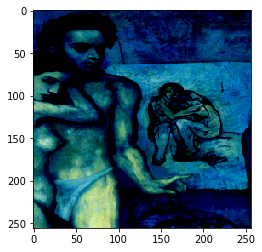

In [10]:
imshow(torchvision.utils.make_grid(content_images.cpu()[2]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


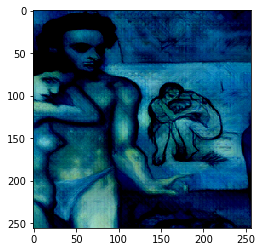

In [11]:
def imshow_recon(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow_recon(torchvision.utils.make_grid(recon_images.cpu()[2]))

torch.Size([8, 32, 32])


(-0.5, 31.5, 31.5, -0.5)

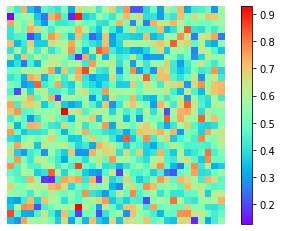

In [12]:
channel_num = attn_map.size()[1]
mean_sal = torch.mean(attn_map, 1, False)
mean_sal_np = mean_sal.cpu().detach().numpy()
mean_sal_np = mean_sal_np - np.min(mean_sal_np)
mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
print(mean_sal.size())
plt.imshow(mean_sal_np[2], cmap=cm.get_cmap('rainbow', 1000))
plt.colorbar()
plt.axis('off')